# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Povos e Comunidades Tradicionais

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Caio Vinicius F. de Araujo
- Guilherme Mendes Pereira
- Julio Cesar Litwin Lima
- Lucas Gomes de Oliveira
- Lucas Gomes Silva
- Lucas Maciel Aguiar

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
18,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
19,functions,9,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
20,security_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
21,files,20,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
22,complexity,18,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
23,ncloc,359,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
24,coverage,83.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
25,reliability_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
26,comment_lines_density,16.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
216,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-07-10-202...,DocumentsAPI,07-10-2021-07-31


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_ts['filename'] = os.path.basename(i)

        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_js['filename'] = os.path.basename(i)

        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_py['filename'] = os.path.basename(i)

        file_component_df_yaml = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'yaml')
        file_component_df_yaml['filename'] = os.path.basename(i)

        df = df.append(file_component_df_ts, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
        df = df.append(file_component_df_yaml, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
7,documents/migrations/0001_initial.py,0,0,4.5,0.0,100.0,21,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
8,documents/migrations/0002_document_classificat...,0,0,7.7,0.0,100.0,12,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
9,documents/migrations/0003_auto_20211028_2212.py,0,0,3.0,0.0,100.0,32,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
10,pcts_documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
11,documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
12,documents/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
13,documents/tests/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
14,documents/admin.py,0,0,0.0,0.0,100.0,1,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
15,documents/apps.py,0,0,0.0,0.0,100.0,4,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
16,pcts_documents/asgi.py,0,0,66.7,0.0,0.0,4,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35


#### Create dataframe per repository

In [12]:
scraper_df = file_component_df[file_component_df['repository'] == 'Scraper']
documentsapi_df = file_component_df[file_component_df['repository'] == 'DocumentsAPI']
mltraining_df = file_component_df[file_component_df['repository'] == 'MLTraining']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0

        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0

        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [18]:
def m5(df):

    count_tests = sum(df['tests'].astype(float))
    if count_tests or count_tests == 0:
        density_fast_test_builds = 0
        return 0
    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / count_tests

    return density_fast_test_builds if not np.isnan(density_fast_test_builds) else 0

##### Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list,
                               'version': version_list,
                               'ncloc': ncloc_list})

    return metrics_df

In [21]:
scraper_metrics = create_metrics_df(scraper_df)
documentsapi_metrics = create_metrics_df(documentsapi_df)
mltraining_metrics = create_metrics_df(mltraining_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

In [22]:
def create_descriptive_df(df):
    maintainability_df = df['maintainability']
    reliability_df = df['Reliability']
    
    descriptive_df = pd.DataFrame(
                columns=['Maintainability', 'Reliability'])
    
    descriptive_df.loc['mean'] = [maintainability_df.mean(), reliability_df.mean()]
    descriptive_df.loc['mode'] = [maintainability_df.mode().max(), reliability_df.mode().max()]
    descriptive_df.loc['25%'] = [maintainability_df.quantile(0.25), reliability_df.quantile(0.25)]
    descriptive_df.loc['50%'] = [maintainability_df.quantile(0.50), reliability_df.quantile(0.50)]
    descriptive_df.loc['75%'] = [maintainability_df.quantile(0.75), reliability_df.quantile(0.75)]
    descriptive_df.loc['90%'] = [maintainability_df.quantile(0.90), reliability_df.quantile(0.90)]
    descriptive_df.loc['99%'] = [maintainability_df.quantile(0.99), reliability_df.quantile(0.99)]
    descriptive_df.loc['standart_deviation'] = [maintainability_df.std(), reliability_df.std()]
    descriptive_df.loc['variance'] = [maintainability_df.var(), reliability_df.var()]
    descriptive_df.loc['min'] = [maintainability_df.min(), reliability_df.min()]
    descriptive_df.loc['max'] = [maintainability_df.max(), reliability_df.max()]
    
    
    return descriptive_df

In [23]:
def create_descriptive_with_code_and_maintain_df(df):
    code_quality_df = df['code_quality']
    testing_status_df = df['testing_status']
    maintainability_df = df['maintainability']
    reliability_df = df['Reliability']
    
    descriptive_df = pd.DataFrame(
                columns=['code_quality', 'testing_status', 'Maintainability', 'Reliability'])
    
    descriptive_df.loc['mean'] = [code_quality_df.mean(), testing_status_df.mean(), maintainability_df.mean(), reliability_df.mean()]
    descriptive_df.loc['mode'] = [code_quality_df.mode().max(), testing_status_df.mode().max(), maintainability_df.mode().max(), reliability_df.mode().max()]
    descriptive_df.loc['25%'] = [code_quality_df.quantile(0.25), testing_status_df.quantile(0.25), maintainability_df.quantile(0.25), reliability_df.quantile(0.25)]
    descriptive_df.loc['50%'] = [code_quality_df.quantile(0.50), testing_status_df.quantile(0.50), maintainability_df.quantile(0.50), reliability_df.quantile(0.50)]
    descriptive_df.loc['75%'] = [code_quality_df.quantile(0.75), testing_status_df.quantile(0.75), maintainability_df.quantile(0.75), reliability_df.quantile(0.75)]
    descriptive_df.loc['90%'] = [code_quality_df.quantile(0.90), testing_status_df.quantile(0.90), maintainability_df.quantile(0.90), reliability_df.quantile(0.90)]
    descriptive_df.loc['99%'] = [code_quality_df.quantile(0.99), testing_status_df.quantile(0.99), maintainability_df.quantile(0.99), reliability_df.quantile(0.99)]
    descriptive_df.loc['standart_deviation'] = [code_quality_df.std(), testing_status_df.std(), maintainability_df.std(), reliability_df.std()]
    descriptive_df.loc['variance'] = [code_quality_df.var(), testing_status_df.var(), maintainability_df.var(), reliability_df.var()]
    descriptive_df.loc['min'] = [code_quality_df.min(), testing_status_df.min(), maintainability_df.min(), reliability_df.min()]
    descriptive_df.loc['max'] = [code_quality_df.max(), testing_status_df.max(), maintainability_df.max(), reliability_df.max()]
    
    
    return descriptive_df

### Scraper

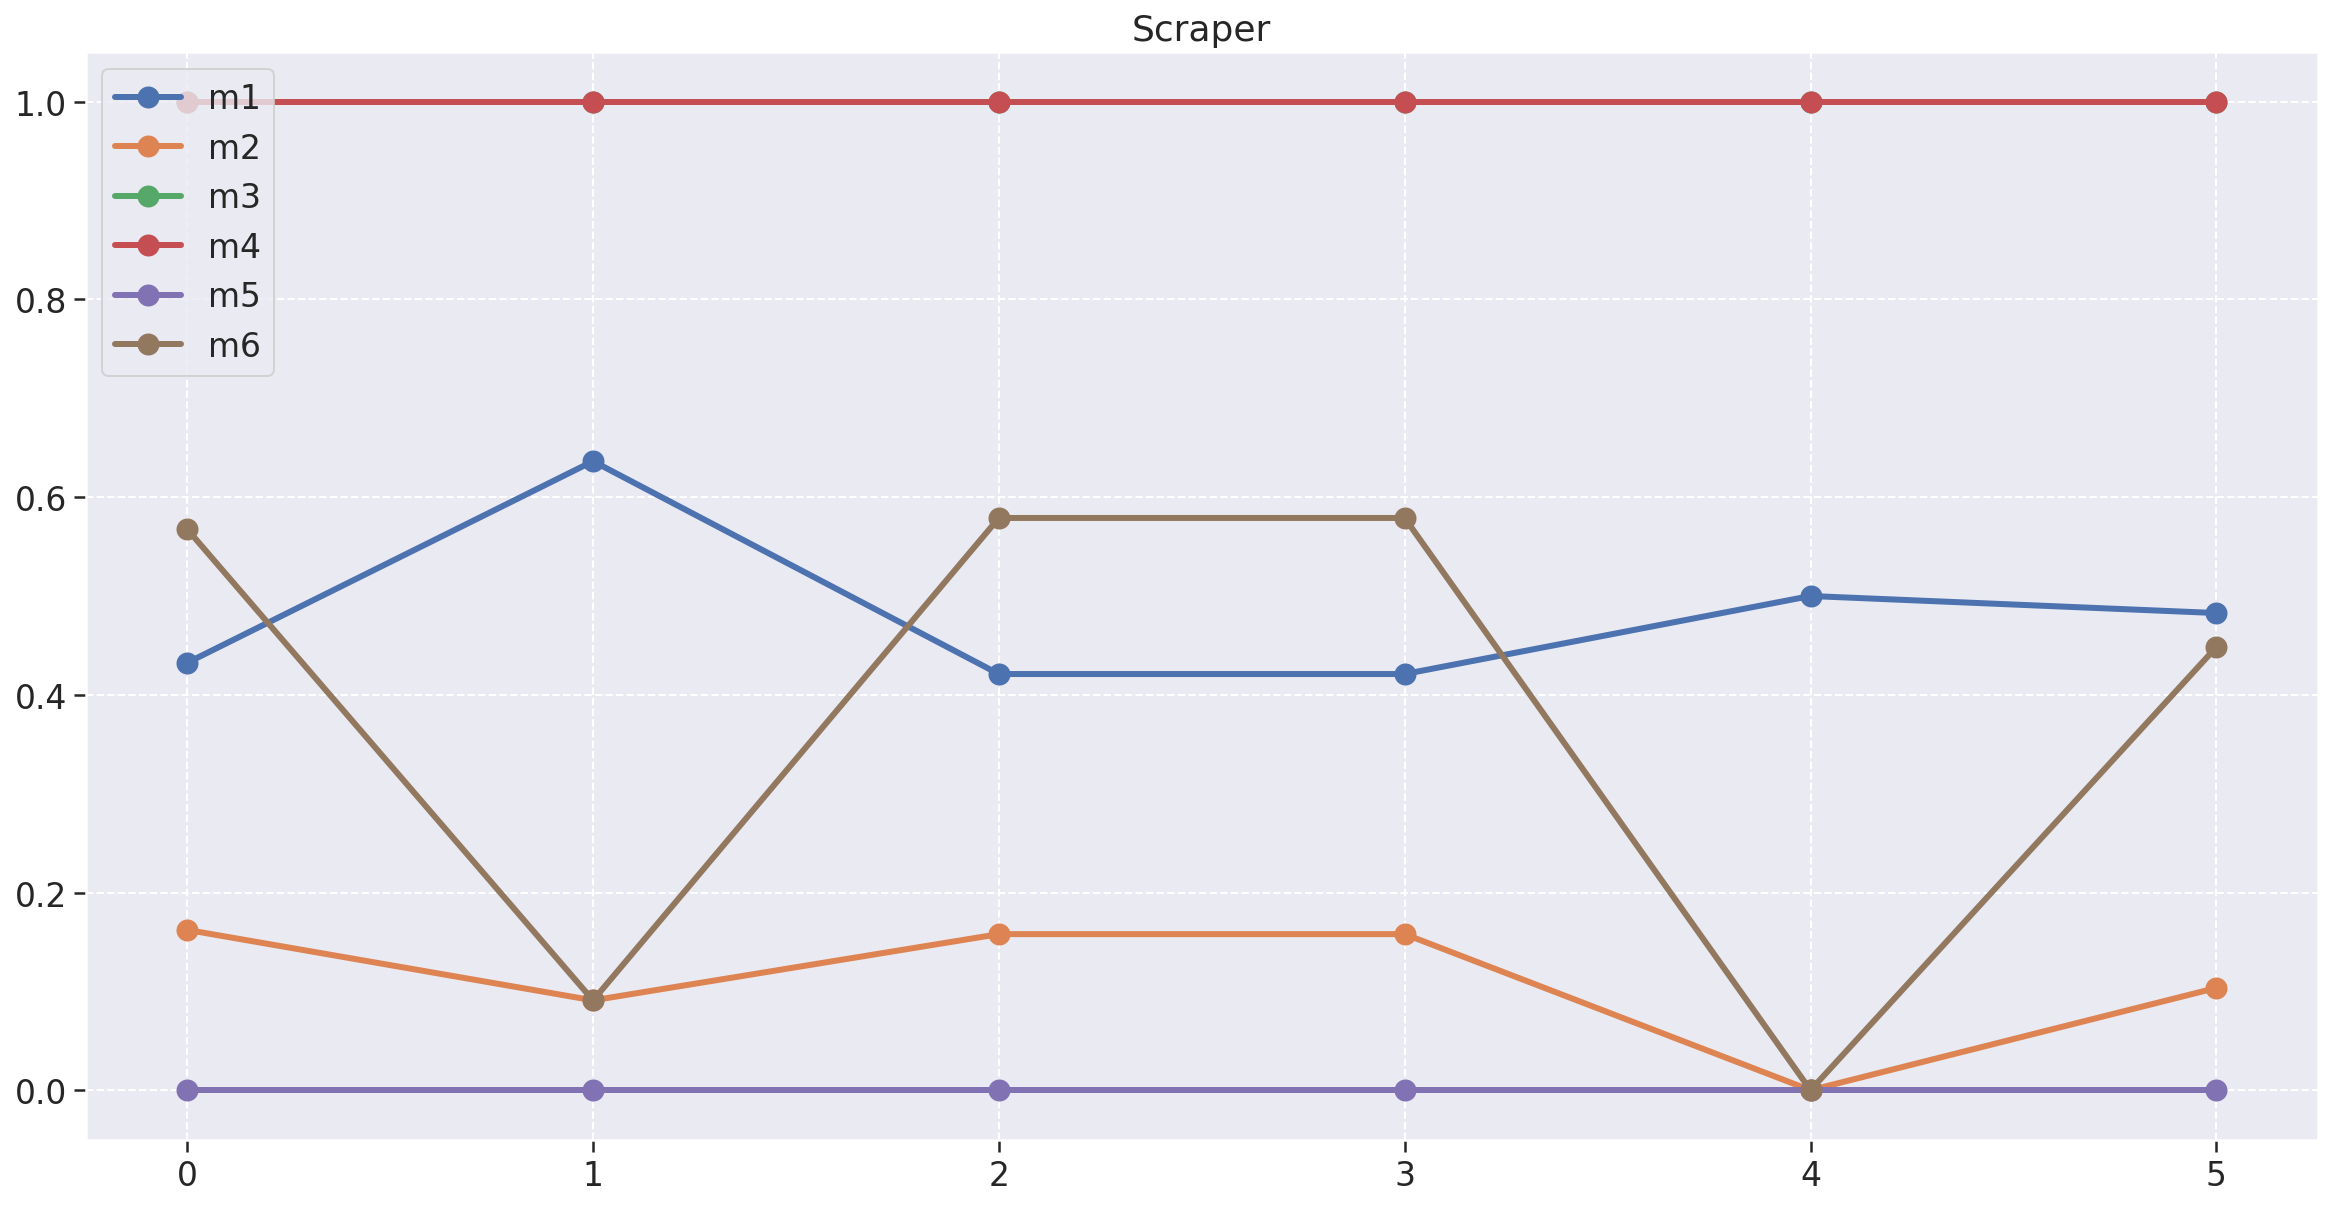

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper')
plt.plot(scraper_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(scraper_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(scraper_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(scraper_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(scraper_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(scraper_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Documents API

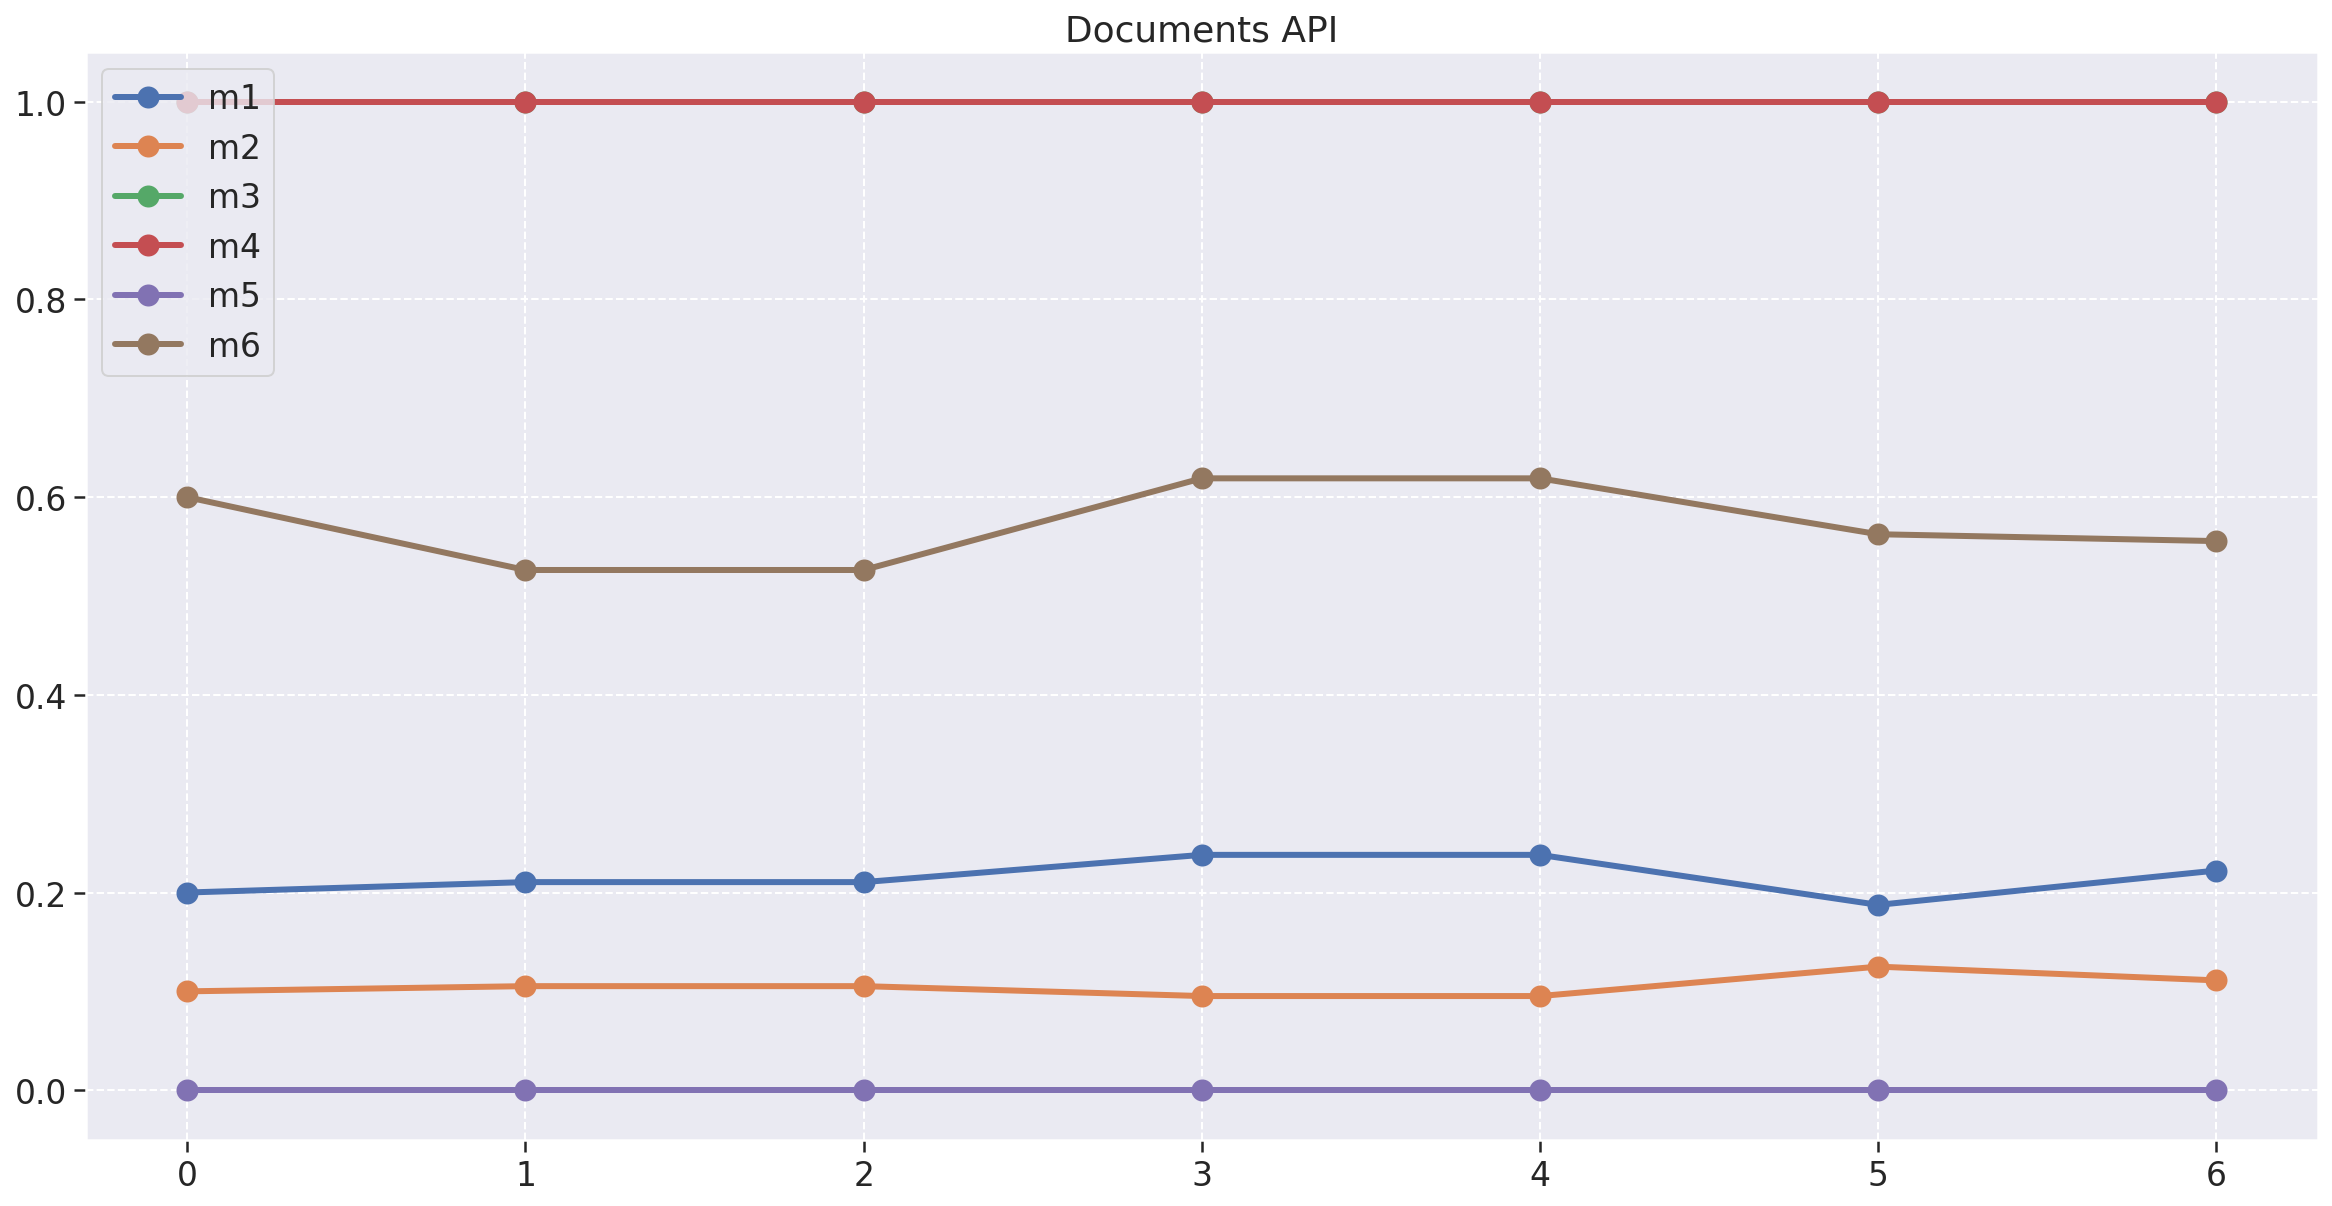

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('Documents API')
plt.plot(documentsapi_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(documentsapi_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(documentsapi_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(documentsapi_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(documentsapi_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(documentsapi_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### ML Training

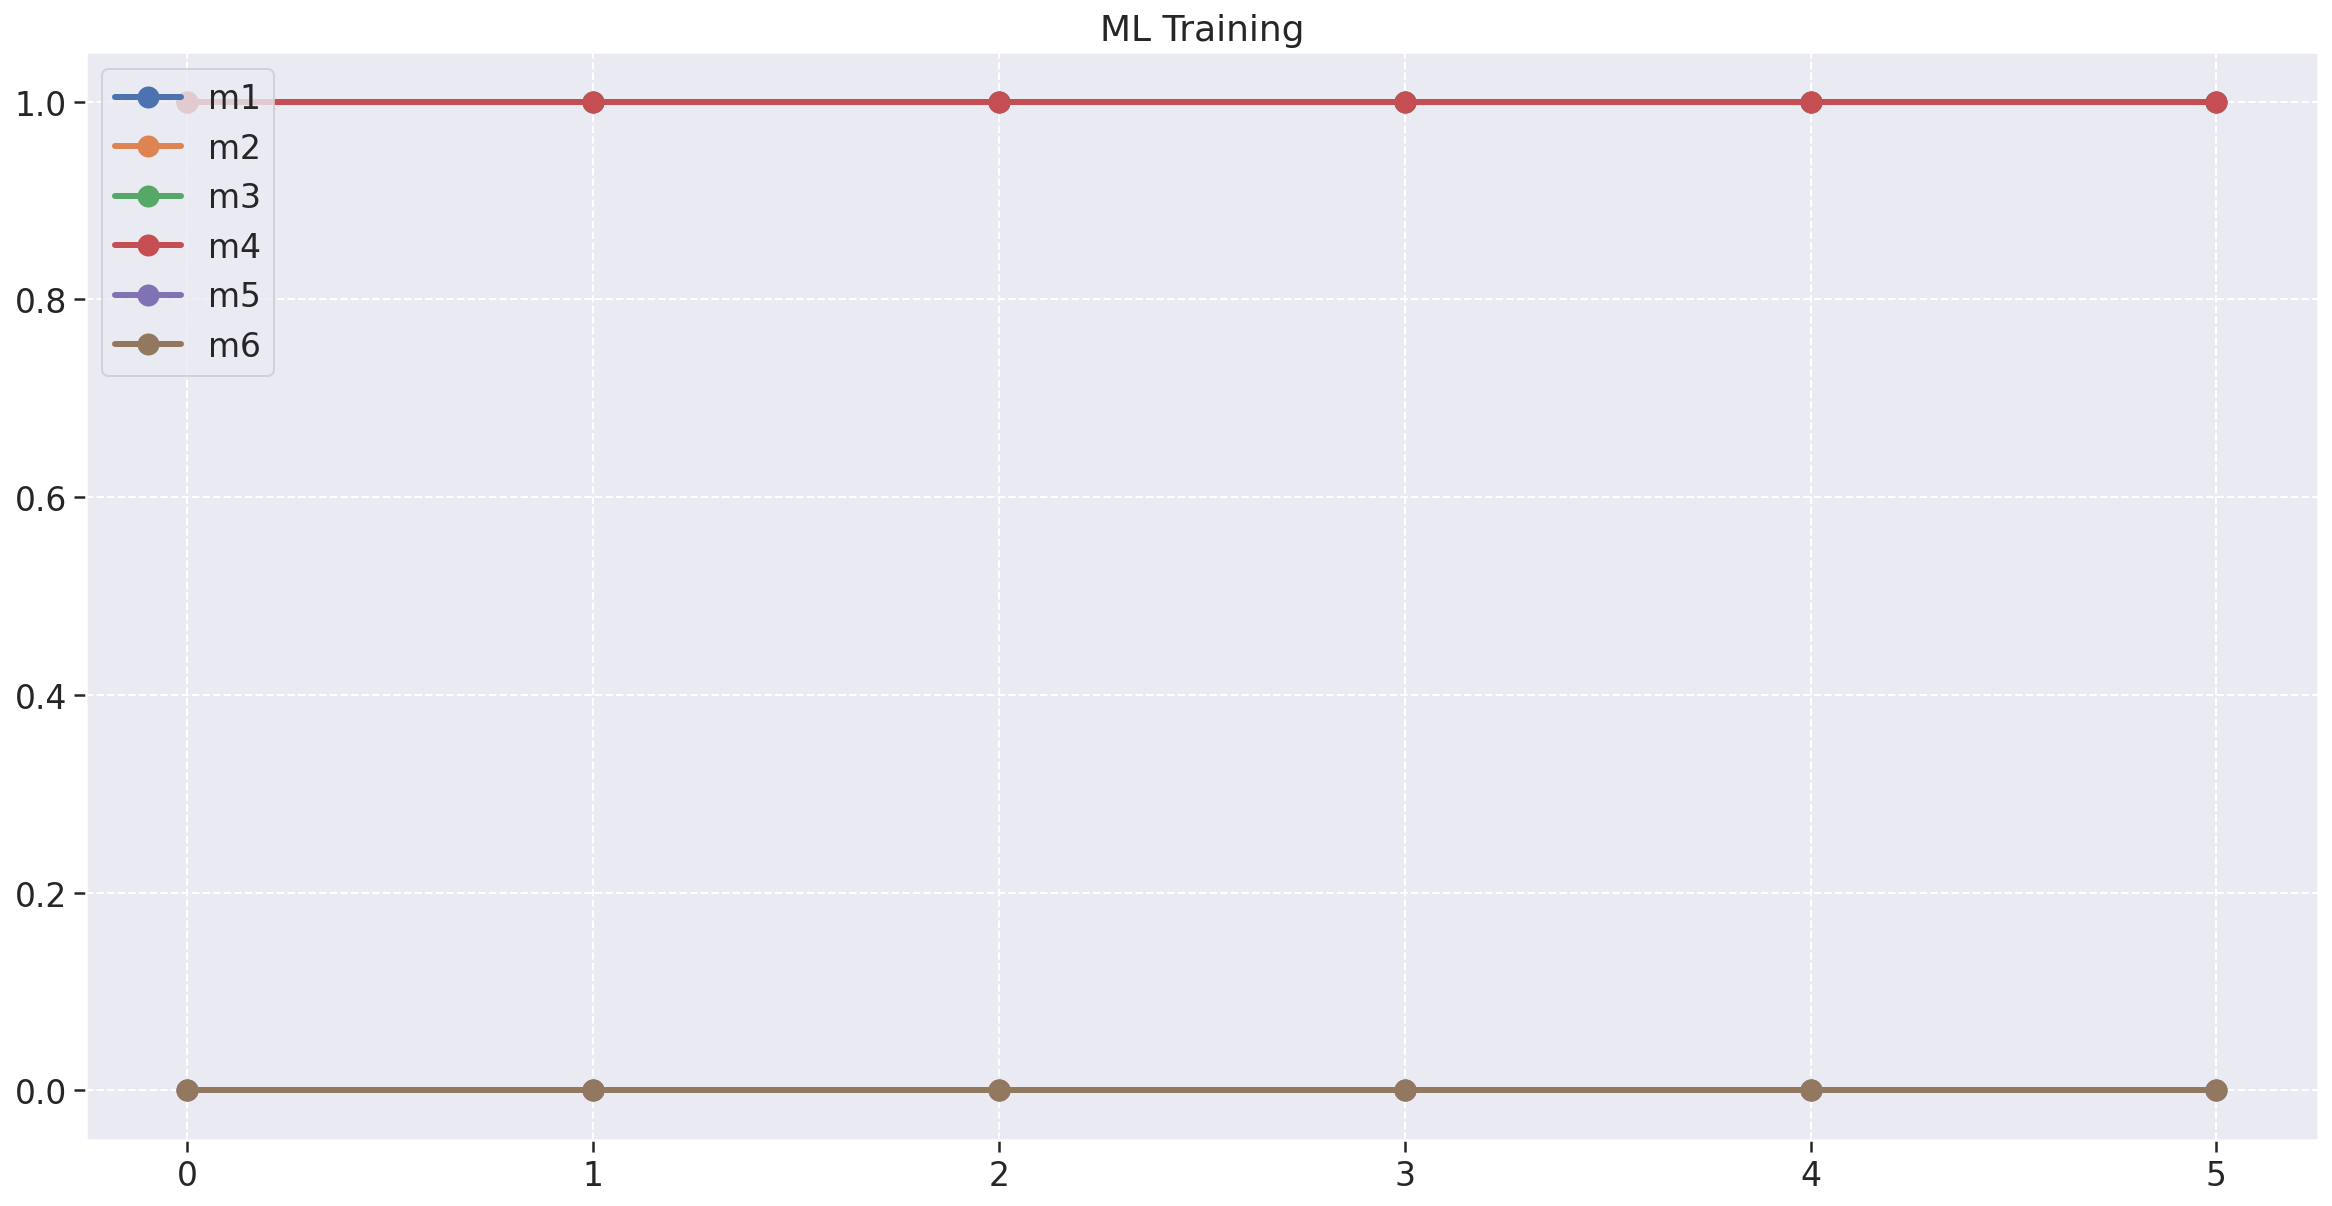

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training')
plt.plot(mltraining_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(mltraining_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(mltraining_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(mltraining_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(mltraining_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(mltraining_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Front End

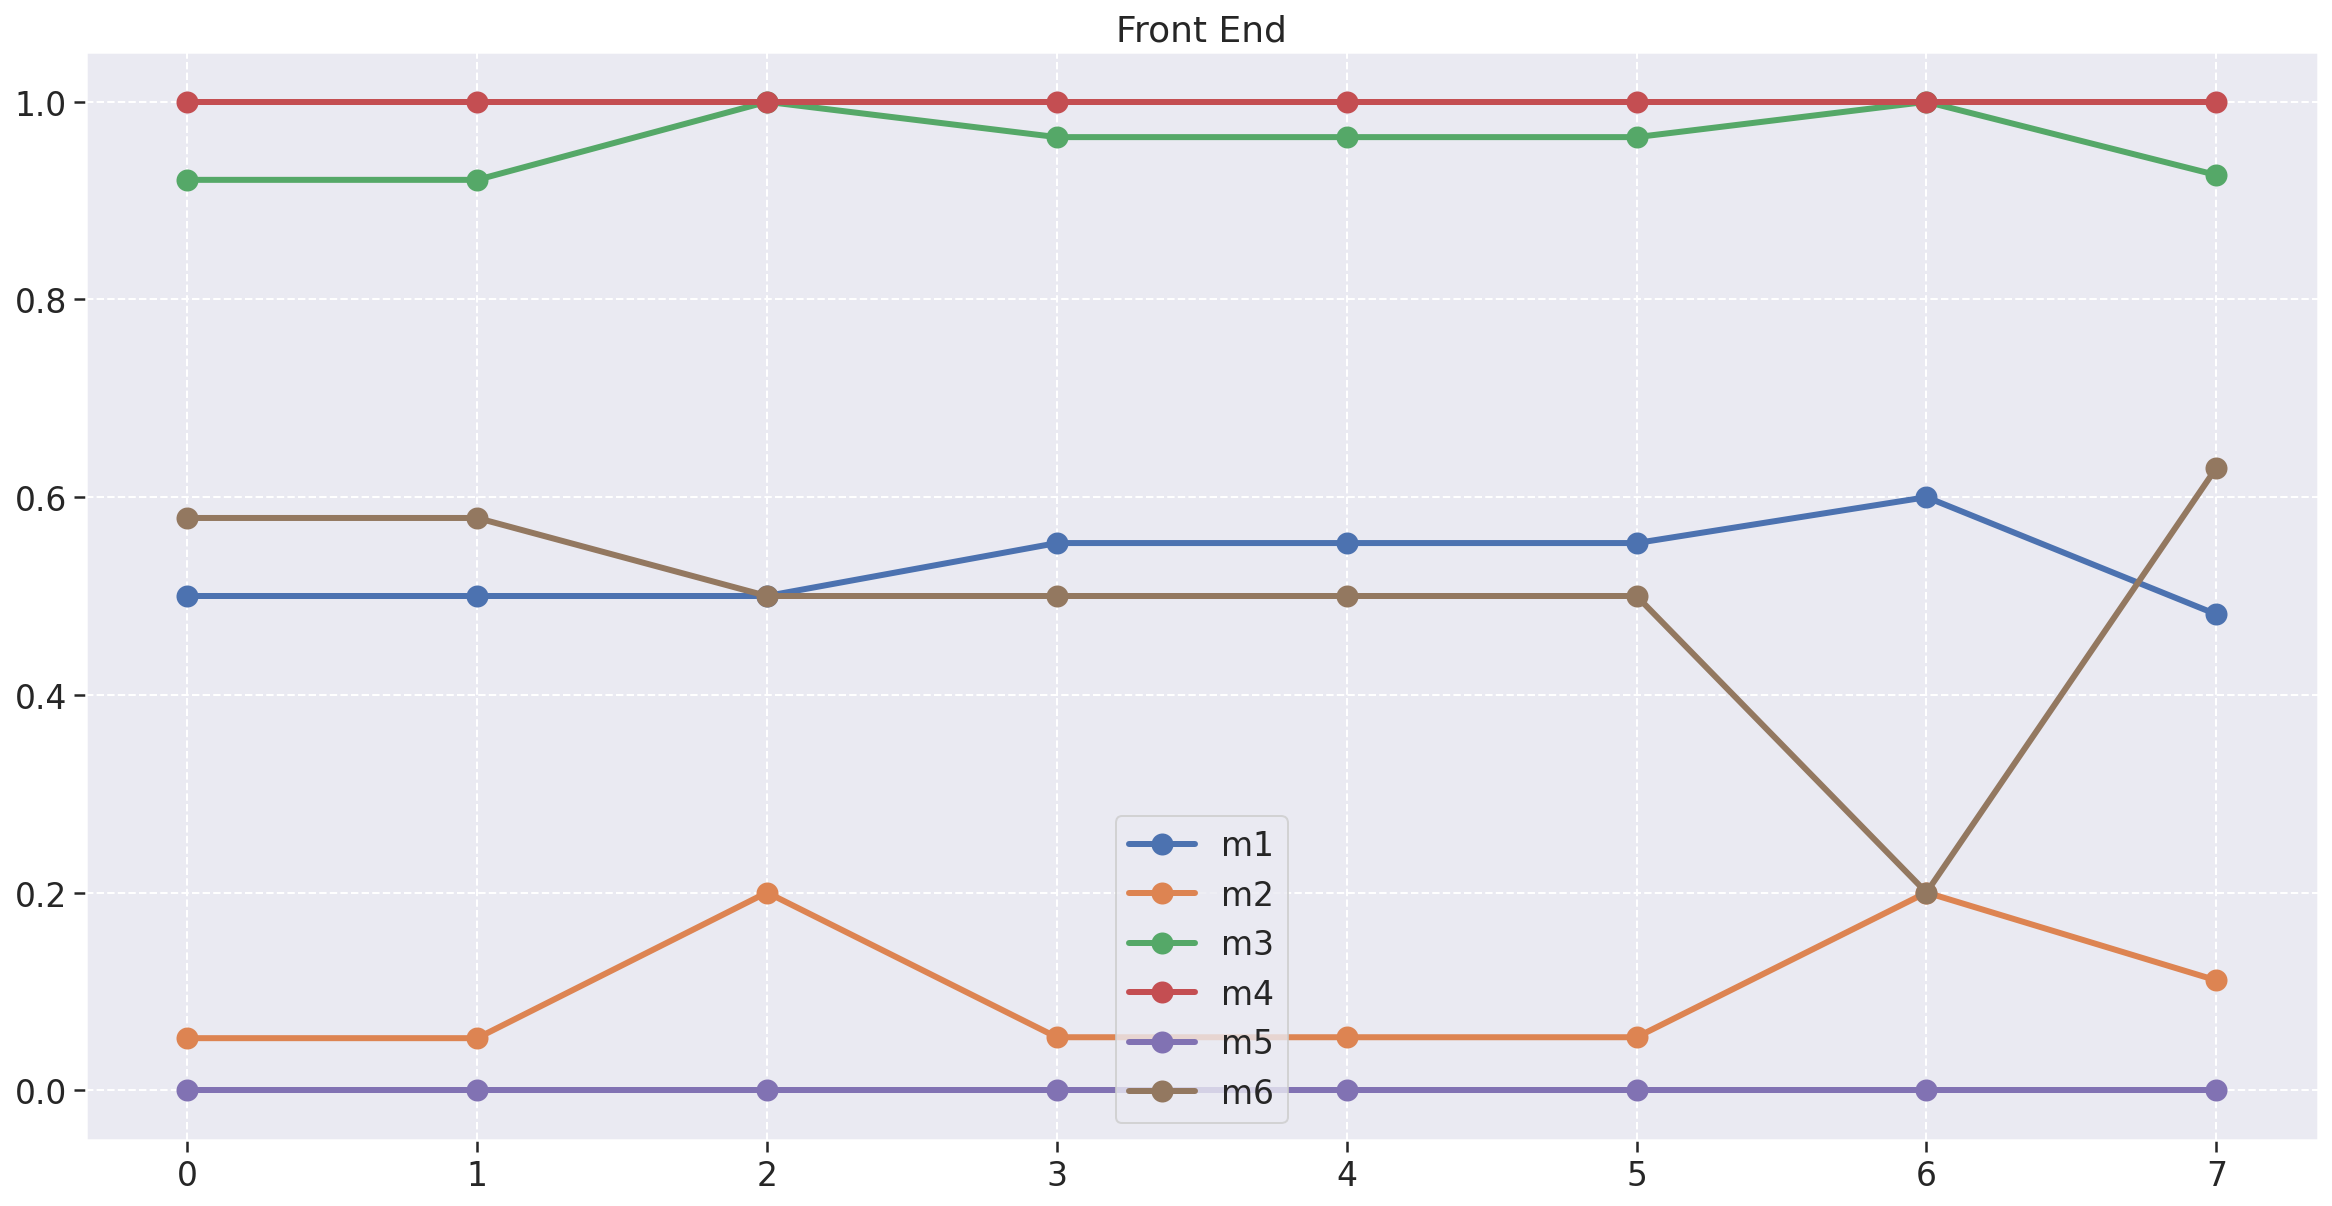

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End')
plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [28]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

scraper_metrics['code_quality'] = ((scraper_metrics['m1']*pm1) + (scraper_metrics['m2']*pm2) + (scraper_metrics['m3']*pm3)) * psc1
documentsapi_metrics['code_quality'] = ((documentsapi_metrics['m1']*pm1) + (documentsapi_metrics['m2']*pm2) + (documentsapi_metrics['m3']*pm3)) * psc1
mltraining_metrics['code_quality'] = ((mltraining_metrics['m1']*pm1) + (mltraining_metrics['m2']*pm2) + (mltraining_metrics['m3']*pm3)) * psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1) + (frontend_metrics['m2']*pm2) + (frontend_metrics['m3']*pm3)) * psc1

scraper_metrics['testing_status'] = ((scraper_metrics['m4']*pm4) + (scraper_metrics['m5']*pm5) + (scraper_metrics['m6']*pm6)) * psc2
documentsapi_metrics['testing_status'] = ((documentsapi_metrics['m4']*pm4) + (documentsapi_metrics['m5']*pm5) + (documentsapi_metrics['m6']*pm6)) * psc2
mltraining_metrics['testing_status'] = ((mltraining_metrics['m4']*pm4) + (mltraining_metrics['m5']*pm5) + (mltraining_metrics['m6']*pm6)) * psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4) + (frontend_metrics['m5']*pm5) + (frontend_metrics['m6']*pm6)) * psc2

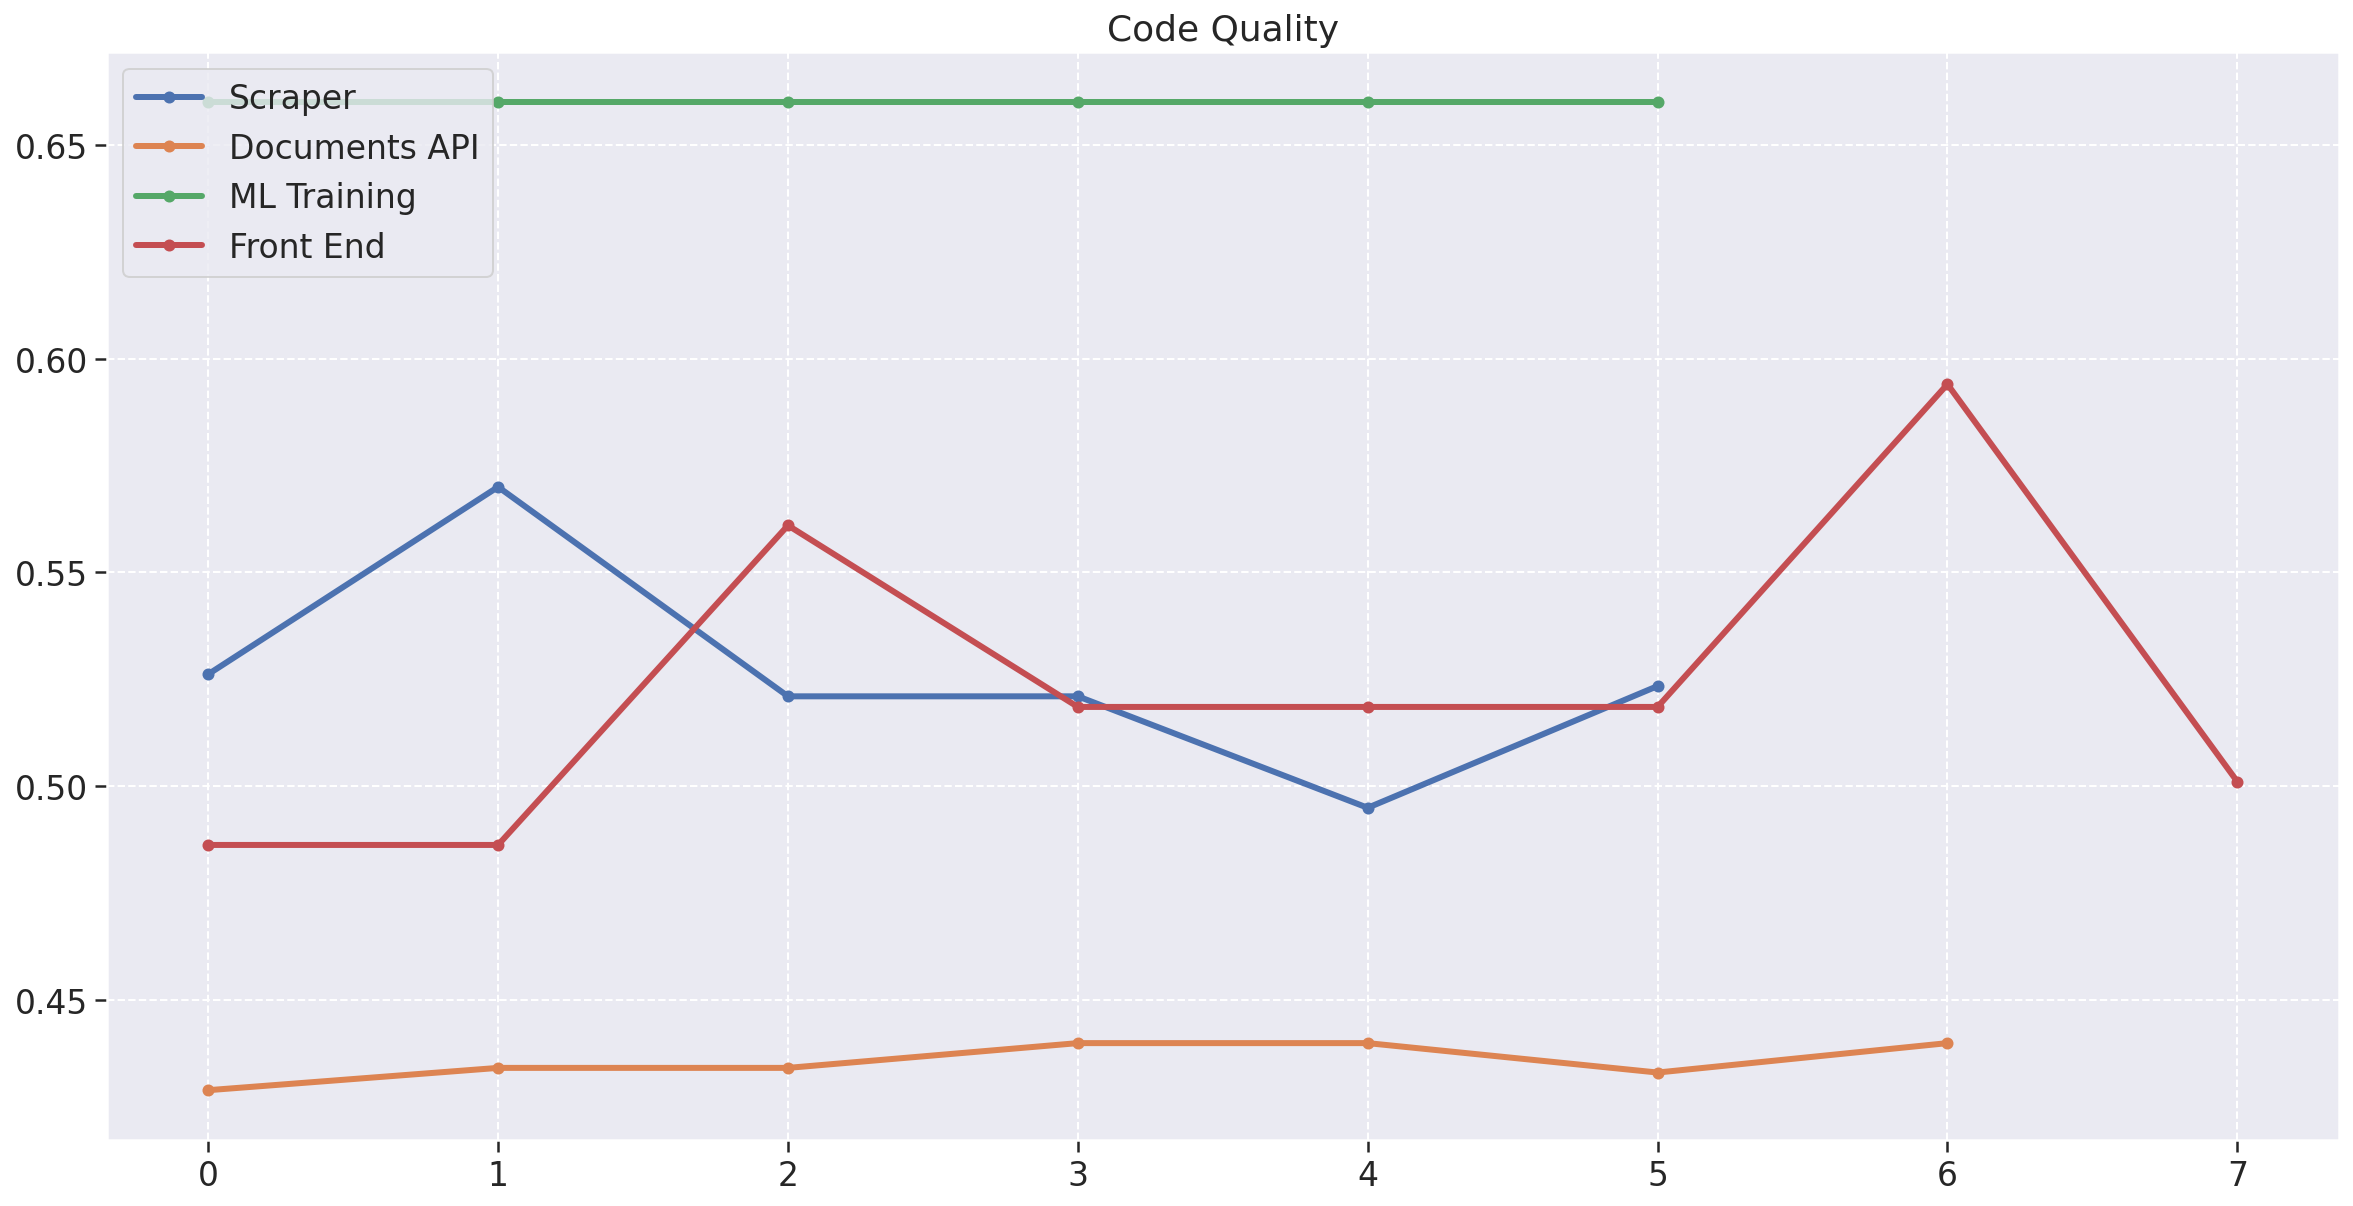

In [29]:
fig = plt.figure(figsize=(20, 10))


plt.title('Code Quality')
plt.plot(scraper_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

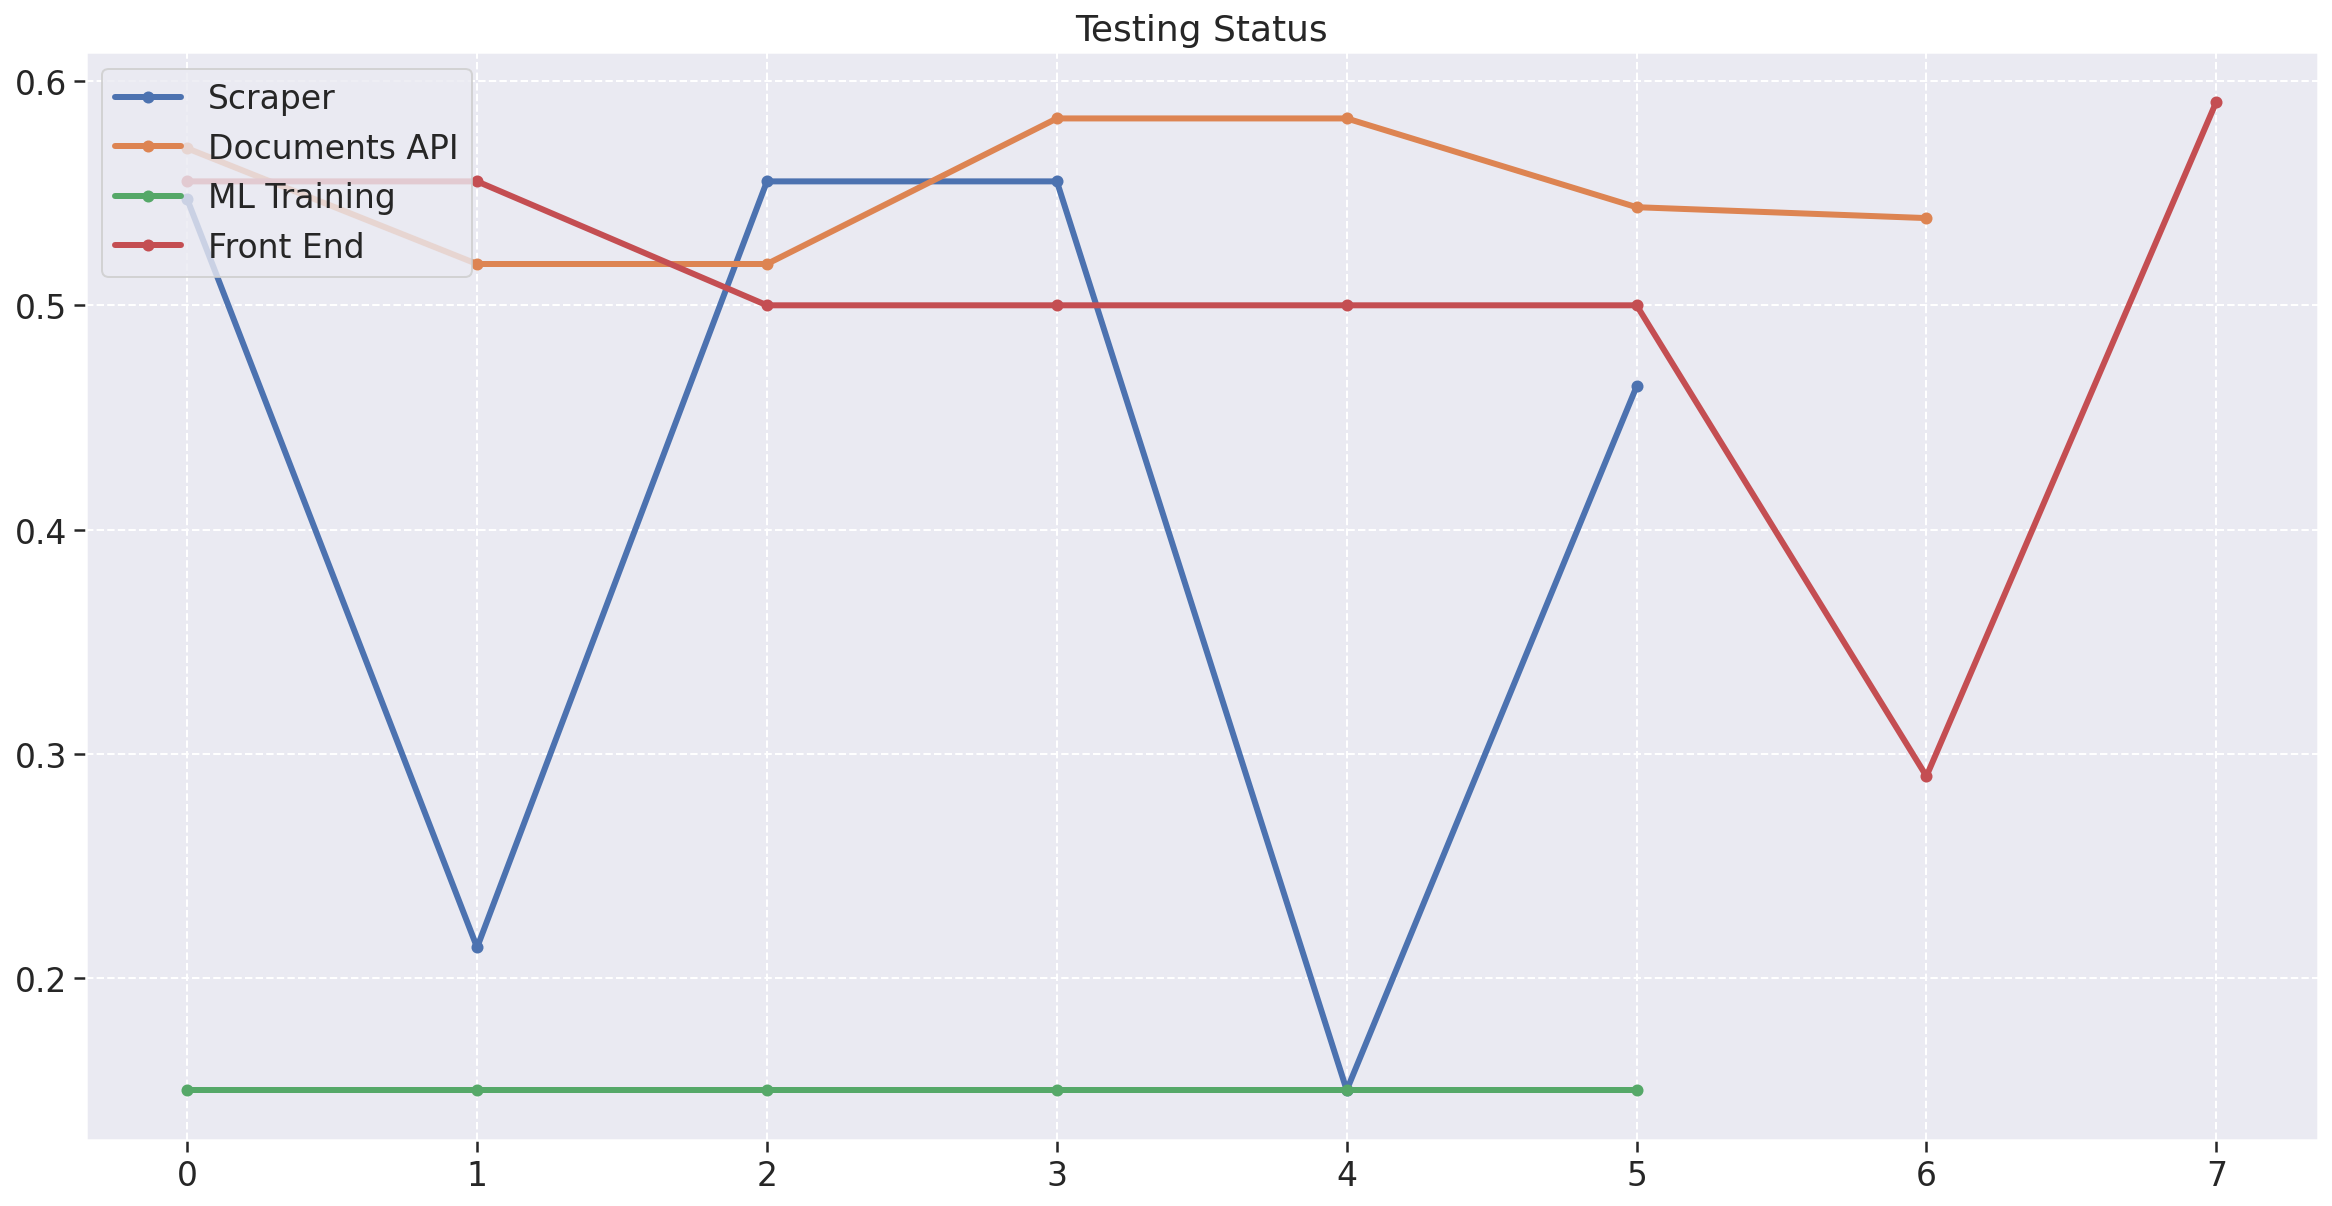

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(scraper_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

## Descriptive Statistics

### Scraper

In [31]:
scraper_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.432432,0.162162,1.0,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297
1,0.636364,0.090909,1.0,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636
2,0.421053,0.157895,1.0,1.0,0,0.578947,Scraper,07-11-2021-19-54,1337,0.521053,0.555263
3,0.421053,0.157895,1.0,1.0,0,0.578947,Scraper,10-11-2021-00-55,1337,0.521053,0.555263
4,0.500000,0.000000,1.0,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000
5,0.482759,0.103448,1.0,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793


In [32]:
scraper_metrics_df = scraper_metrics

scraper_metrics_df['maintainability'] = scraper_metrics_df['code_quality'] * pc1
scraper_metrics_df['Reliability'] = scraper_metrics_df['testing_status'] * pc2

scraper_descriptive_df = create_descriptive_with_code_and_maintain_df(scraper_metrics_df)

In [33]:
scraper_descriptive_df

,code_quality,testing_status,Maintainability,Reliability
mean,0.526128,0.414209,0.263064,0.207104
mode,0.521053,0.555263,0.260526,0.277632
25%,0.521053,0.276176,0.260526,0.138088
50%,0.522250,0.505545,0.261125,0.252773
75%,0.525524,0.553272,0.262762,0.276636
90%,0.548108,0.555263,0.274054,0.277632
99%,0.567811,0.555263,0.283905,0.277632
standart_deviation,0.024300,0.184391,0.012150,0.092195
variance,0.000590,0.034000,0.000148,0.008500
min,0.495000,0.150000,0.247500,0.075000


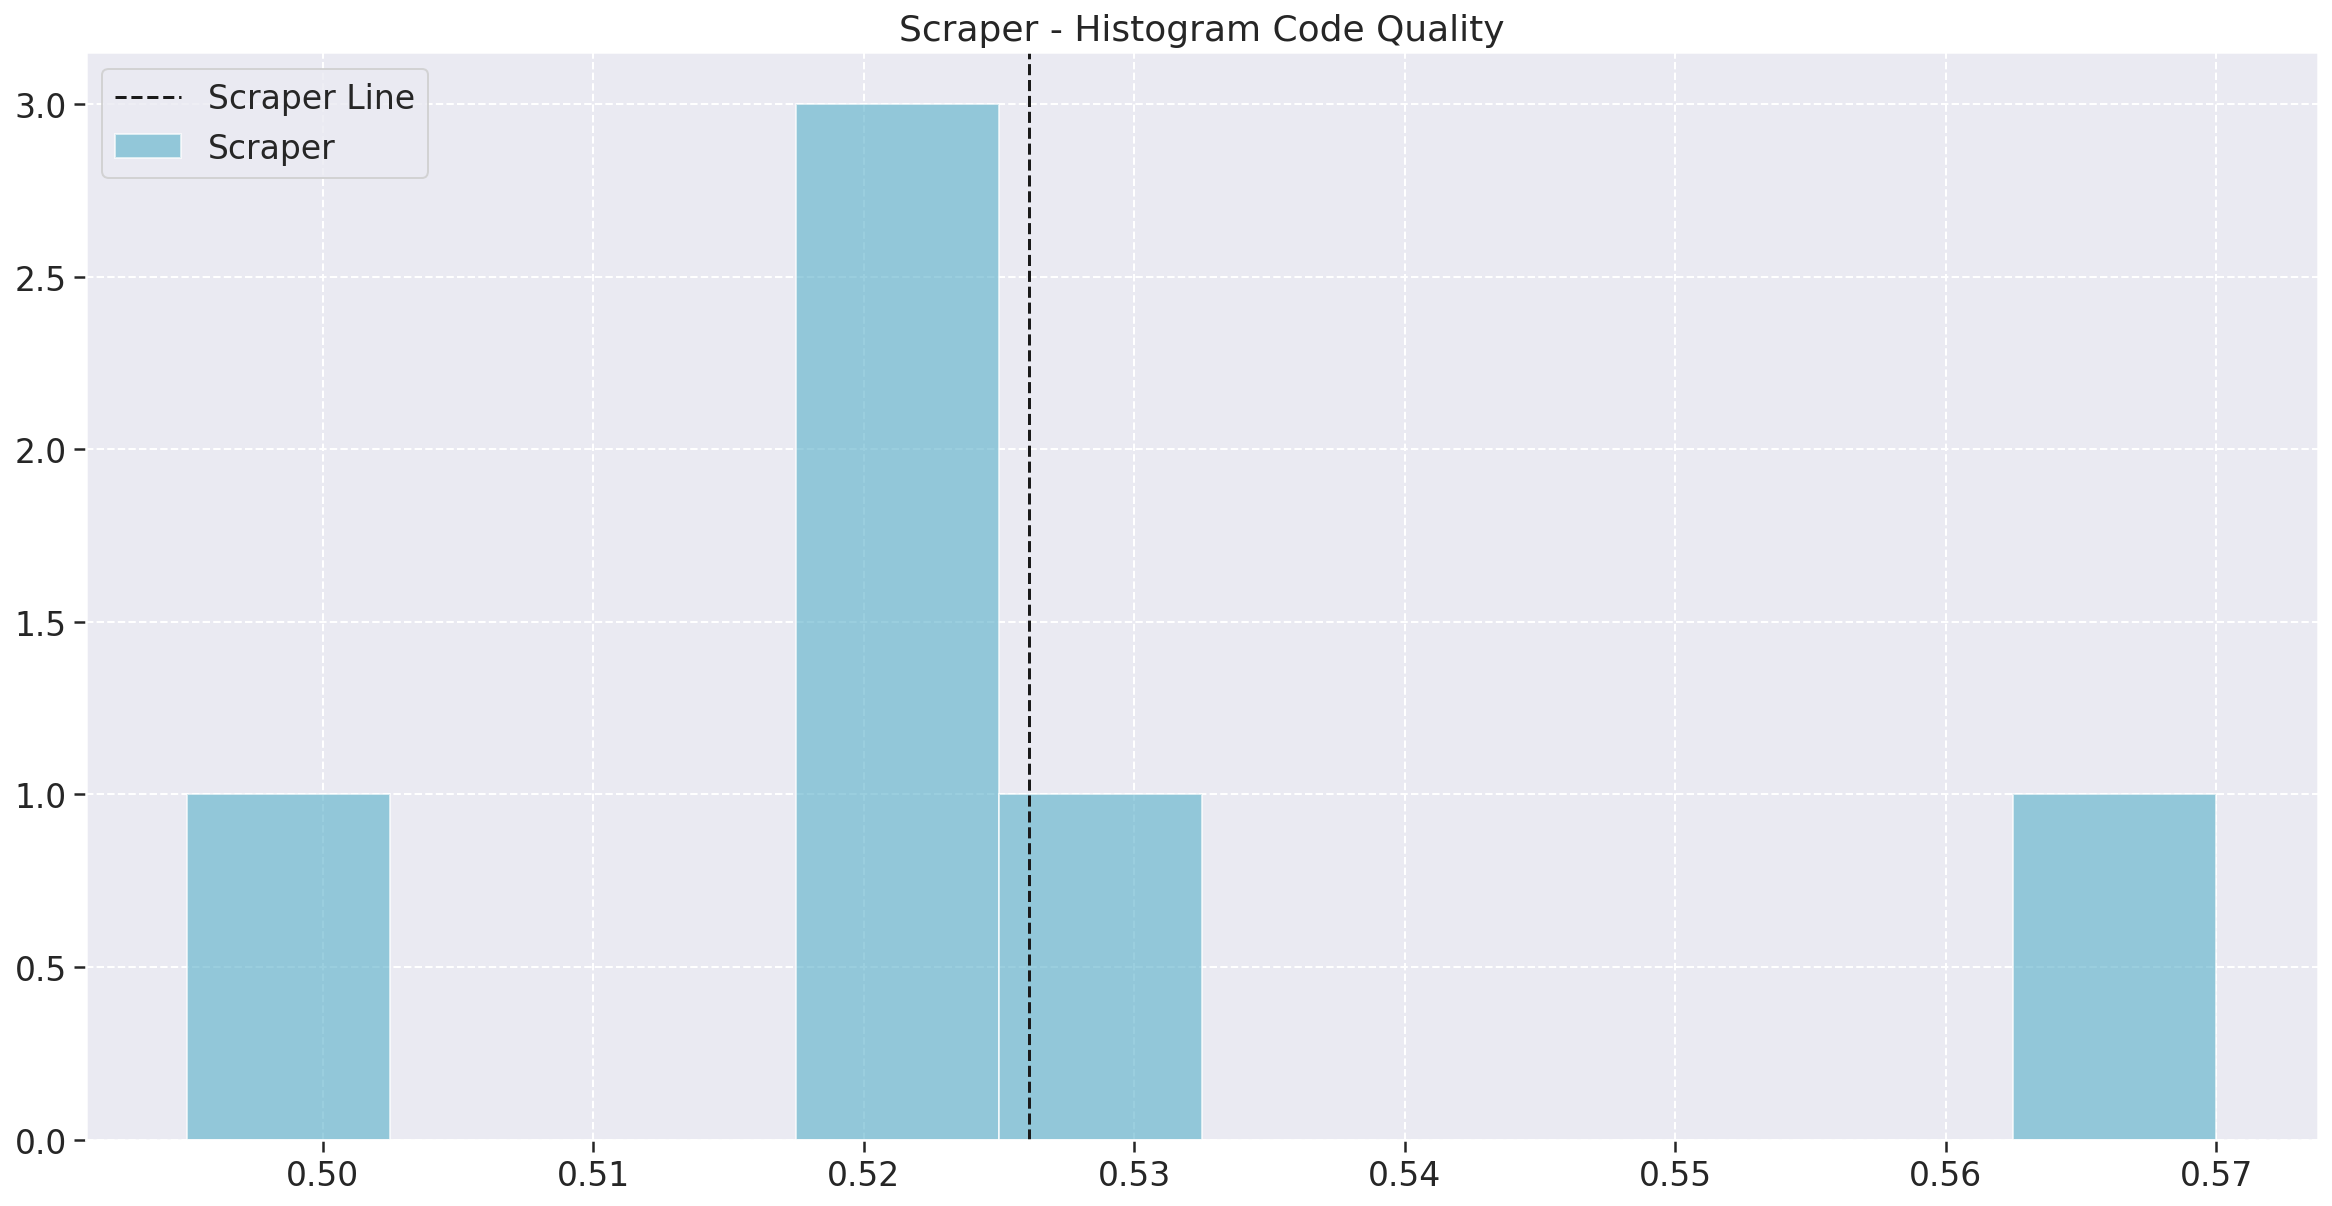

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Code Quality')
plt.hist(scraper_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

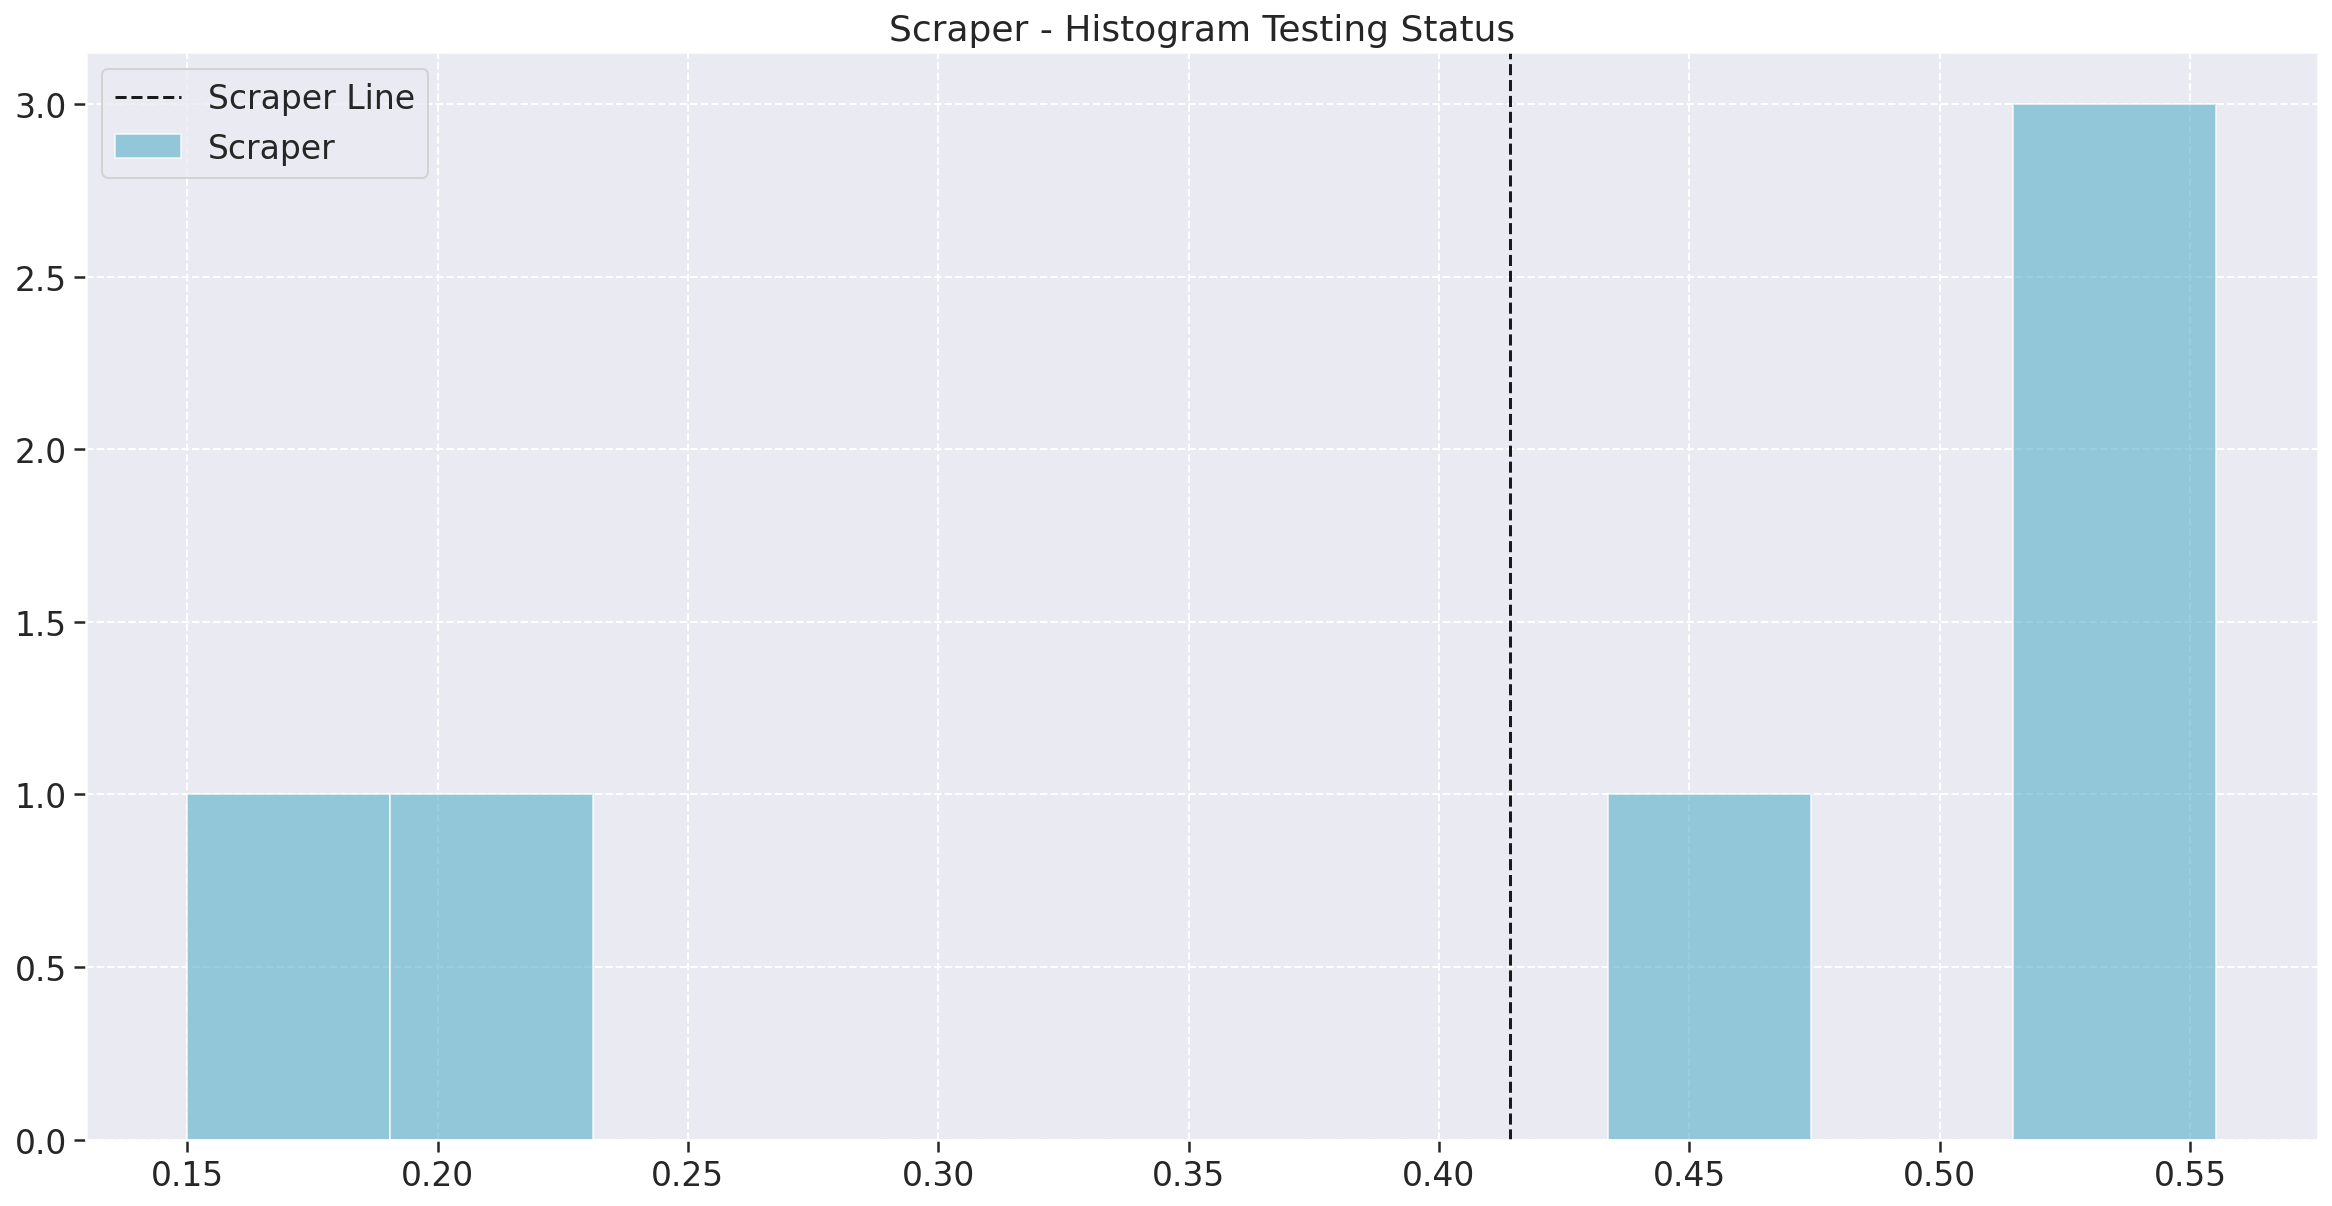

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Testing Status')
plt.hist(scraper_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bef3eca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bef48400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bef3e910>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bef48b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bef48eb0>],
 'means': []}

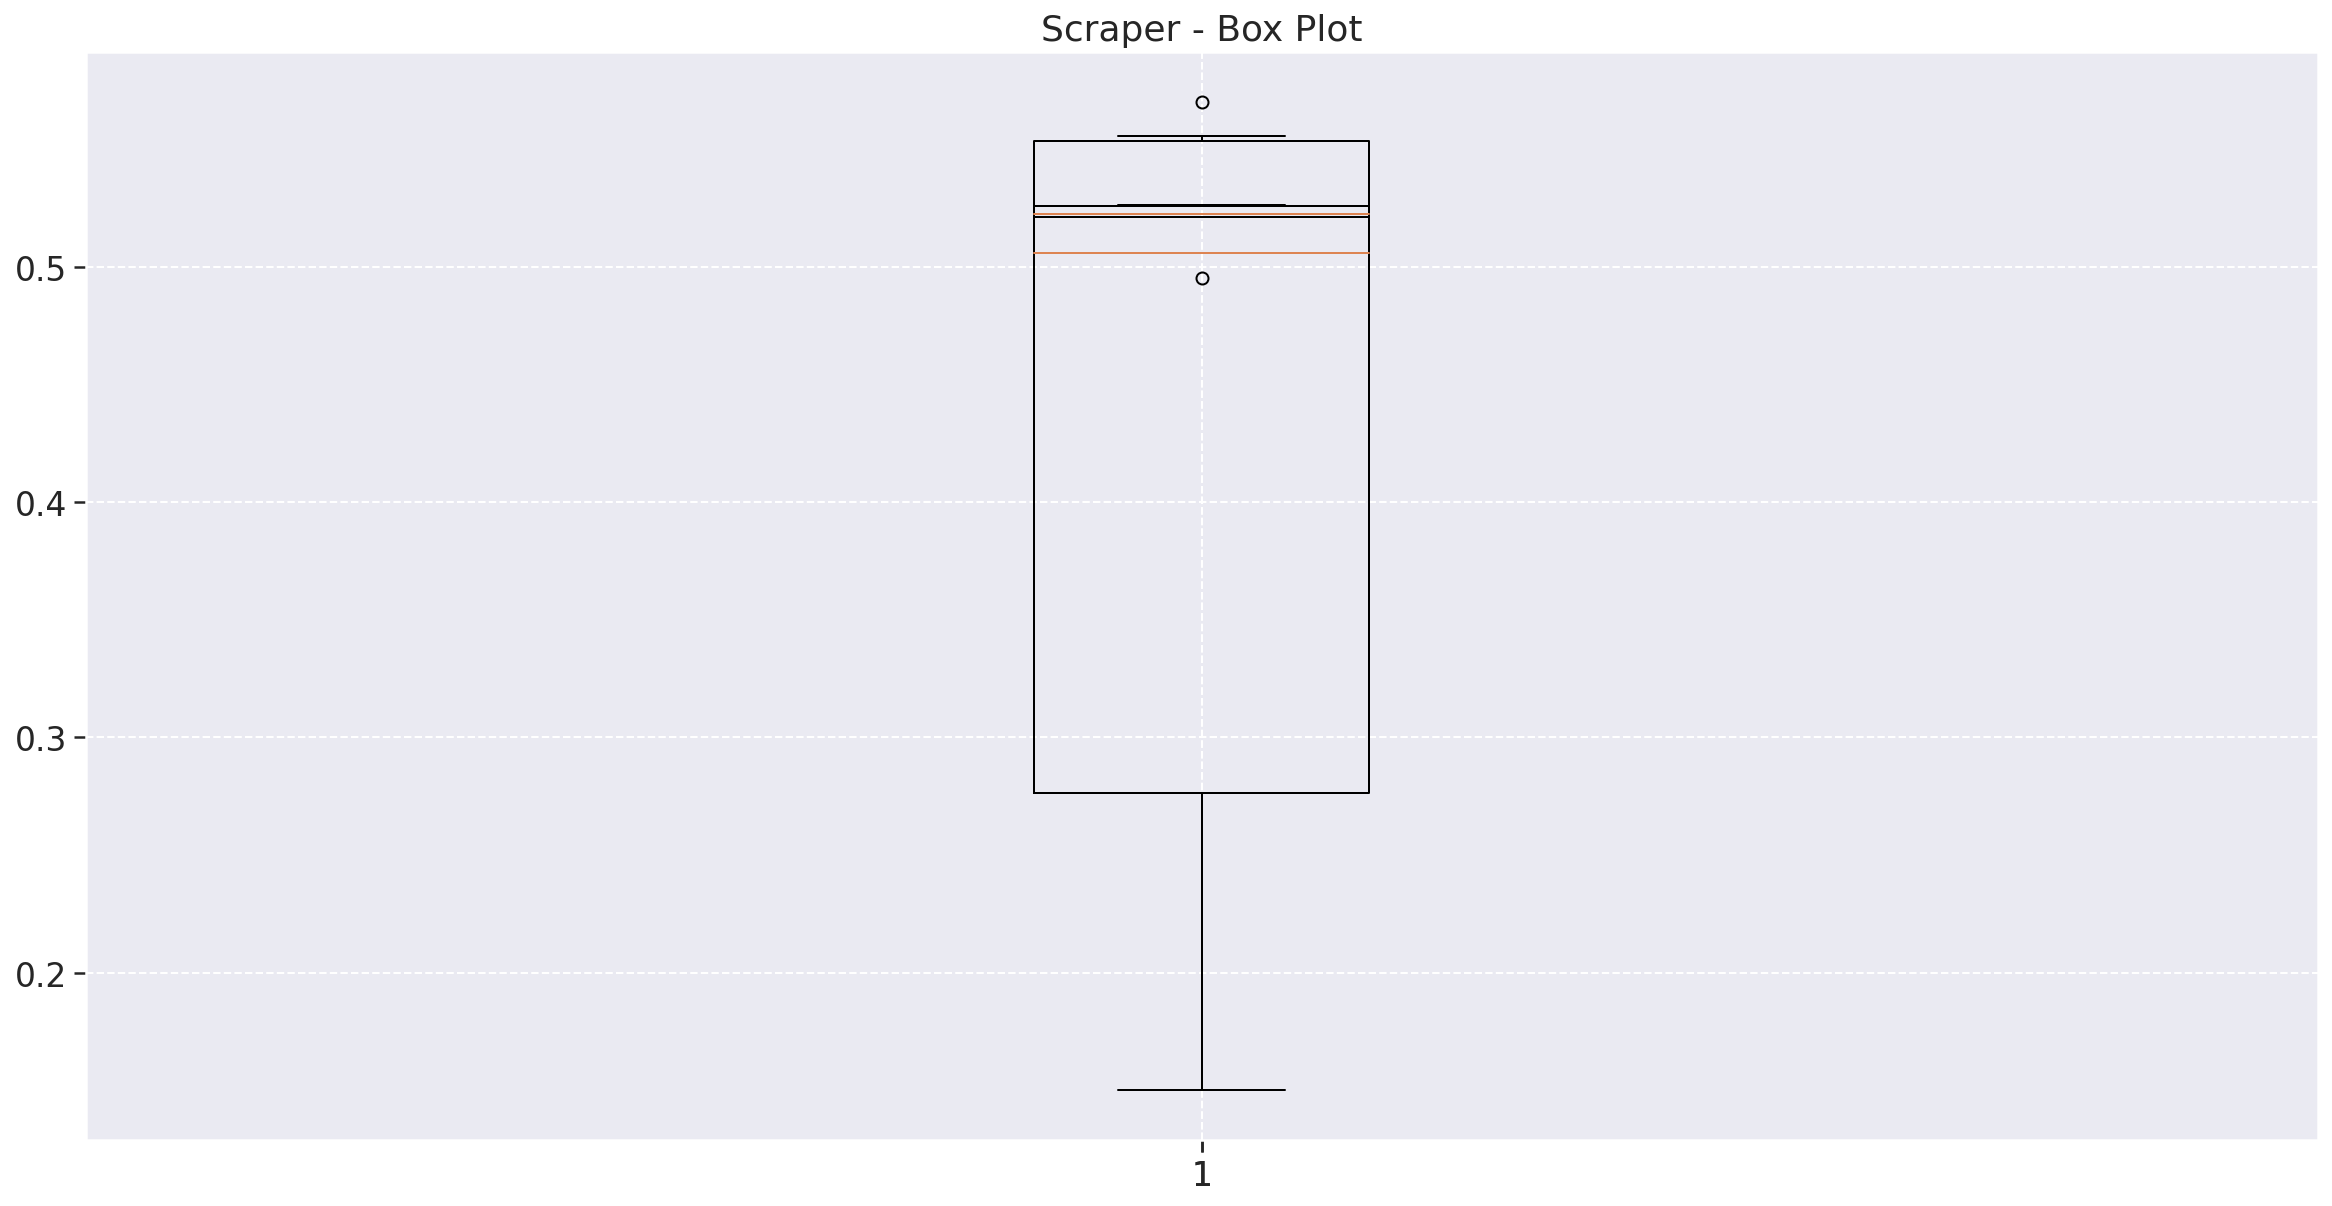

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Box Plot')
plt.boxplot(scraper_metrics['code_quality'])
plt.boxplot(scraper_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Scraper')

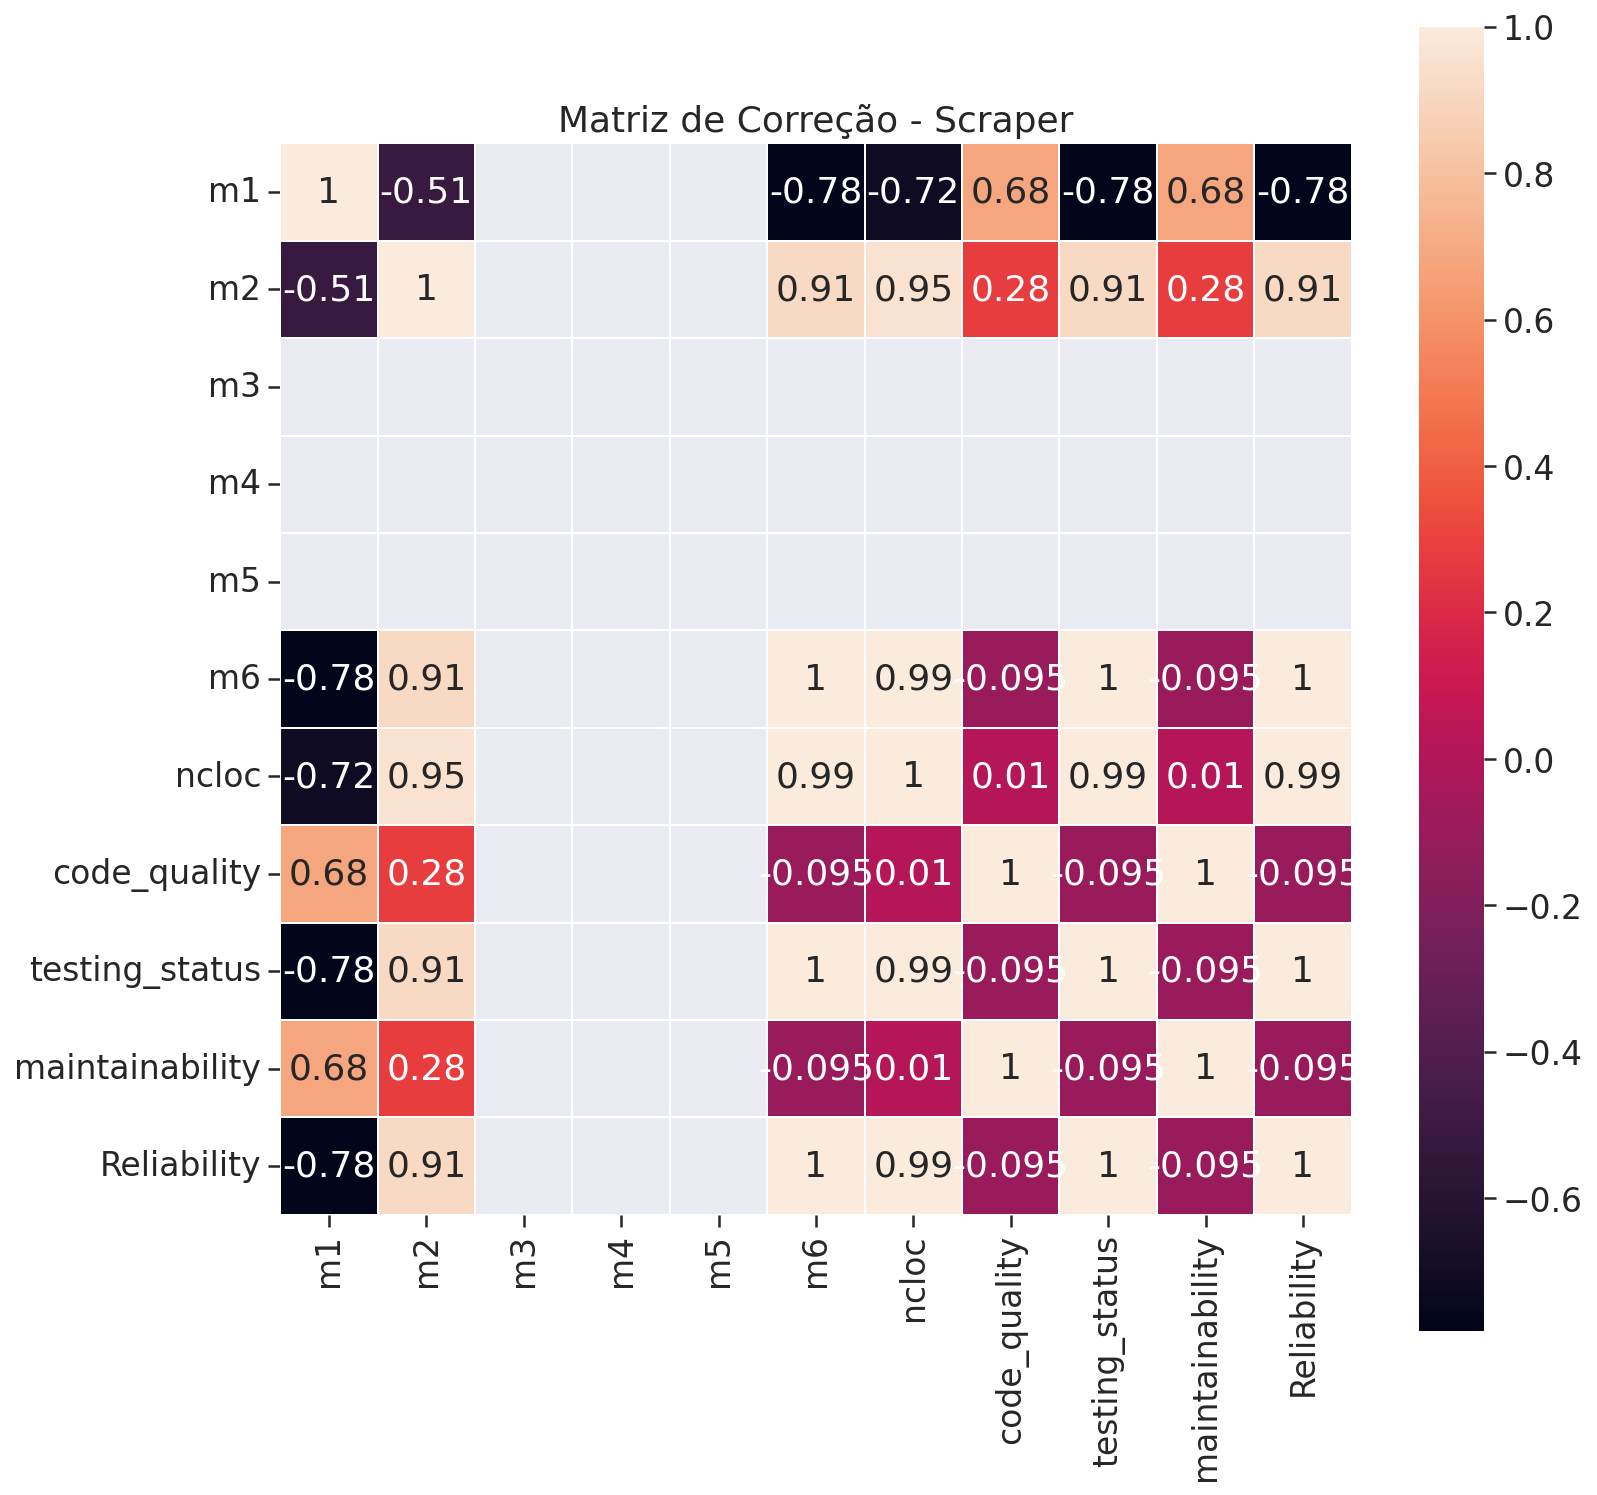

In [37]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(scraper_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Scraper')

### Document API

In [38]:
documentsapi_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.200000,0.100000,1.0,1.0,0,0.600000,DocumentsAPI,02-11-2021-23-35,359,0.429000,0.570000
1,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-07-31,336,0.434211,0.518421
2,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-12-28,341,0.434211,0.518421
3,0.238095,0.095238,1.0,1.0,0,0.619048,DocumentsAPI,07-11-2021-18-29,482,0.440000,0.583333
4,0.238095,0.095238,1.0,1.0,0,0.619048,DocumentsAPI,09-11-2021-21-53,480,0.440000,0.583333
5,0.187500,0.125000,1.0,1.0,0,0.562500,DocumentsAPI,15-09-2021-00-24,289,0.433125,0.543750
6,0.222222,0.111111,1.0,1.0,0,0.555556,DocumentsAPI,15-10-2021-20-45,266,0.440000,0.538889


In [39]:
documentsapi_metrics_df = documentsapi_metrics

documentsapi_metrics_df['maintainability'] = documentsapi_metrics_df['code_quality'] * pc1
documentsapi_metrics_df['Reliability'] = documentsapi_metrics_df['testing_status'] * pc2

documentsapi_descriptive_df = create_descriptive_with_code_and_maintain_df(documentsapi_metrics_df)

In [40]:
documentsapi_descriptive_df

,code_quality,testing_status,Maintainability,Reliability
mean,0.435792,0.550878,0.217896,0.275439
mode,0.440000,0.583333,0.220000,0.291667
25%,0.433668,0.528655,0.216834,0.264327
50%,0.434211,0.543750,0.217105,0.271875
75%,0.440000,0.576667,0.220000,0.288333
90%,0.440000,0.583333,0.220000,0.291667
99%,0.440000,0.583333,0.220000,0.291667
standart_deviation,0.004308,0.028207,0.002154,0.014103
variance,0.000019,0.000796,0.000005,0.000199
min,0.429000,0.518421,0.214500,0.259211


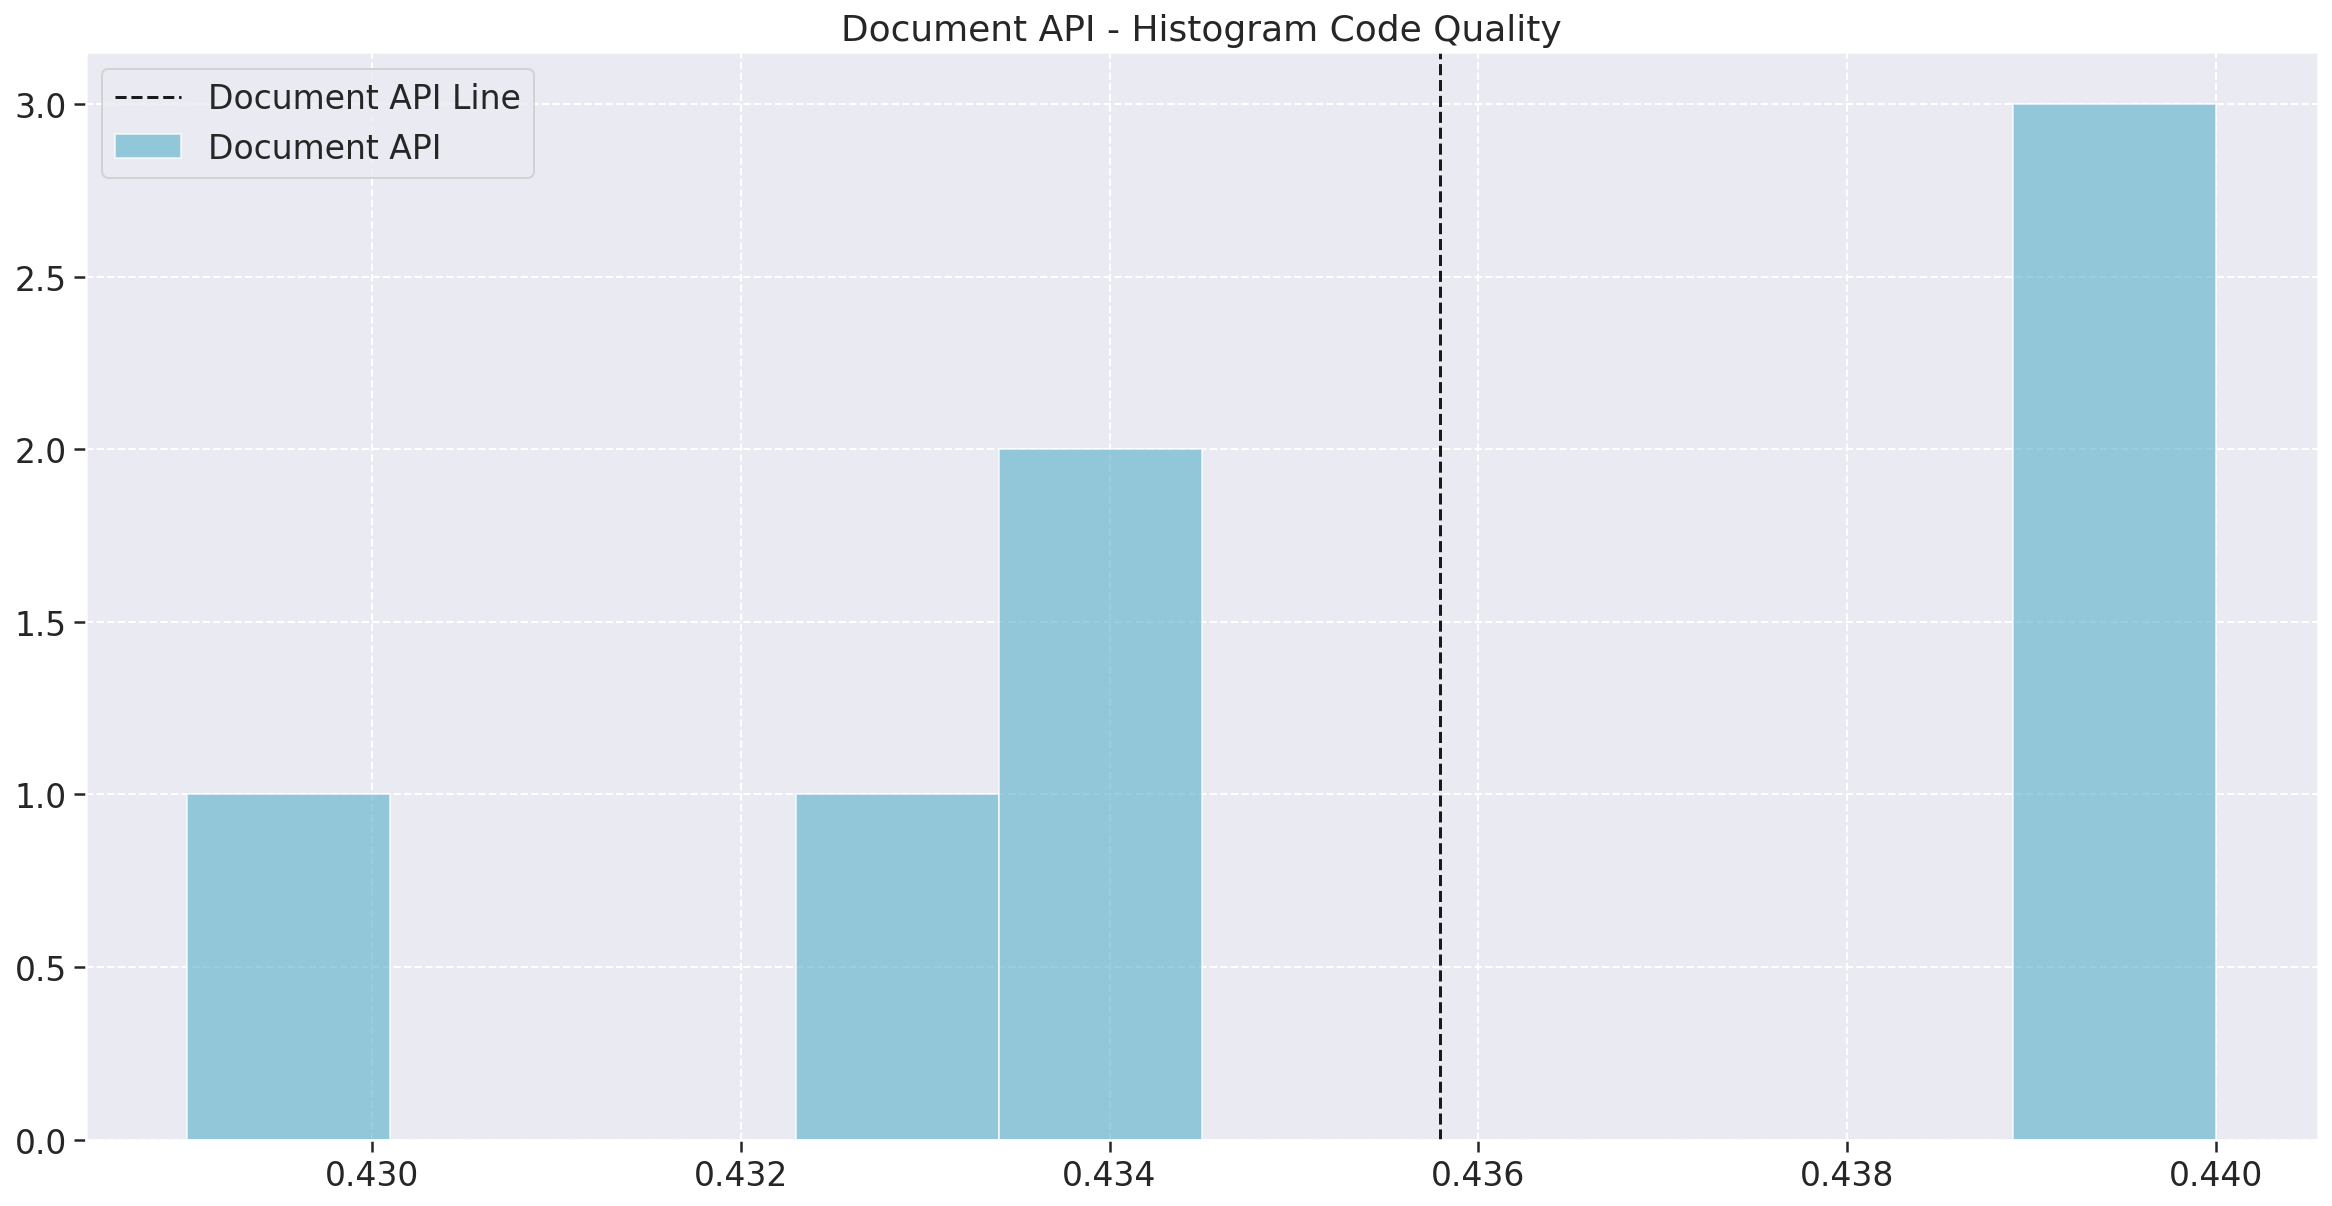

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Code Quality')
plt.hist(documentsapi_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

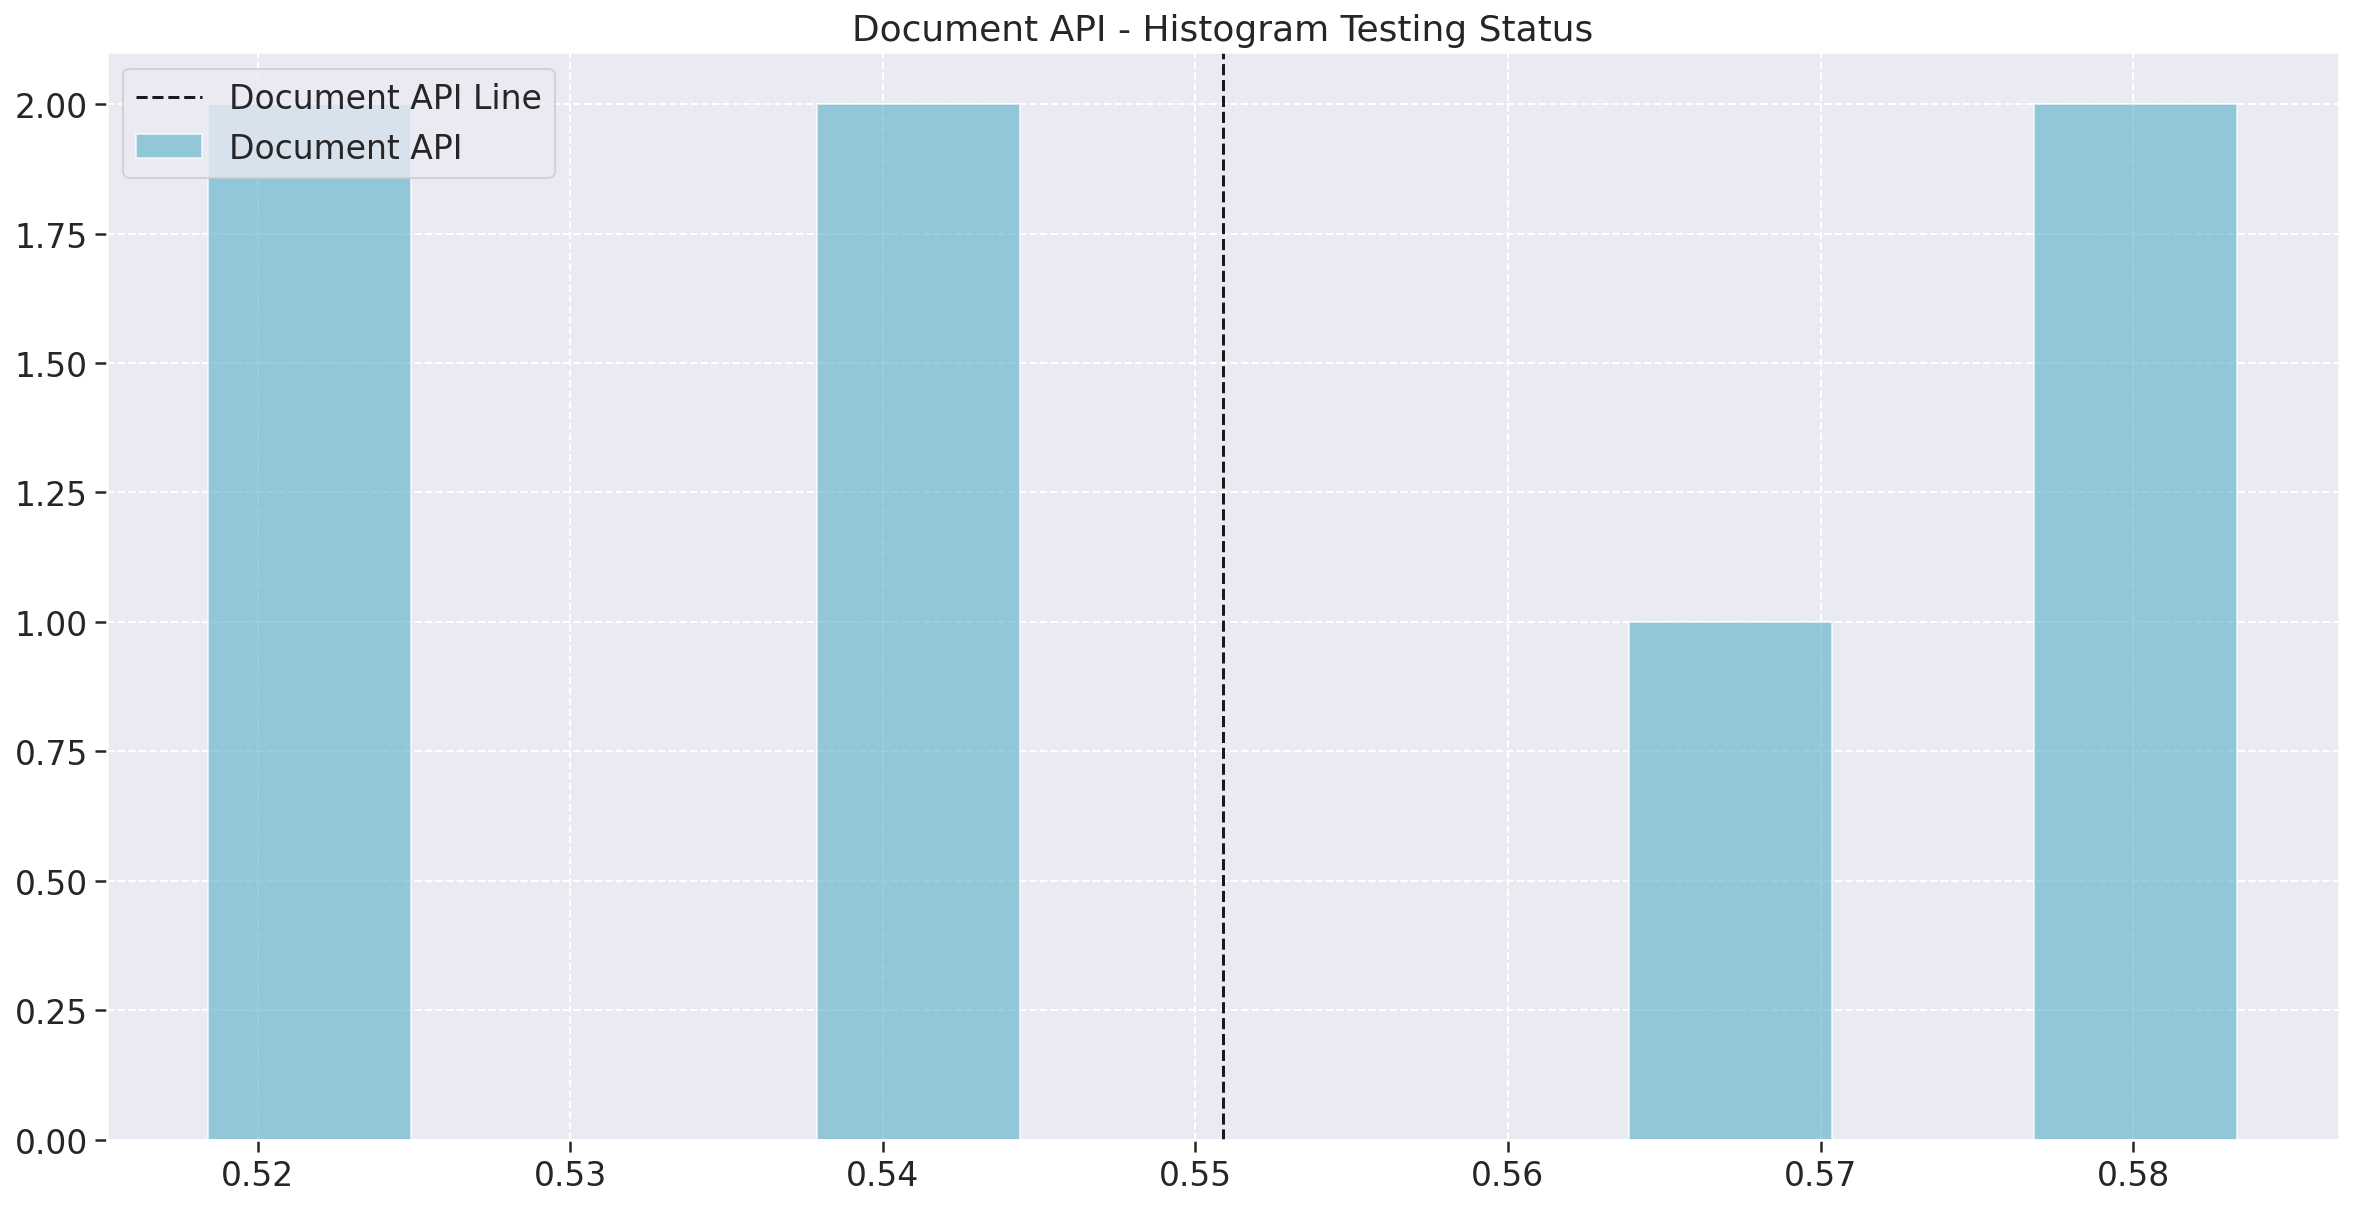

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Testing Status')
plt.hist(documentsapi_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32becade20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bec38580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32becada90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bec38ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bec43070>],
 'means': []}

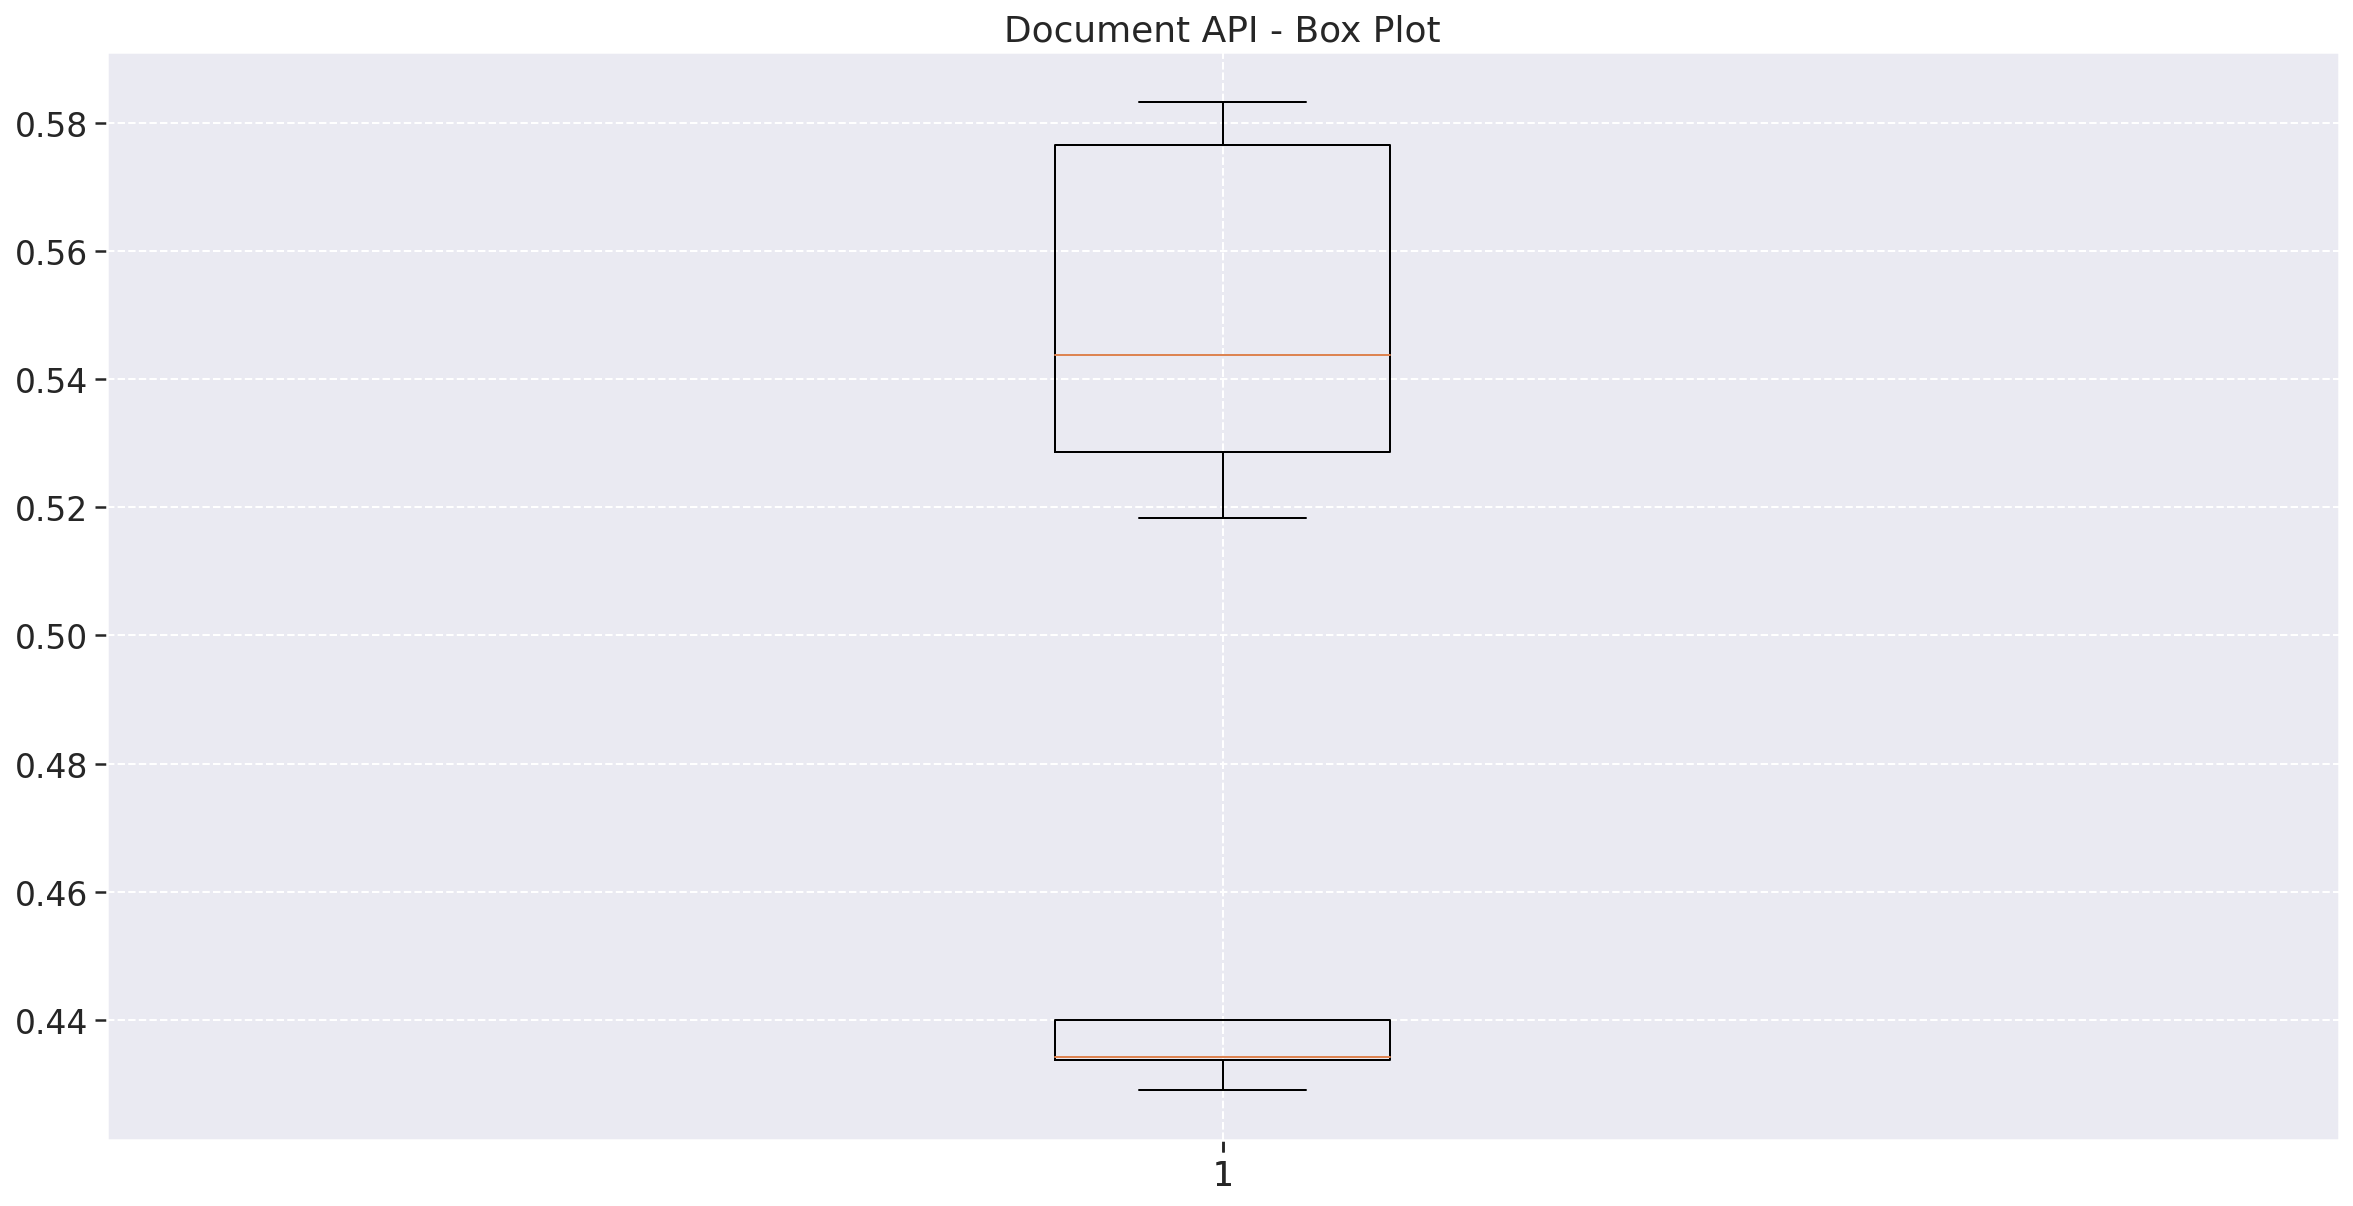

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Box Plot')
plt.boxplot(documentsapi_metrics['code_quality'])
plt.boxplot(documentsapi_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Document API')

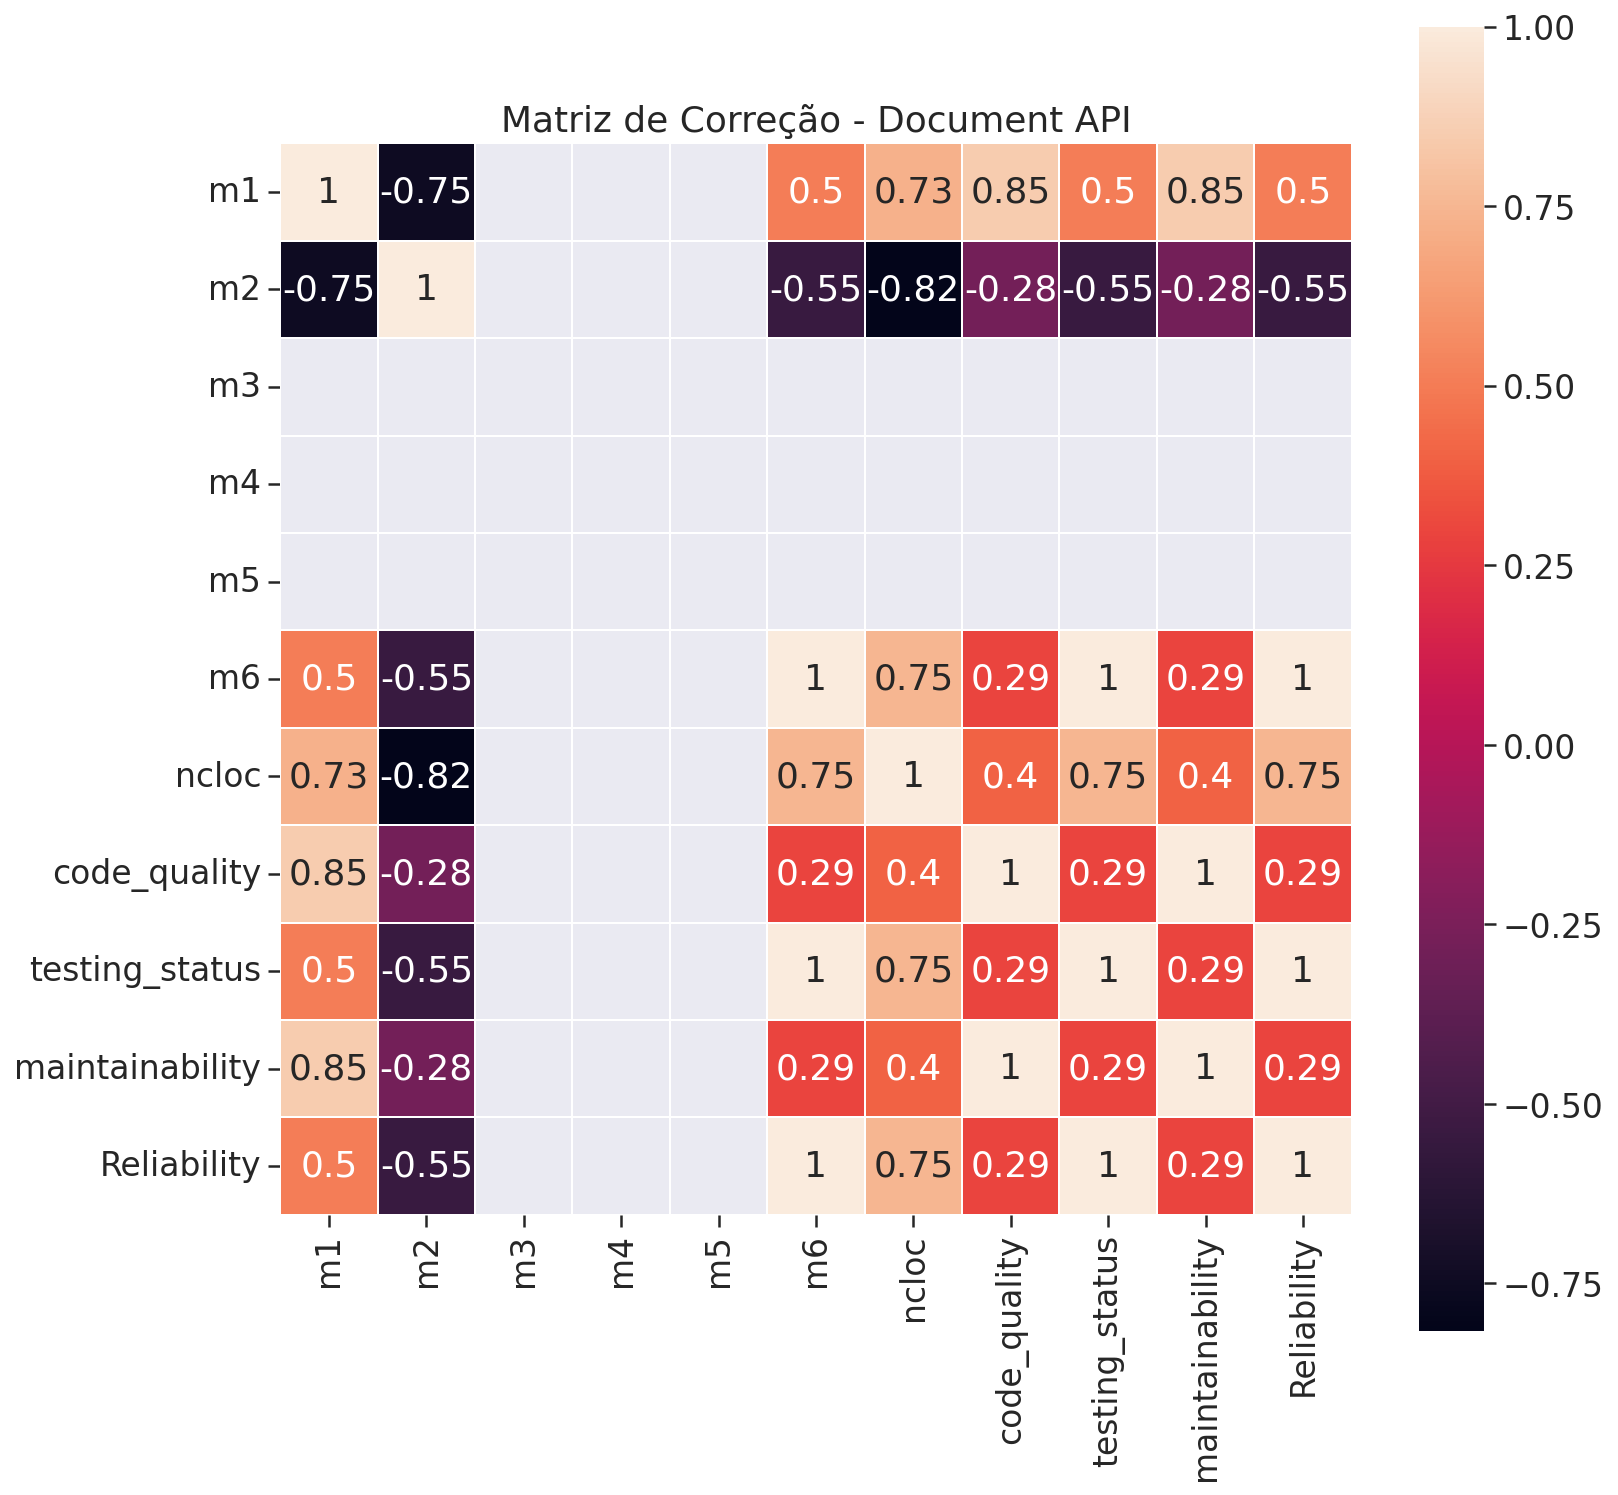

In [44]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(documentsapi_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Document API')

### ML Training

In [45]:
mltraining_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,1.0,0.0,1.0,1.0,0,0.0,MLTraining,04-11-2021-16-01,307,0.66,0.15
1,1.0,0.0,1.0,1.0,0,0.0,MLTraining,04-11-2021-17-36,307,0.66,0.15
2,1.0,0.0,1.0,1.0,0,0.0,MLTraining,10-11-2021-19-43,308,0.66,0.15
3,1.0,0.0,1.0,1.0,0,0.0,MLTraining,12-11-2021-16-10,308,0.66,0.15
4,1.0,0.0,1.0,1.0,0,0.0,MLTraining,14-09-2021-23-45,138,0.66,0.15
5,1.0,0.0,1.0,1.0,0,0.0,MLTraining,21-10-2021-15-24,138,0.66,0.15


In [46]:
mltraining_metrics_df = mltraining_metrics

mltraining_metrics_df['maintainability'] = mltraining_metrics_df['code_quality'] * pc1
mltraining_metrics_df['Reliability'] = mltraining_metrics_df['testing_status'] * pc2

mltraining_descriptive_df = create_descriptive_with_code_and_maintain_df(mltraining_metrics_df)

In [47]:
mltraining_descriptive_df

,code_quality,testing_status,Maintainability,Reliability
mean,0.66,0.15,0.33,0.075
mode,0.66,0.15,0.33,0.075
25%,0.66,0.15,0.33,0.075
50%,0.66,0.15,0.33,0.075
75%,0.66,0.15,0.33,0.075
90%,0.66,0.15,0.33,0.075
99%,0.66,0.15,0.33,0.075
standart_deviation,0.00,0.00,0.00,0.000
variance,0.00,0.00,0.00,0.000
min,0.66,0.15,0.33,0.075


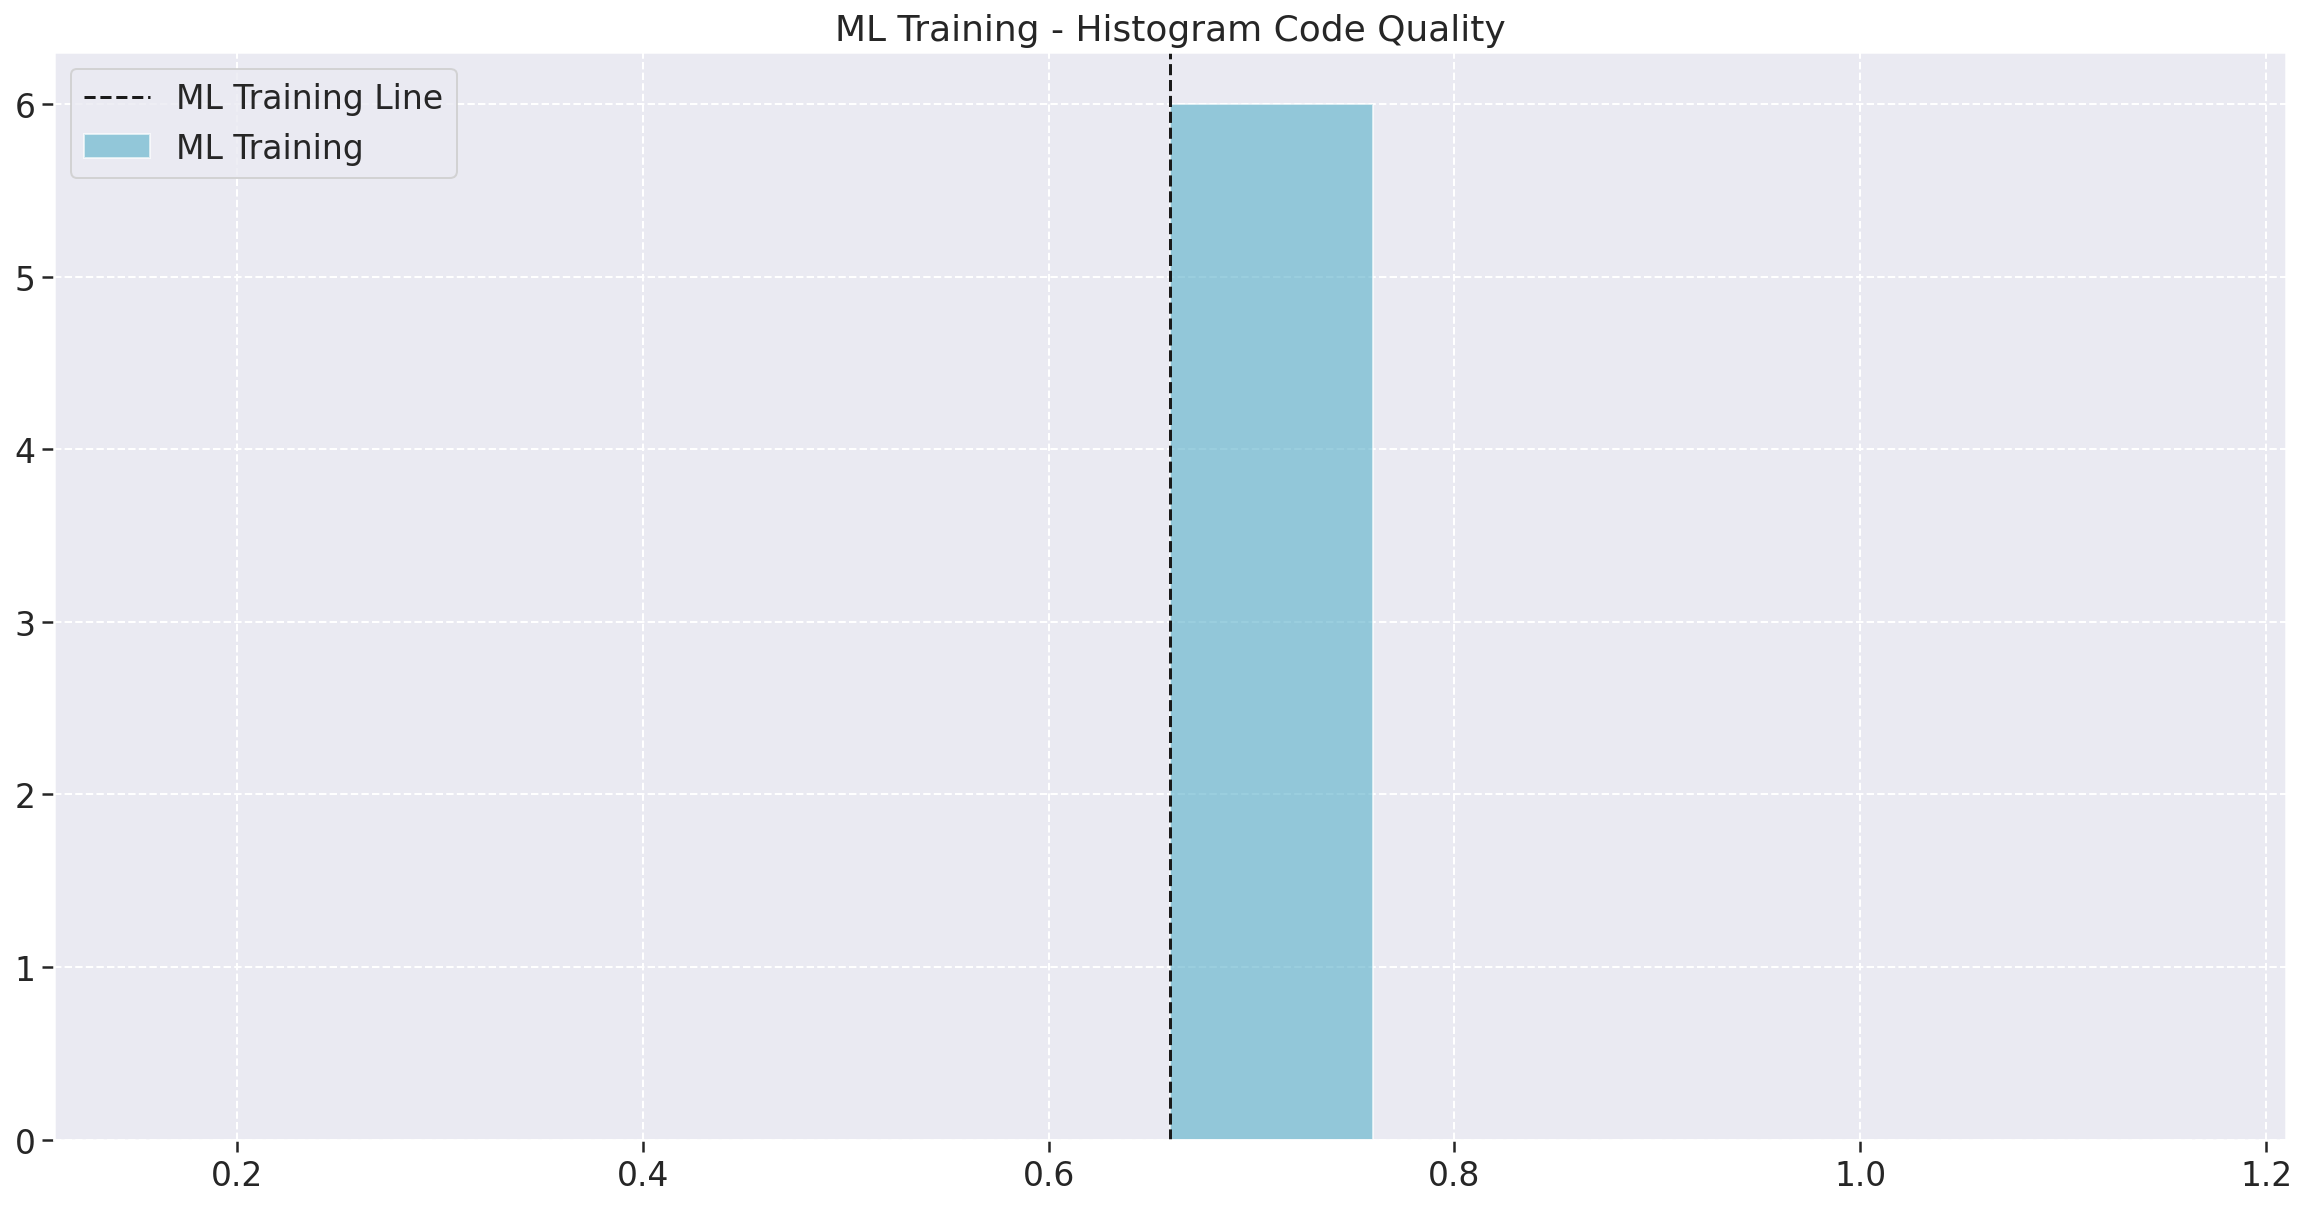

In [48]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Code Quality')
plt.hist(mltraining_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

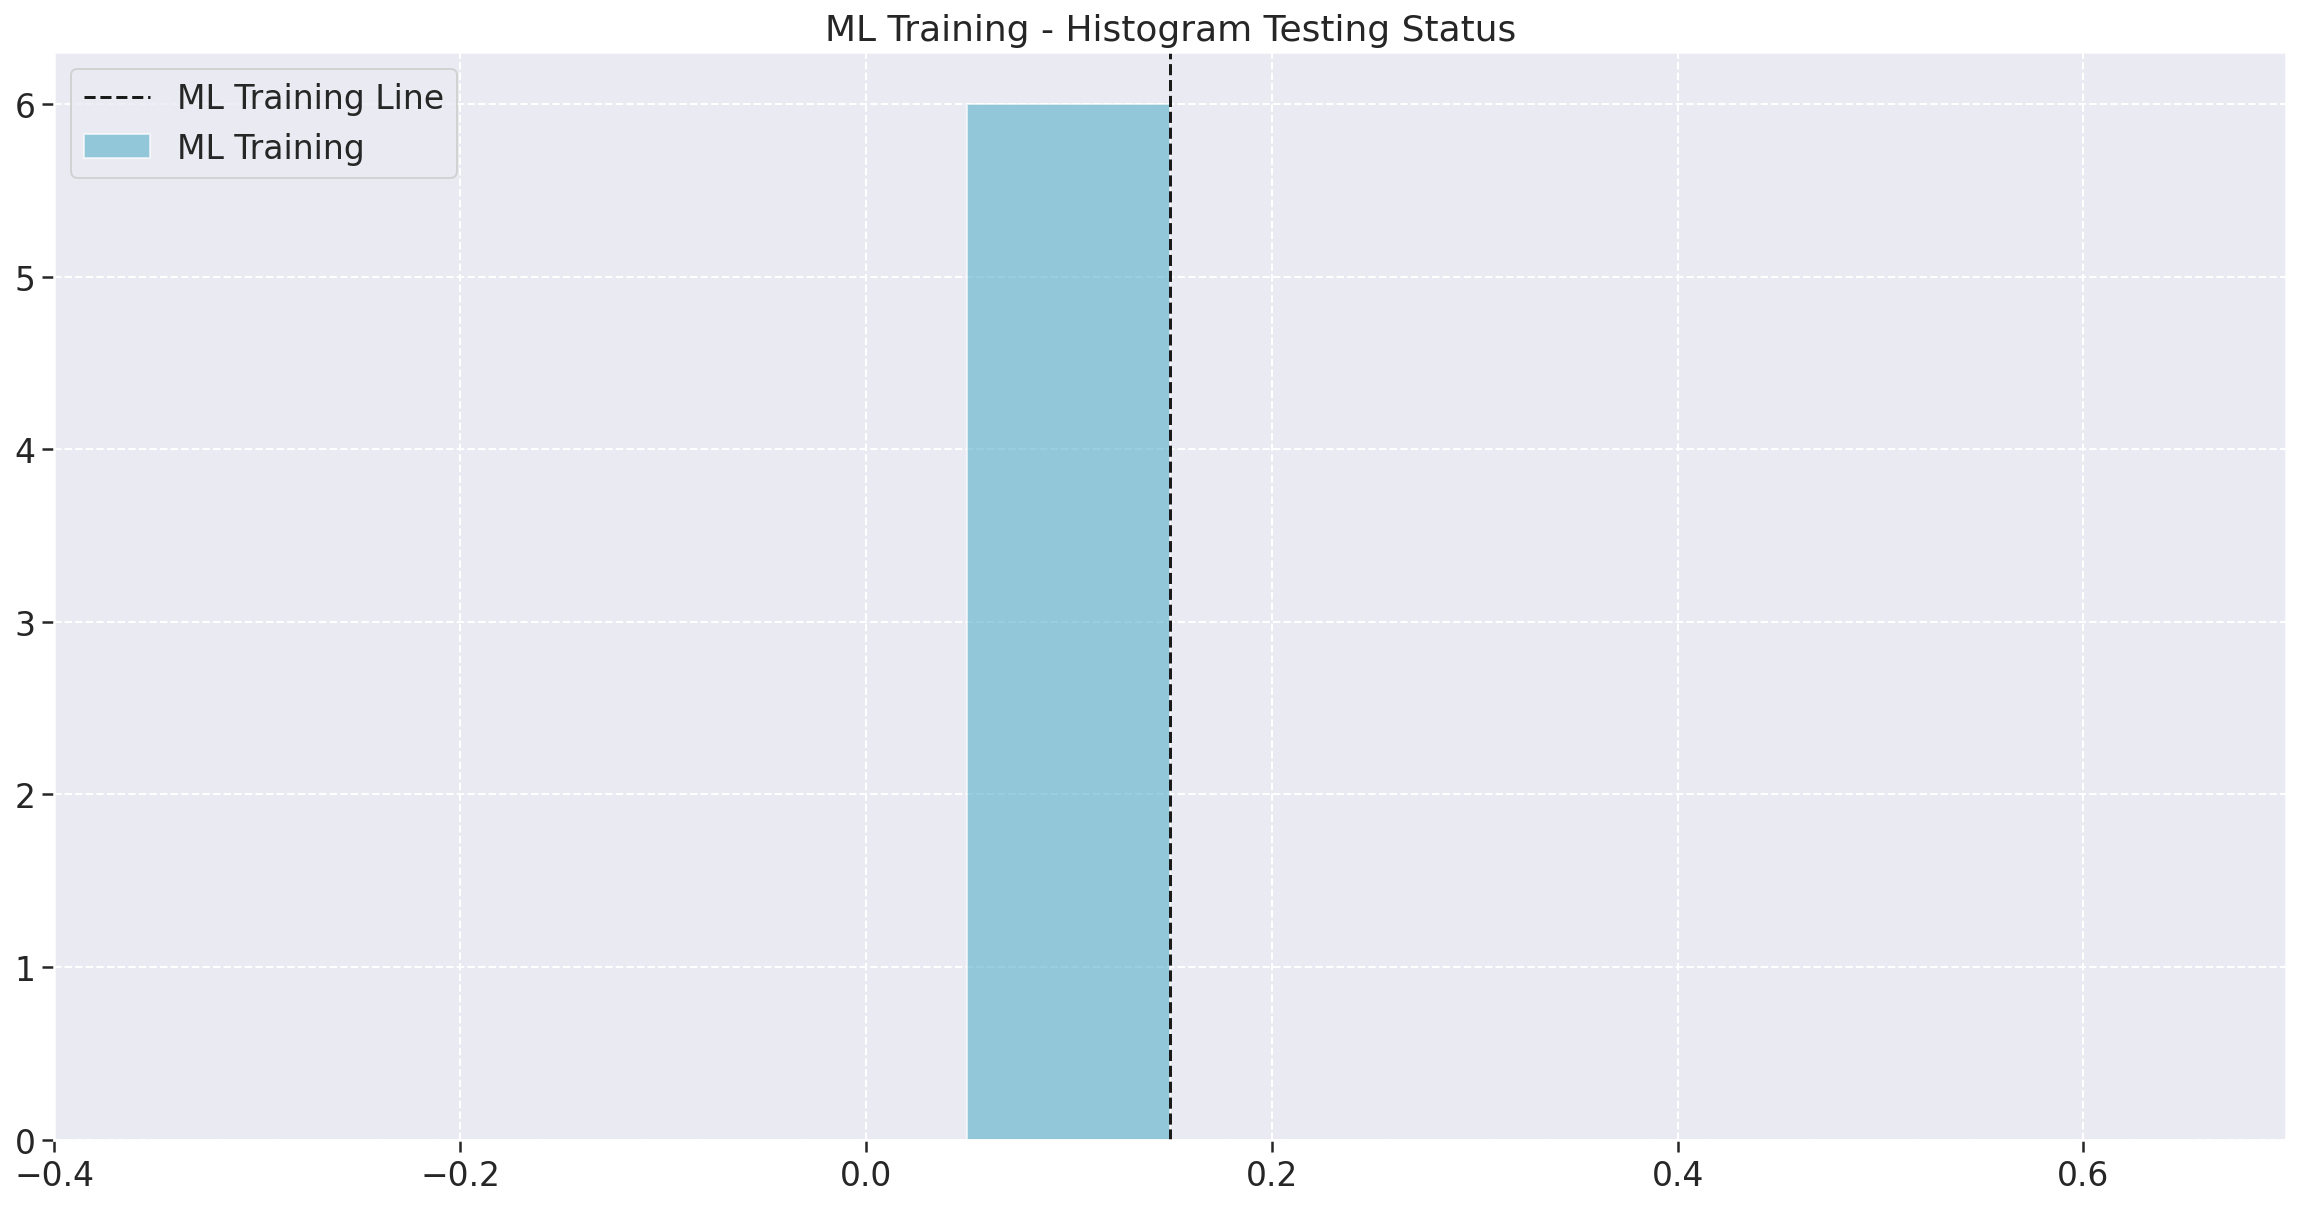

In [49]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Testing Status')
plt.hist(mltraining_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32be990a60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32be99c1c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32be9906d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32be99c8e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32be99cc70>],
 'means': []}

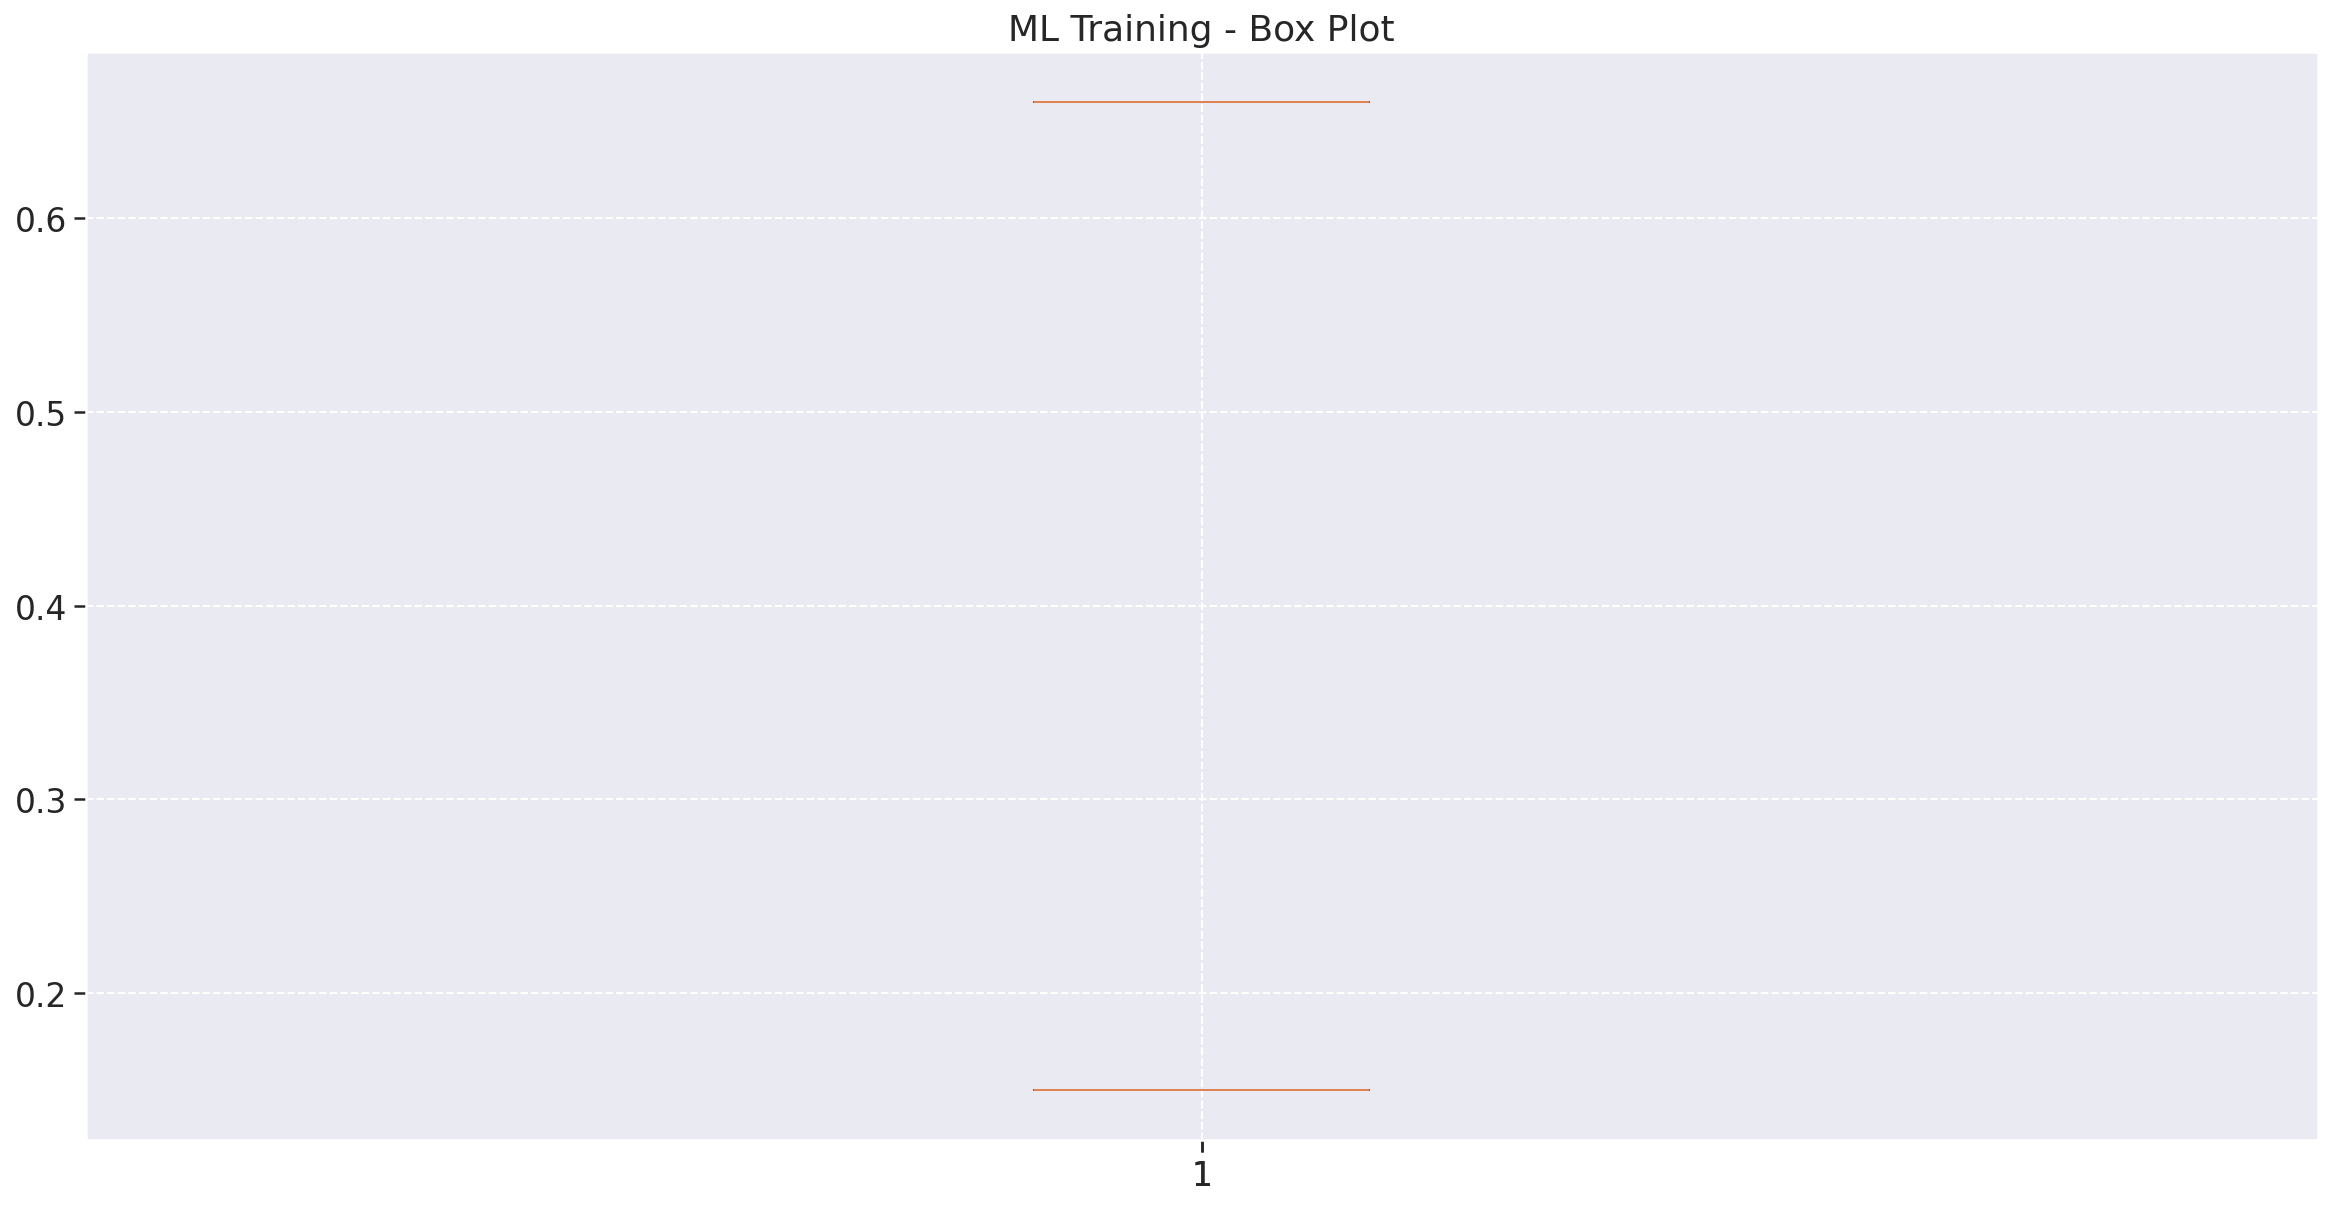

In [50]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Box Plot')
plt.boxplot(mltraining_metrics['code_quality'])
plt.boxplot(mltraining_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - ML Training')

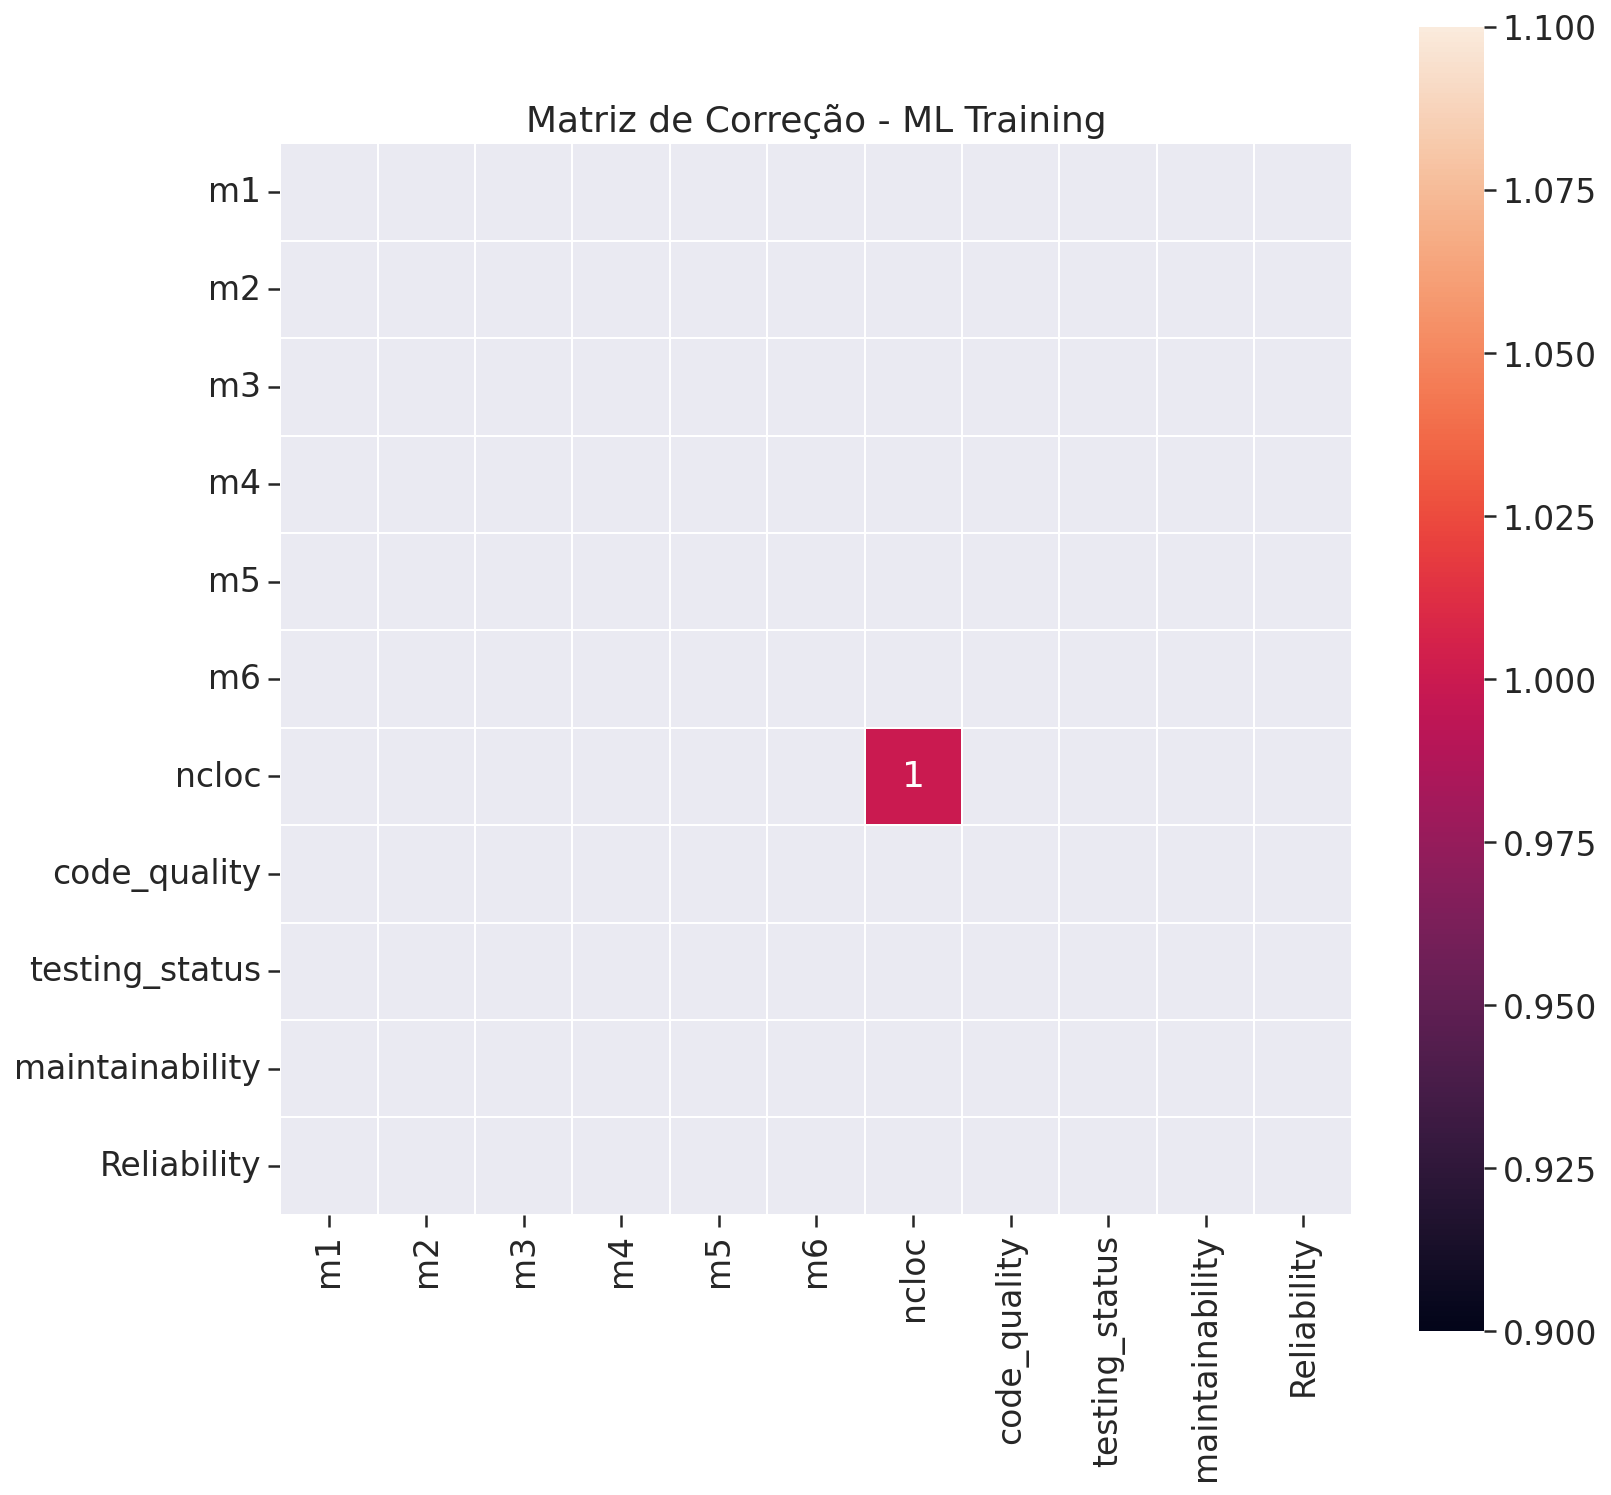

In [51]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(mltraining_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - ML Training')

### Front End

In [52]:
frontend_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.500000,0.052632,0.921053,1.0,0,0.578947,Frontend,02-11-2021-23-30,2460,0.486316,0.555263
1,0.500000,0.052632,0.921053,1.0,0,0.578947,Frontend,03-11-2021-17-44,2460,0.486316,0.555263
2,0.500000,0.200000,1.000000,1.0,0,0.500000,Frontend,07-10-2021-11-50,125,0.561000,0.500000
3,0.553571,0.053571,0.964286,1.0,0,0.500000,Frontend,07-11-2021-18-38,4244,0.518571,0.500000
4,0.553571,0.053571,0.964286,1.0,0,0.500000,Frontend,09-11-2021-16-43,4274,0.518571,0.500000
5,0.553571,0.053571,0.964286,1.0,0,0.500000,Frontend,10-11-2021-00-51,4274,0.518571,0.500000
6,0.600000,0.200000,1.000000,1.0,0,0.200000,Frontend,15-09-2021-00-47,58,0.594000,0.290000
7,0.481481,0.111111,0.925926,1.0,0,0.629630,Frontend,27-10-2021-17-37,1334,0.501111,0.590741


In [53]:
frontend_metrics_df = frontend_metrics

frontend_metrics_df['maintainability'] = frontend_metrics_df['code_quality'] * pc1
frontend_metrics_df['Reliability'] = frontend_metrics_df['testing_status'] * pc2

frontend_descriptive_df = create_descriptive_with_code_and_maintain_df(frontend_metrics_df)

In [54]:
frontend_descriptive_df

,code_quality,testing_status,Maintainability,Reliability
mean,0.523057,0.498908,0.261529,0.249454
mode,0.518571,0.500000,0.259286,0.250000
25%,0.497412,0.500000,0.248706,0.250000
50%,0.518571,0.500000,0.259286,0.250000
75%,0.529179,0.555263,0.264589,0.277632
90%,0.570900,0.565906,0.285450,0.282953
99%,0.591690,0.588257,0.295845,0.294129
standart_deviation,0.037253,0.091365,0.018626,0.045682
variance,0.001388,0.008347,0.000347,0.002087
min,0.486316,0.290000,0.243158,0.145000


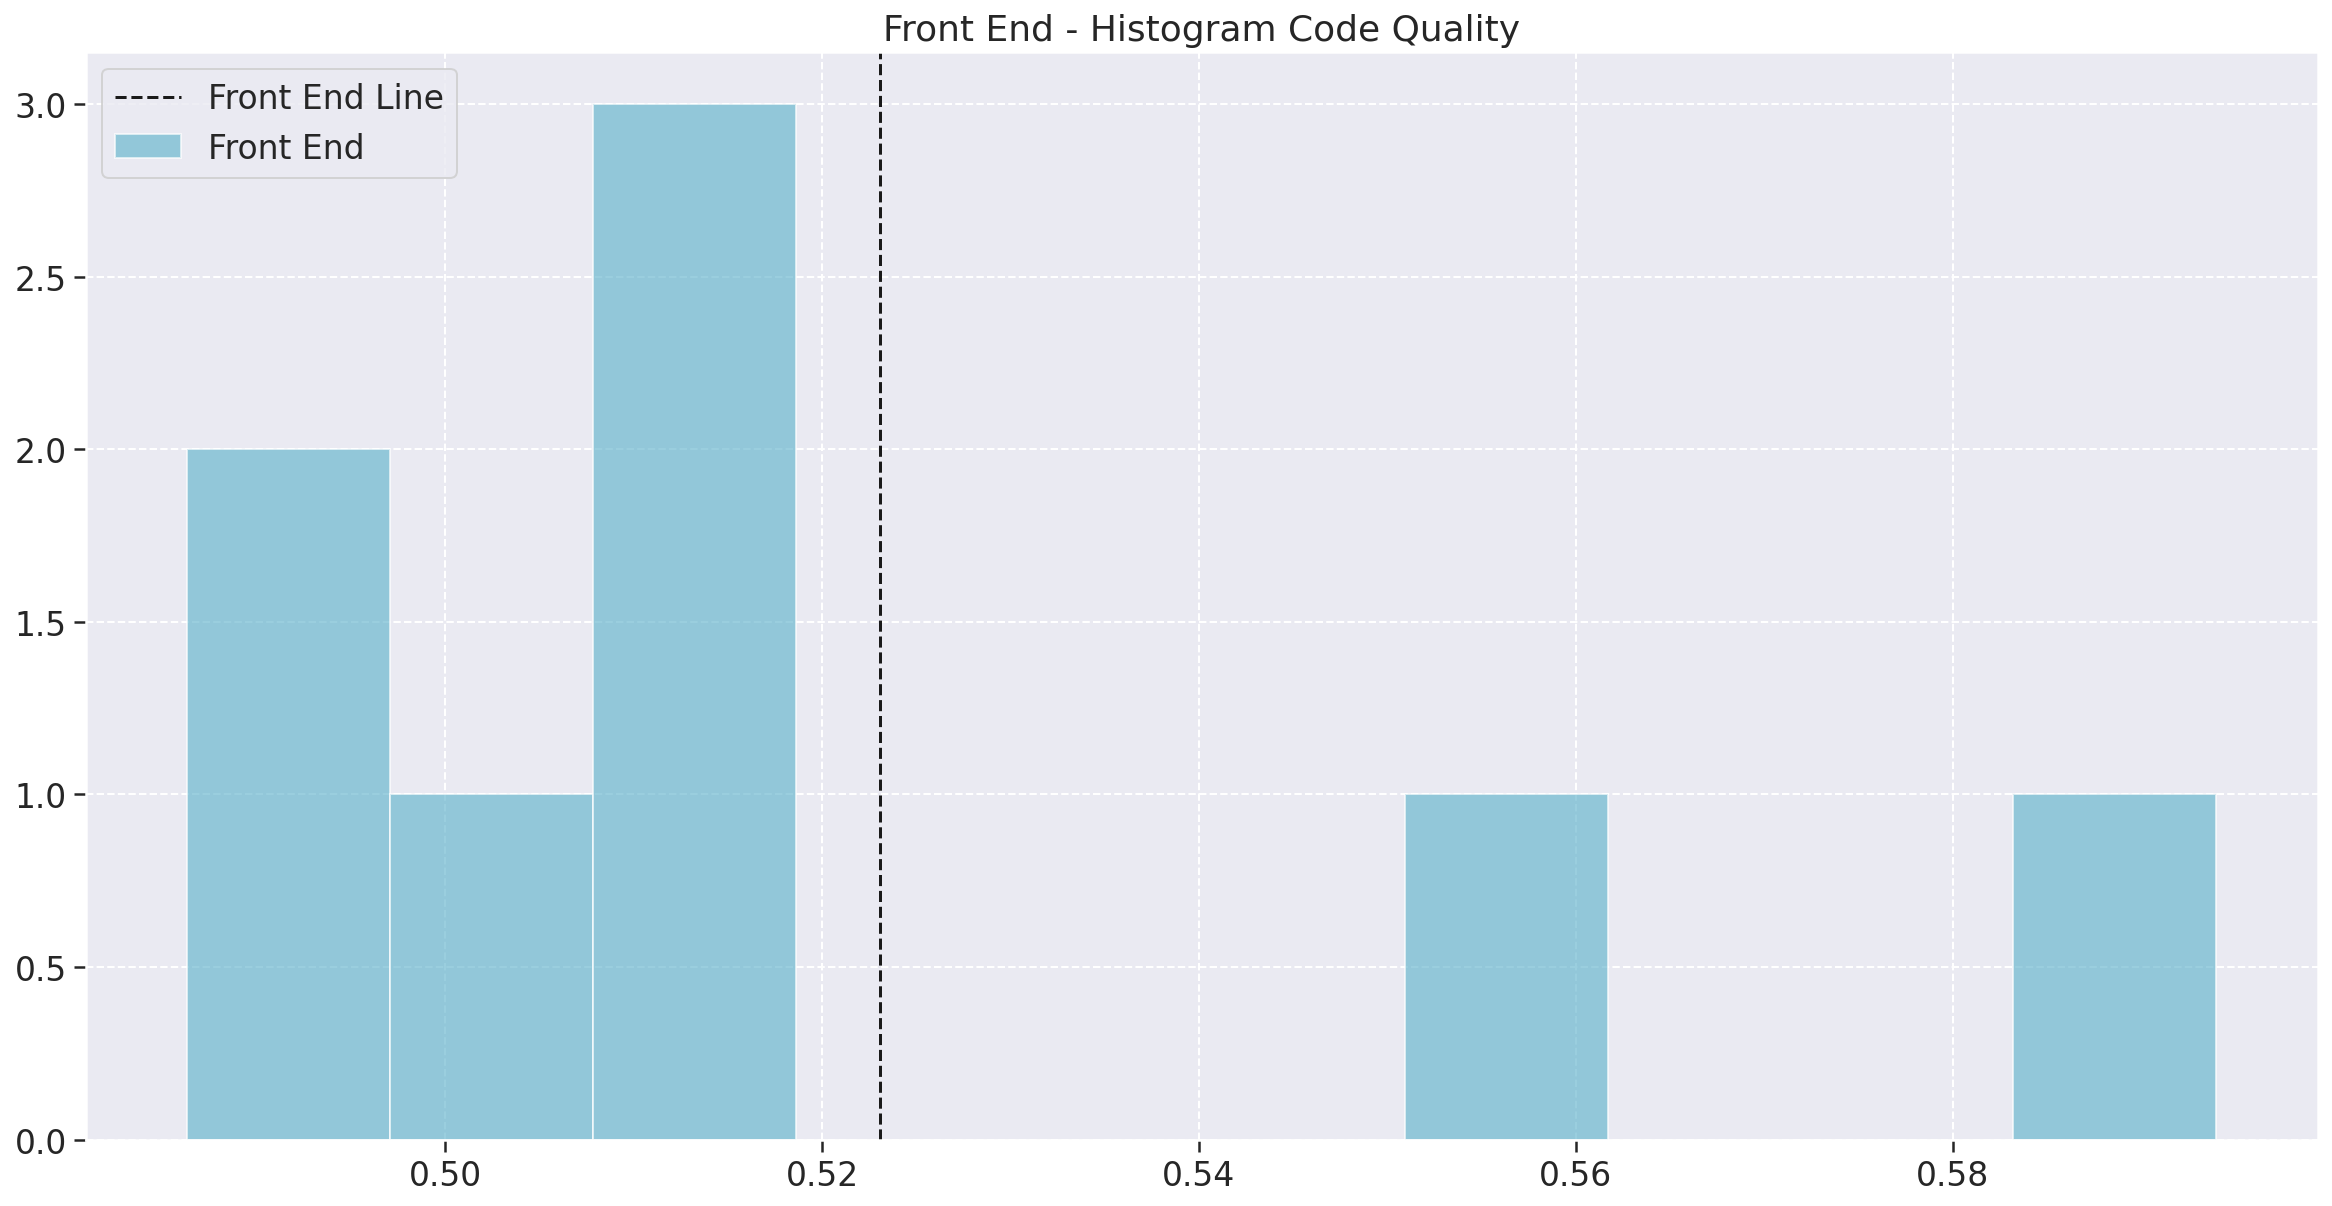

In [55]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Code Quality')
plt.hist(frontend_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

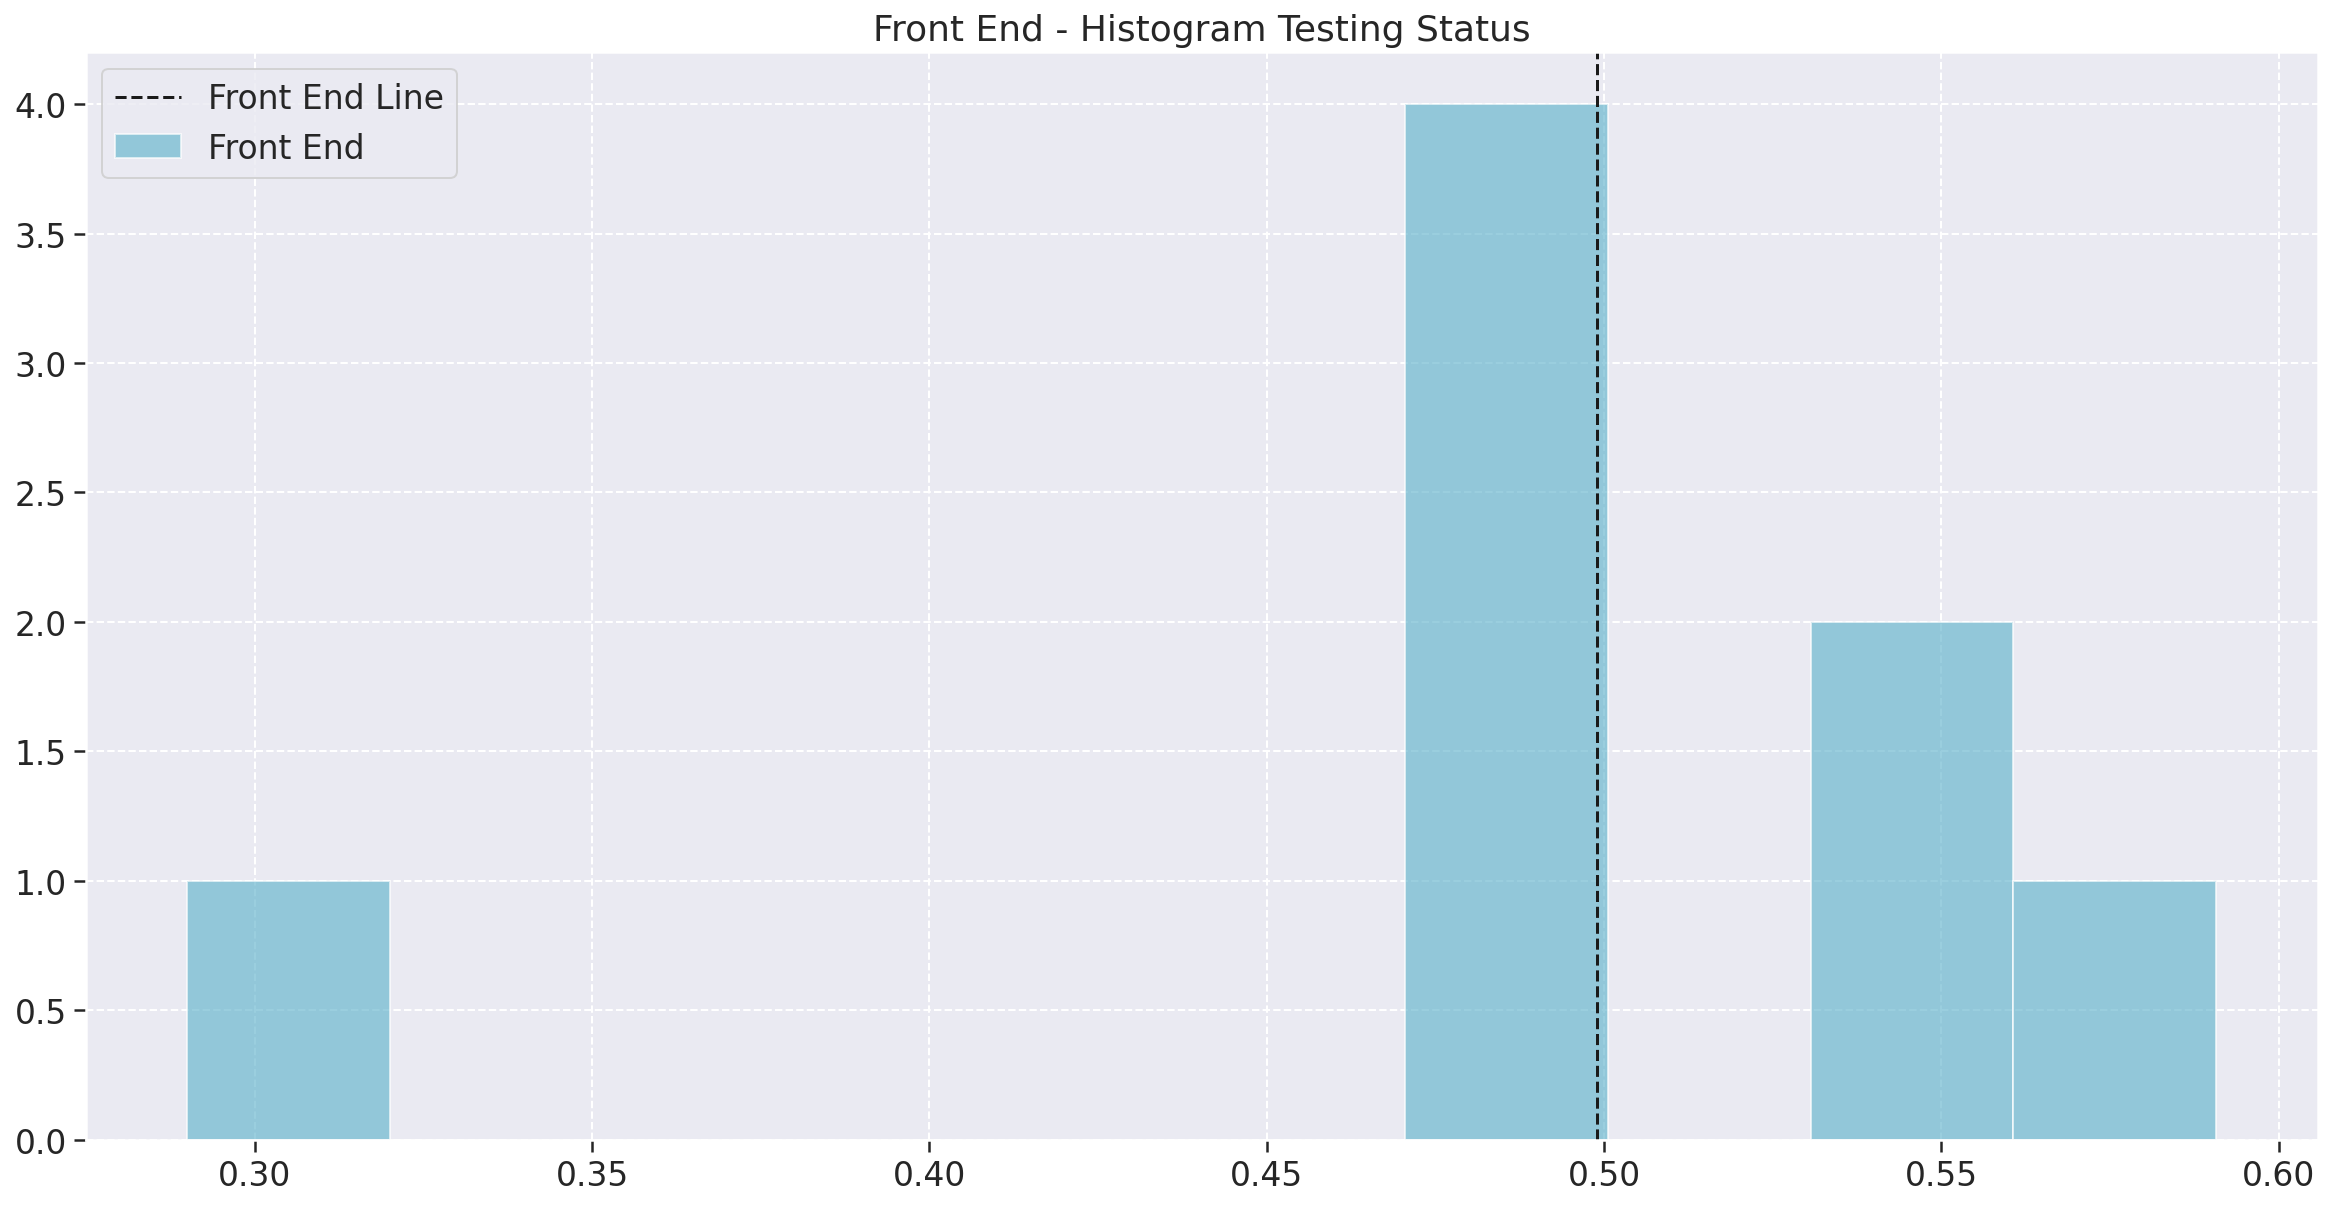

In [56]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Testing Status')
plt.hist(frontend_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bcc7dfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bcc89730>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bcc7dc40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bcc89e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bcc92220>],
 'means': []}

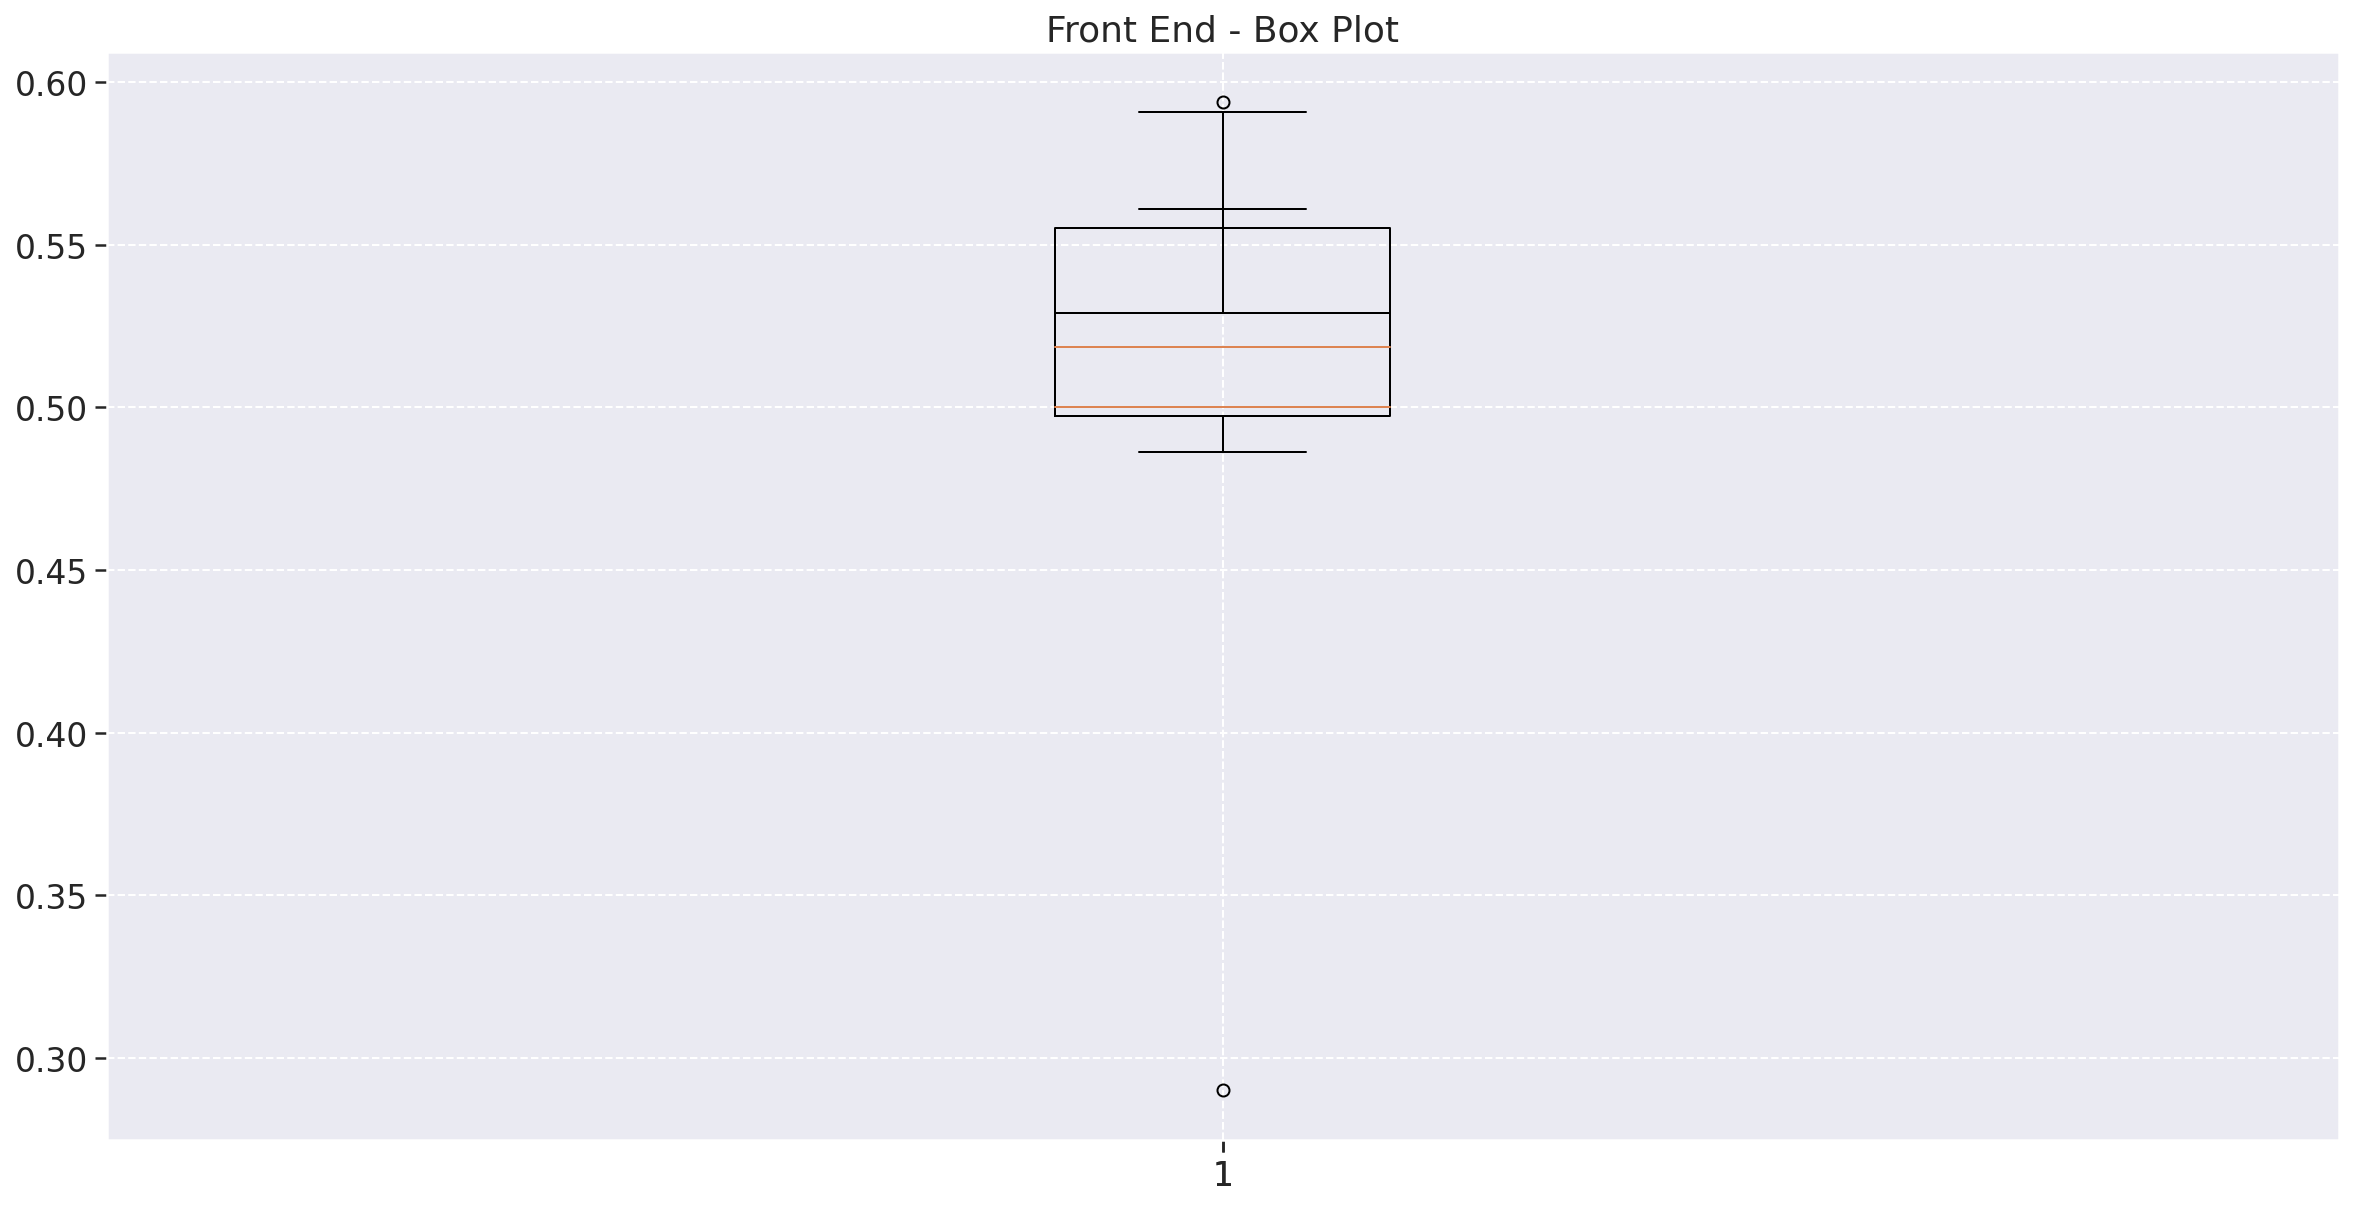

In [57]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Box Plot')
plt.boxplot(frontend_metrics['code_quality'])
plt.boxplot(frontend_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Front End')

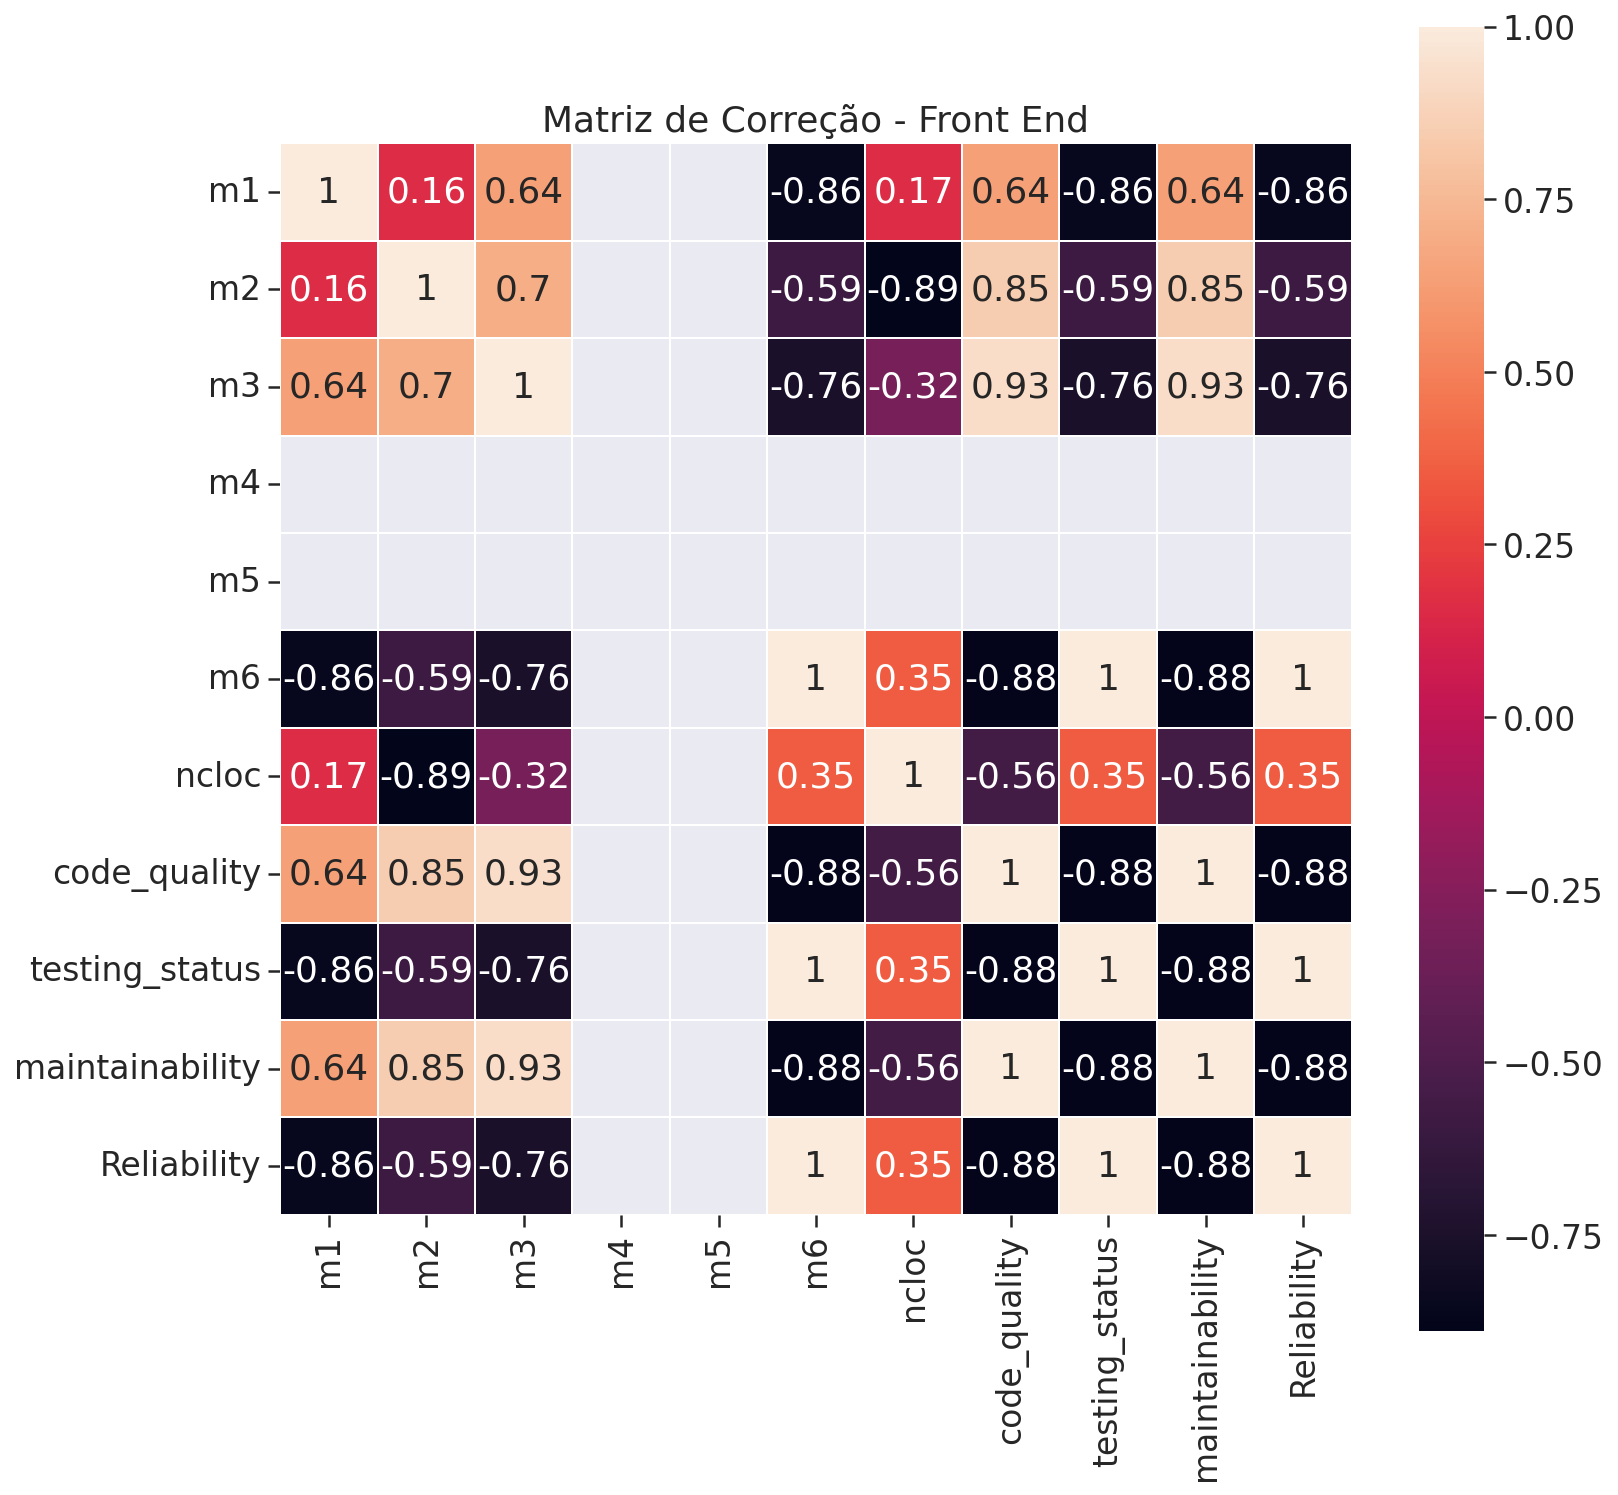

In [58]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(frontend_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Front End')

### Maintainability and Reliabity

In [59]:
metrics_df = pd.concat([scraper_metrics, documentsapi_metrics, mltraining_metrics, frontend_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [60]:
descriptive_df = create_descriptive_df(metrics_df)

In [61]:
descriptive_df

,Maintainability,Reliability
mean,0.265774,0.208012
mode,0.330000,0.075000
25%,0.231579,0.090909
50%,0.259286,0.250000
75%,0.291000,0.277632
90%,0.330000,0.287667
99%,0.330000,0.294407
standart_deviation,0.041221,0.089877
variance,0.001699,0.008078
min,0.214500,0.075000


Text(0.5, 1.0, 'Matriz de Correção - Maintainability e Reliability')

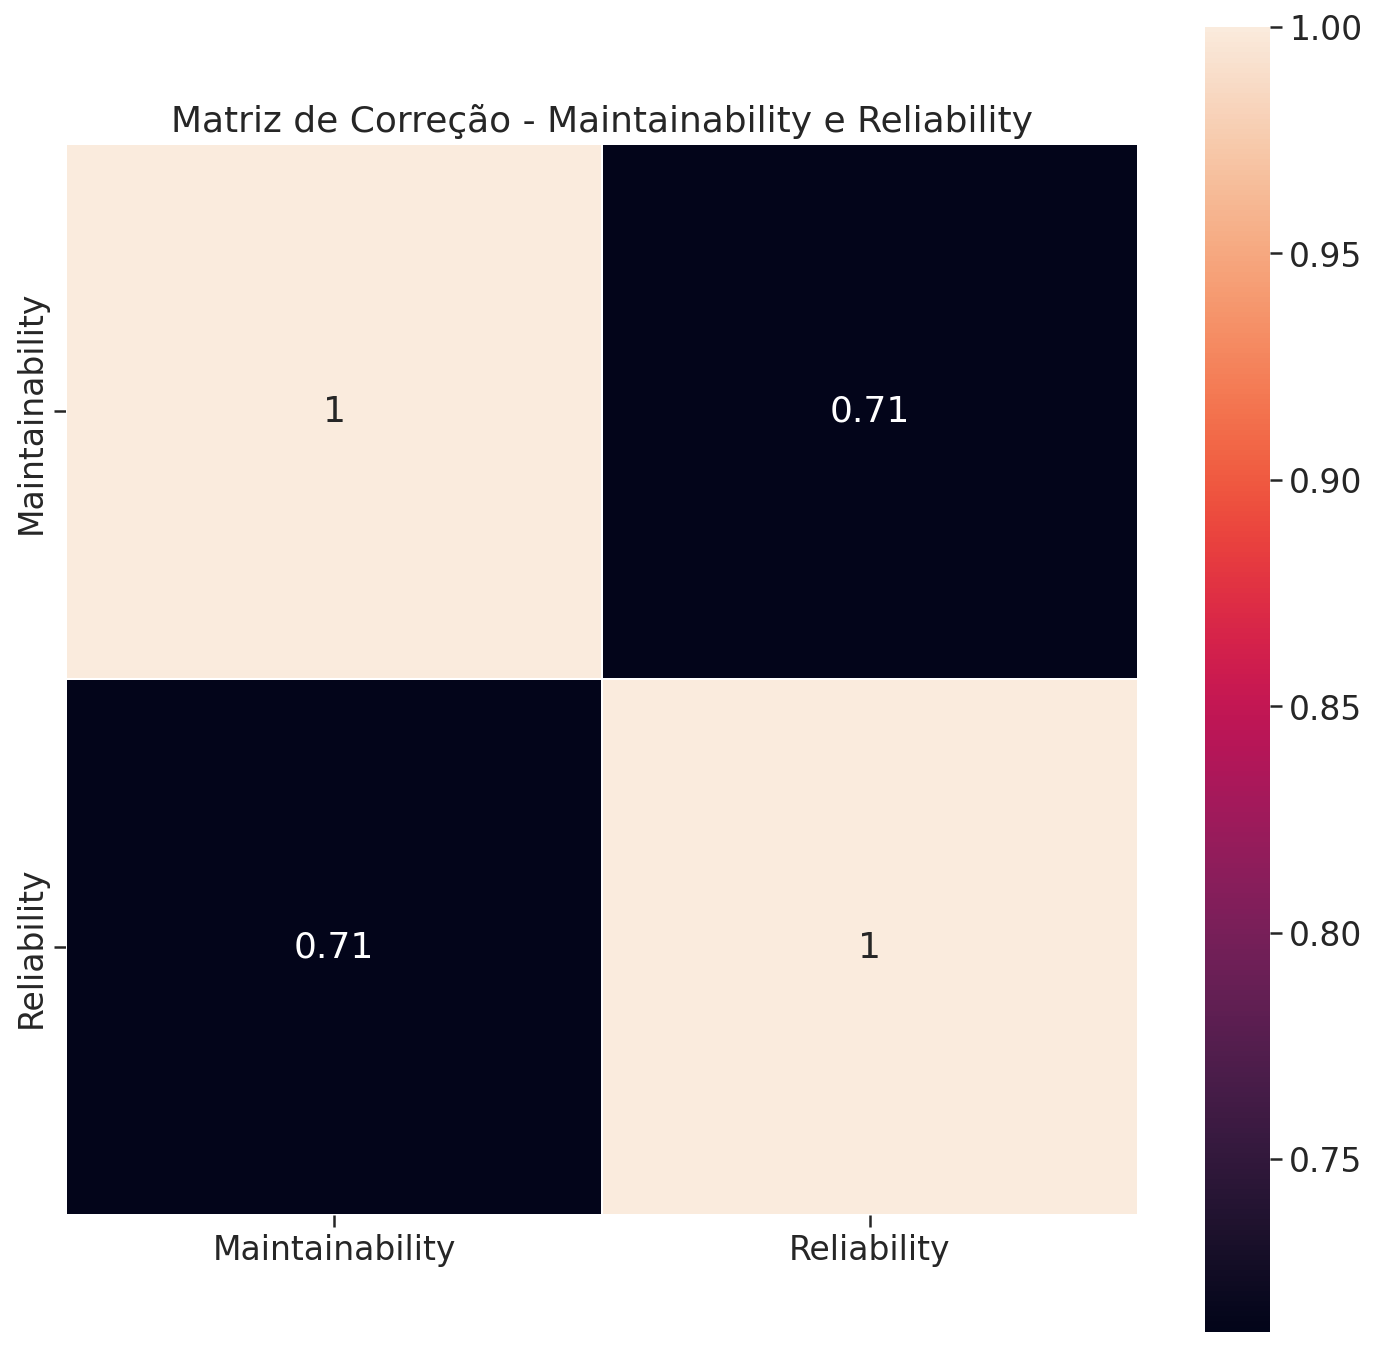

In [62]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(descriptive_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Maintainability e Reliability')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bca10c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bca1e370>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bca10880>,
 'medians': [<matplotlib.lines.Line2D at 0x7f32bca1ea90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bca1ee20>,
 'means': []}

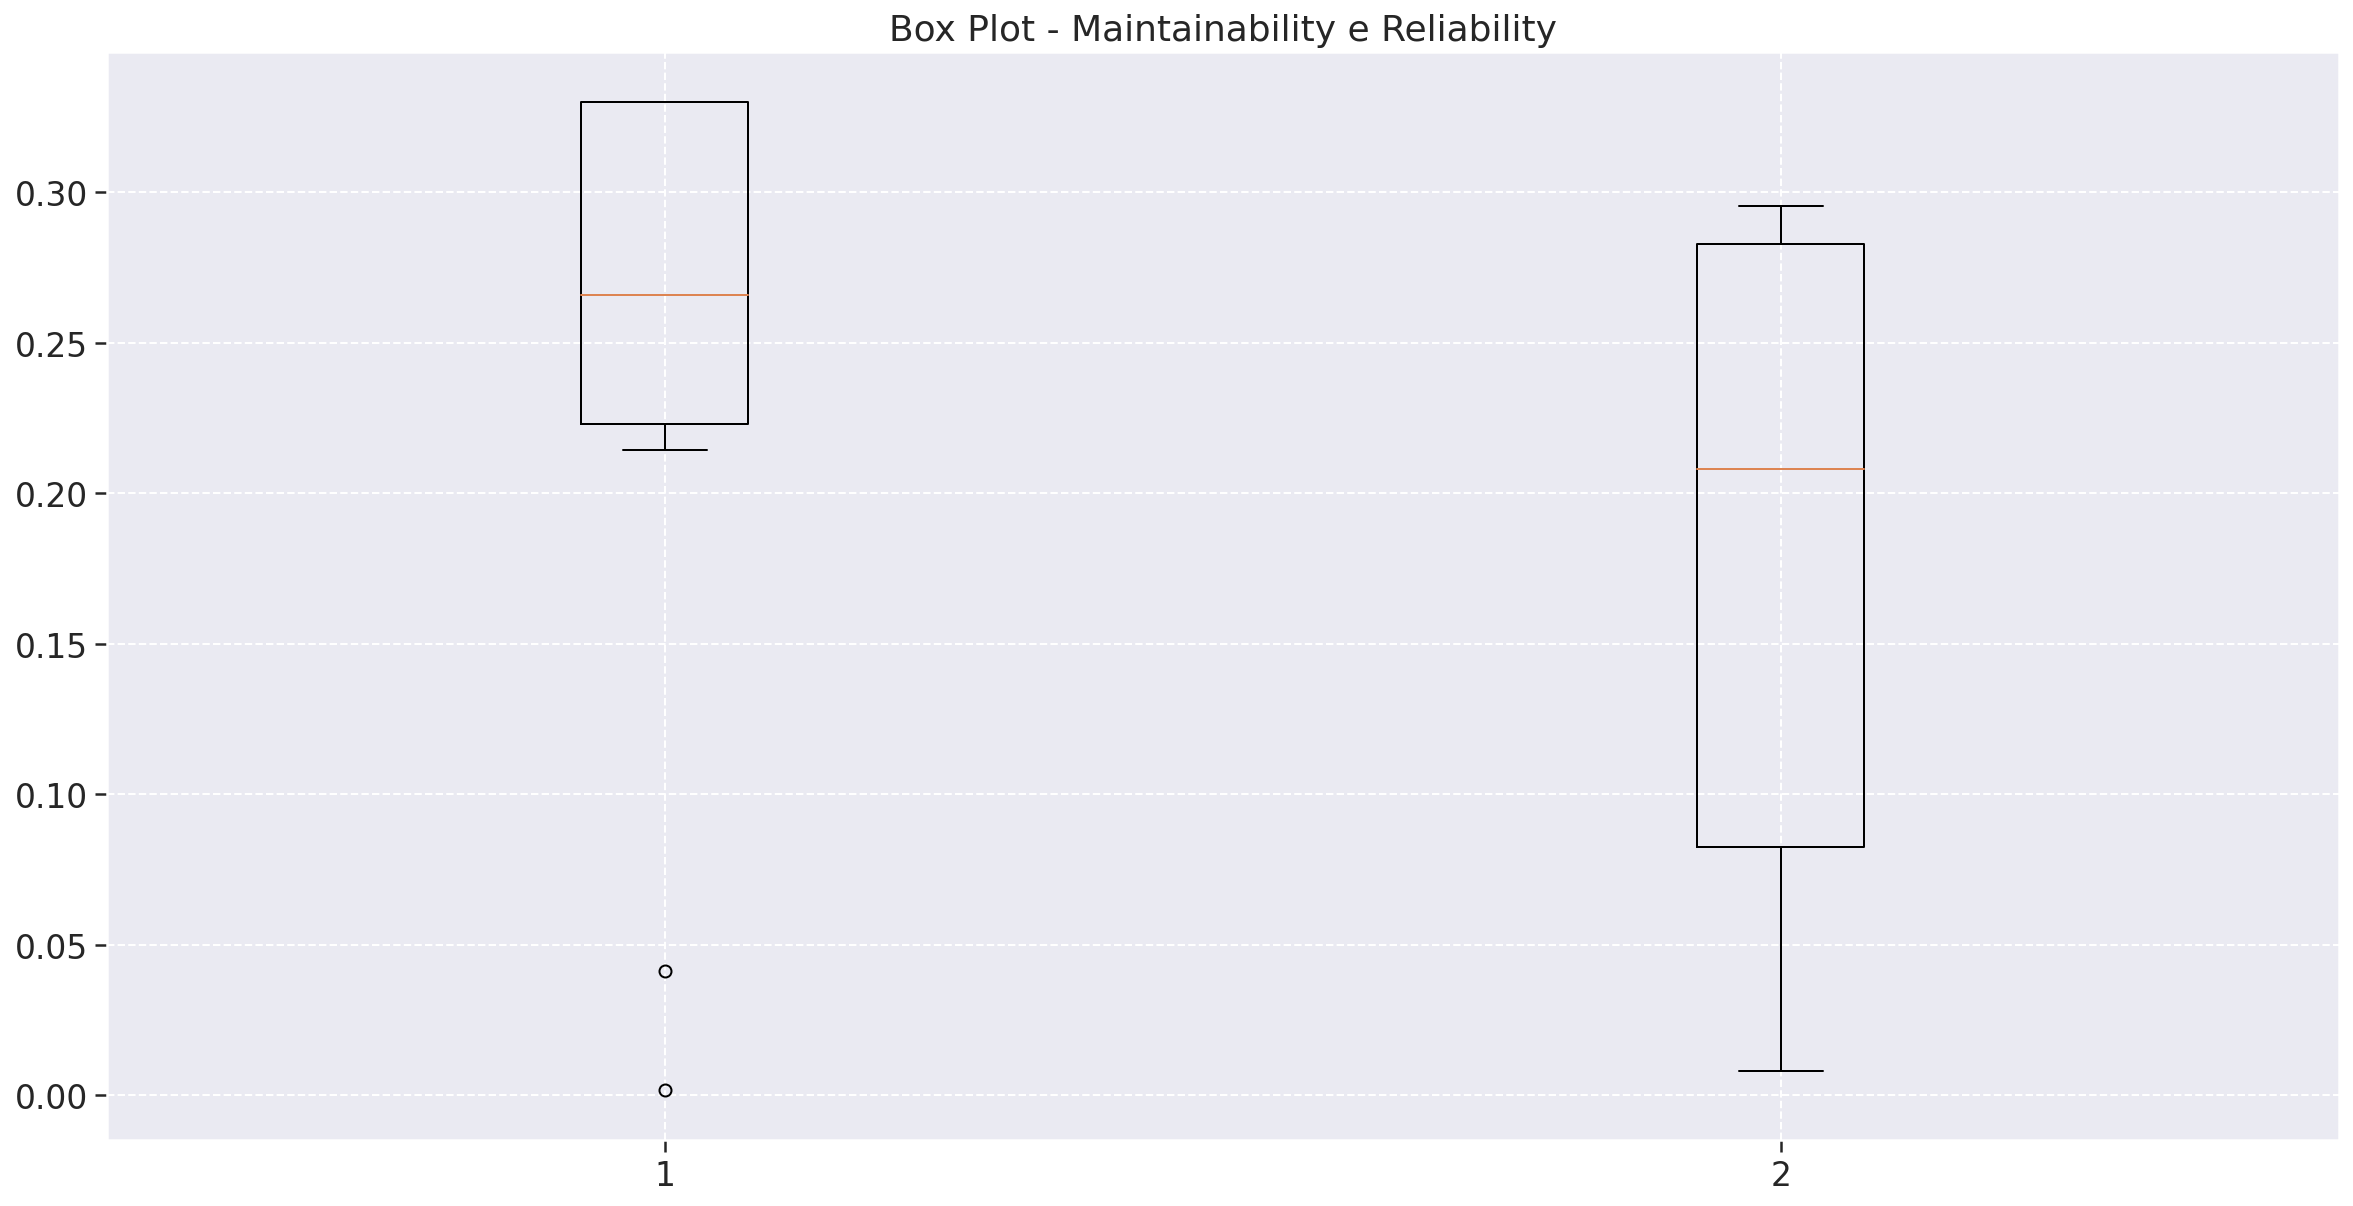

In [63]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability e Reliability')
plt.boxplot(descriptive_df)

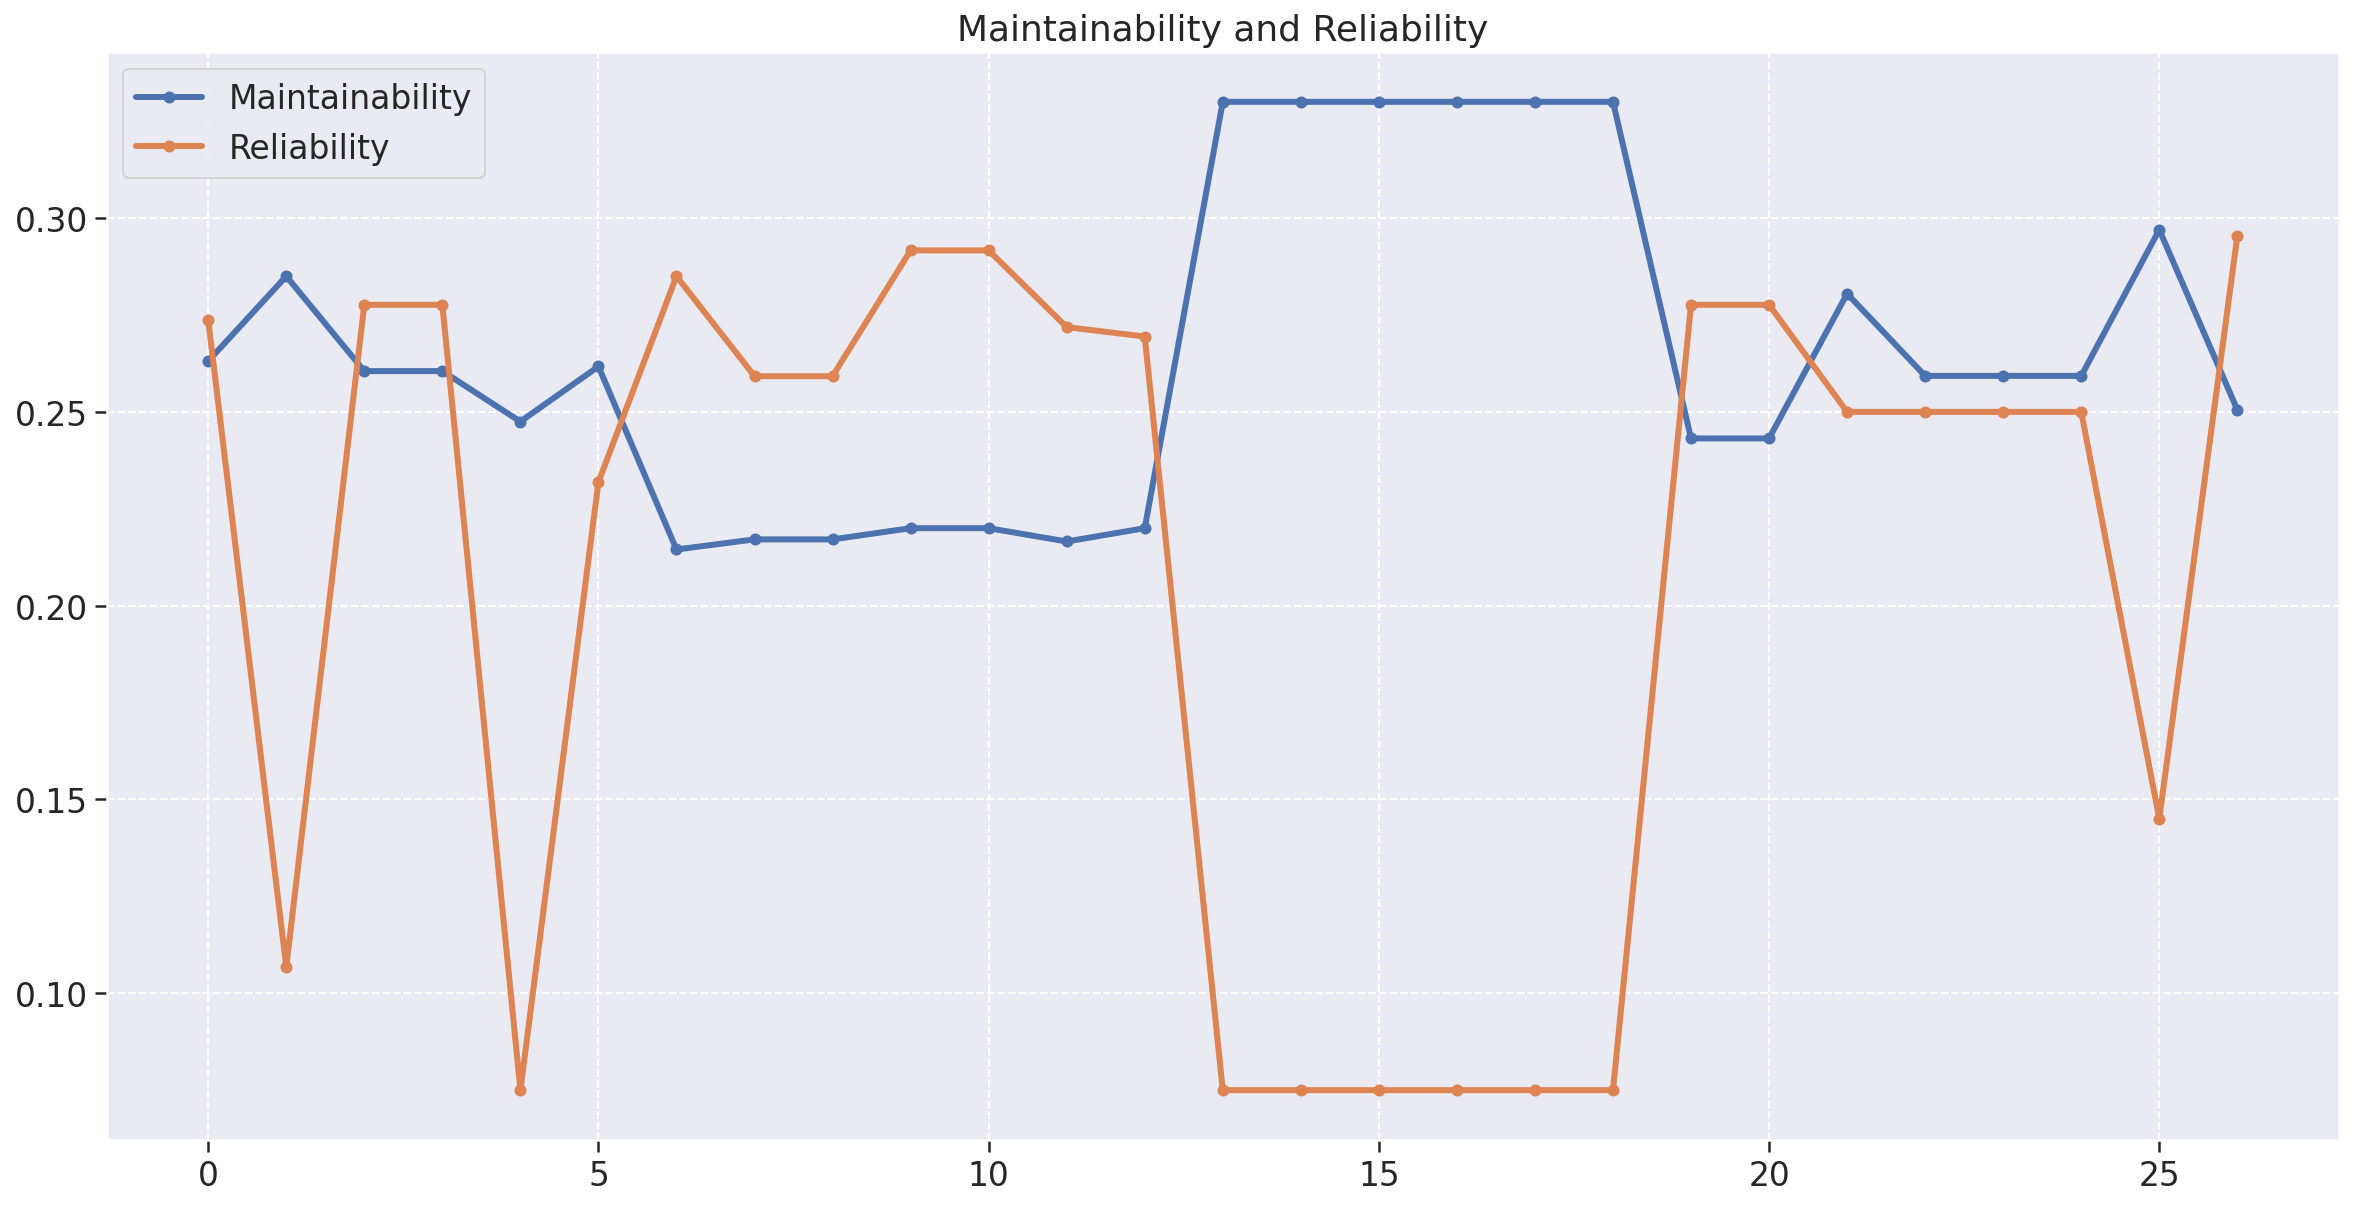

In [64]:
fig = plt.figure(figsize=(20, 10))

plt.title('Maintainability and Reliability')
plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')

#plt.ylim(.45,.7)
plt.legend(loc='upper left')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bc902e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bc9125b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bc902be0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bc912cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bc91c0a0>],
 'means': []}

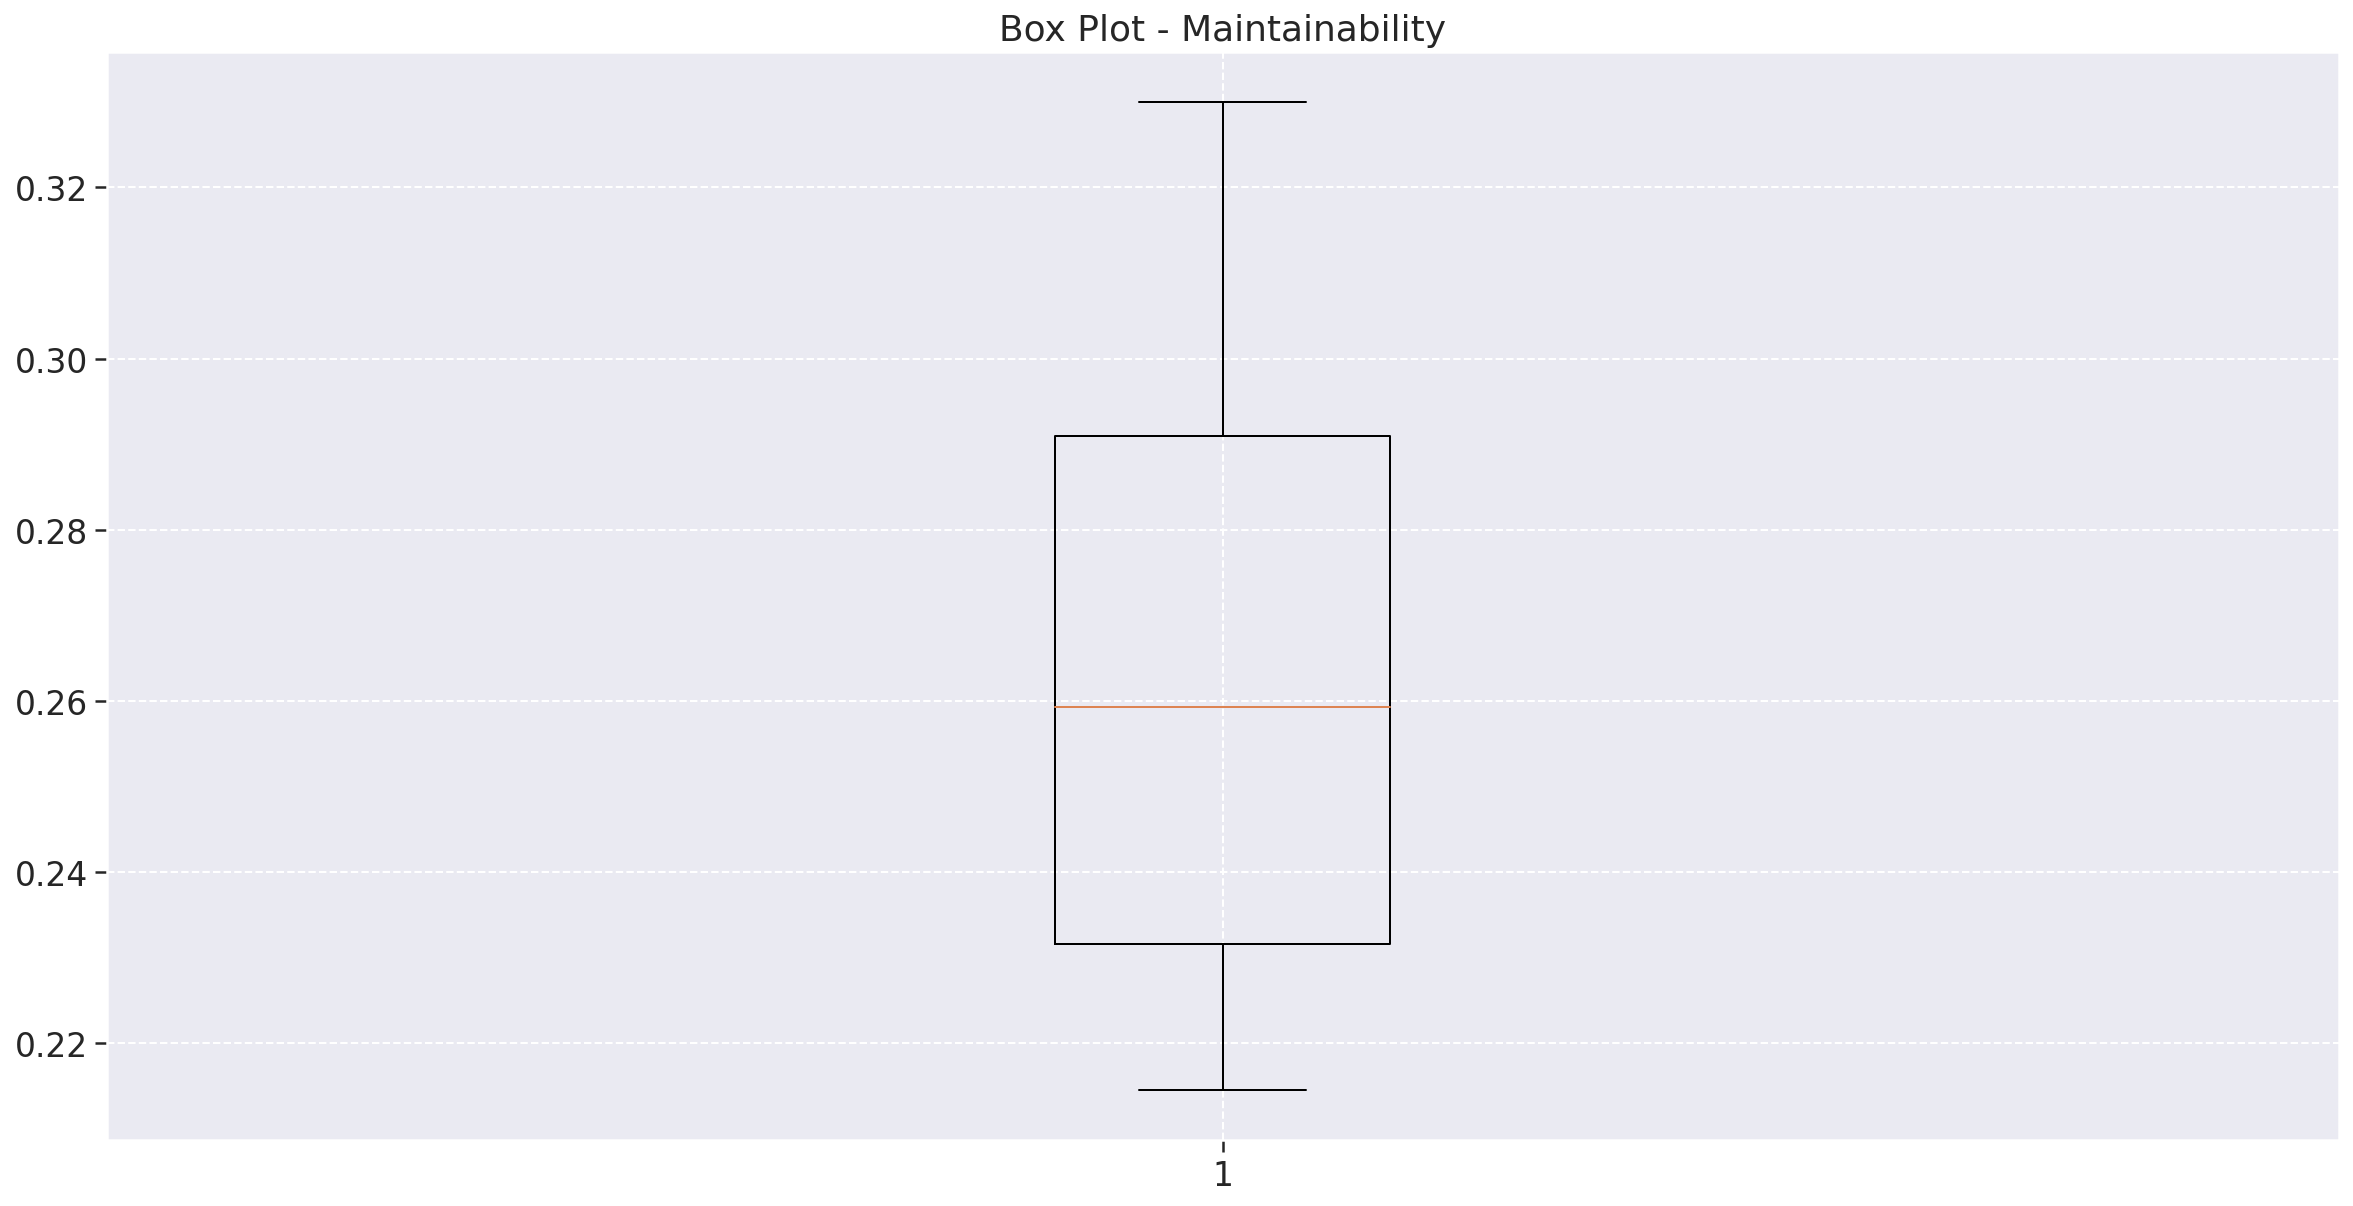

In [65]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability')
plt.boxplot(metrics_df['maintainability'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bc86caf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bc879250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bc86c760>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bc879970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bc879d00>],
 'means': []}

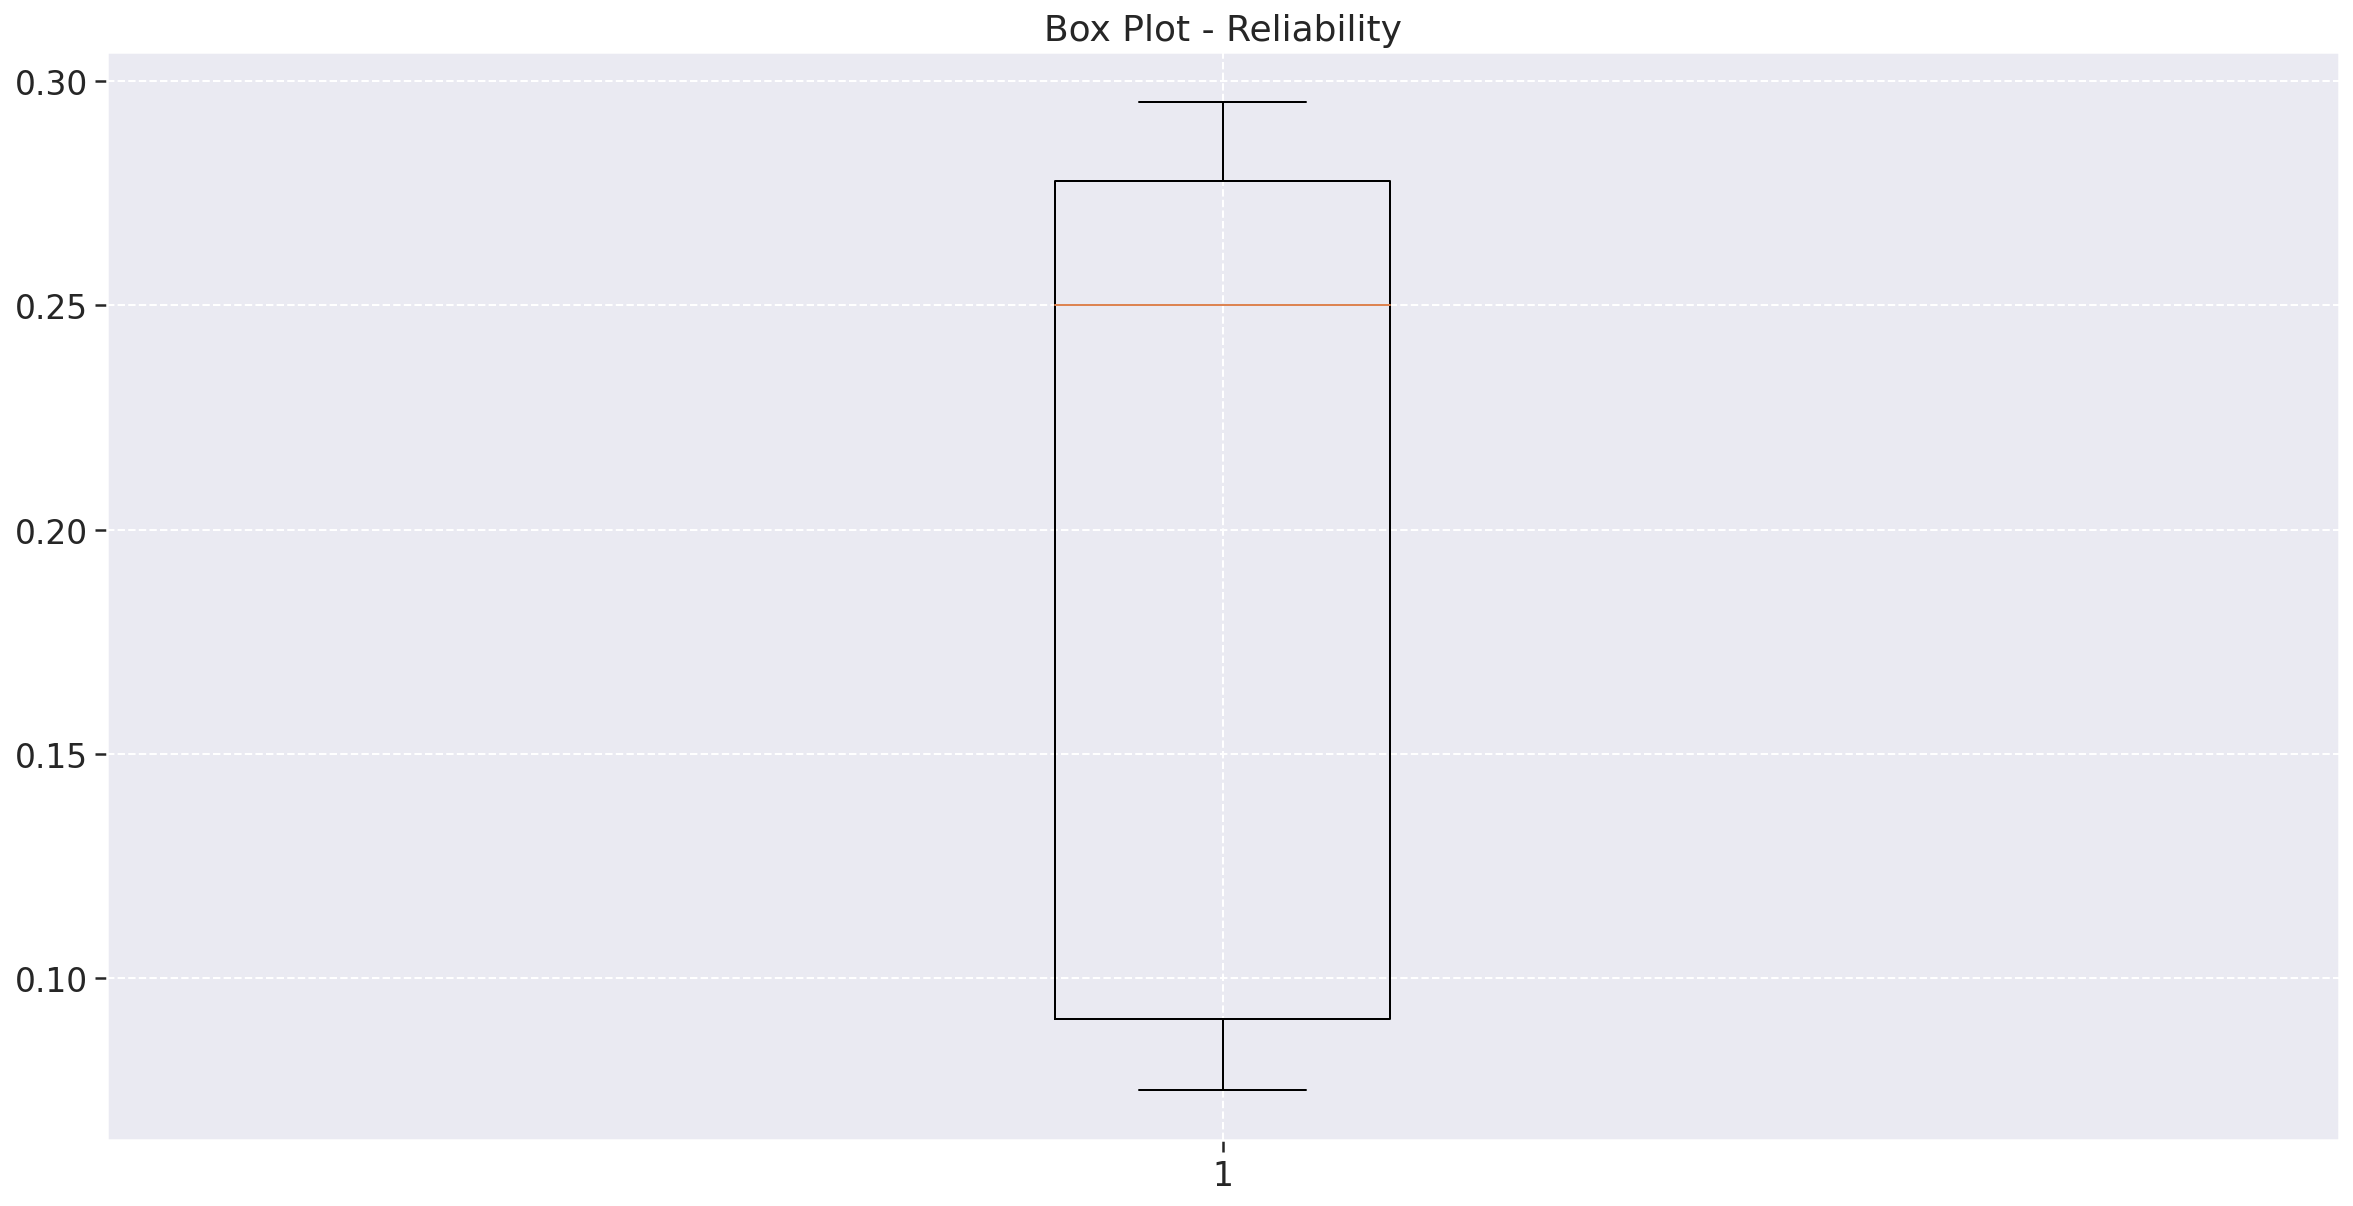

In [66]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Reliability')
plt.boxplot(metrics_df['Reliability'])

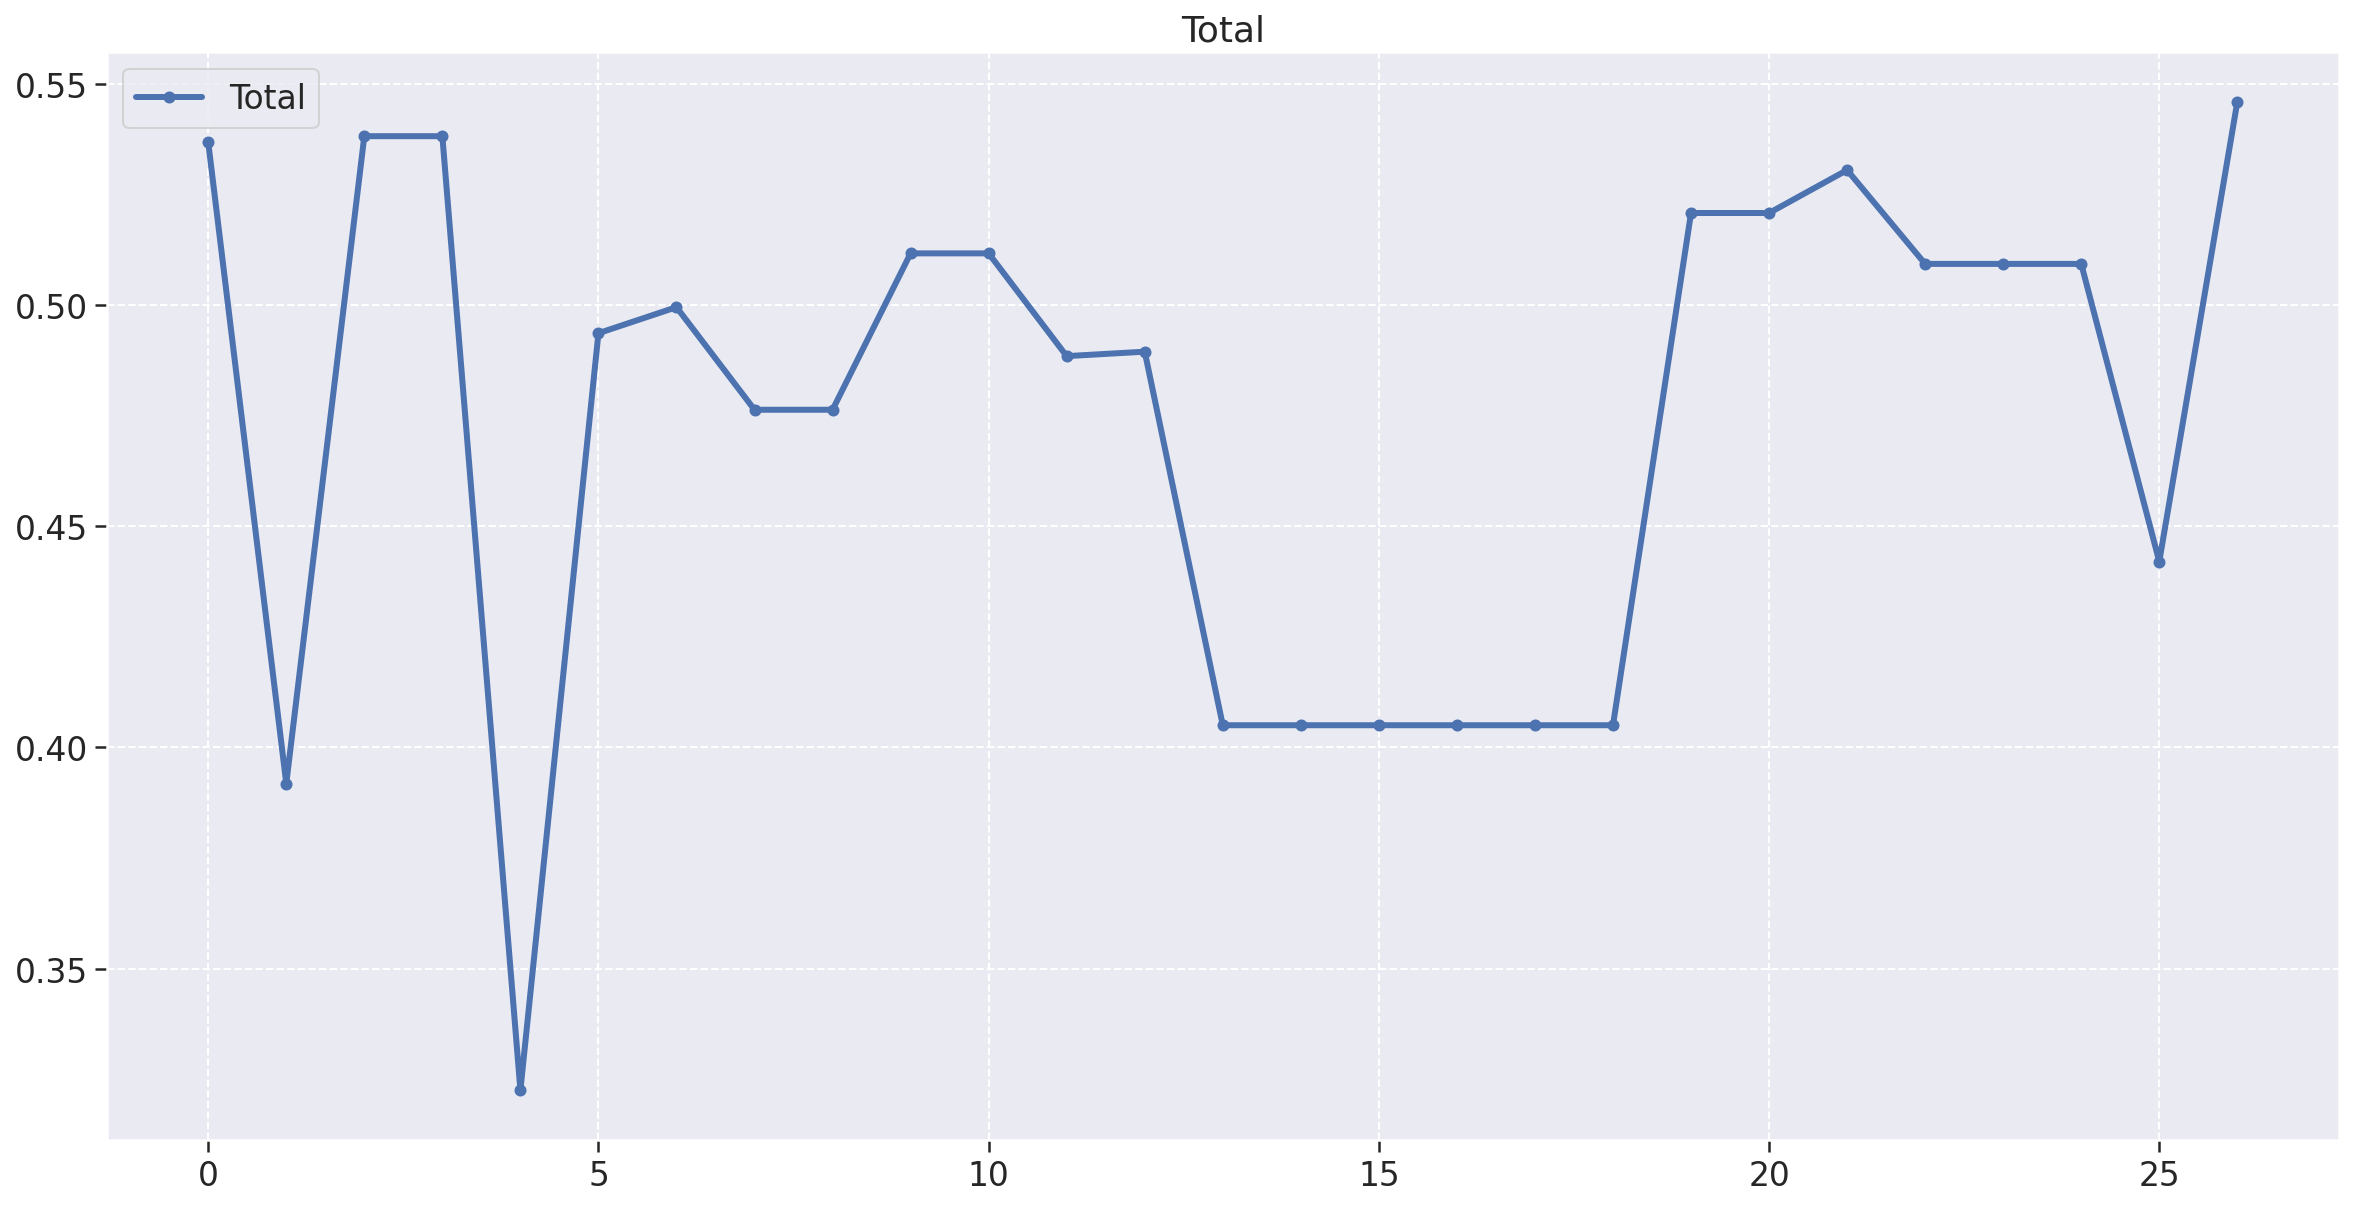

In [67]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5, label='Total')

plt.legend(loc='upper left')

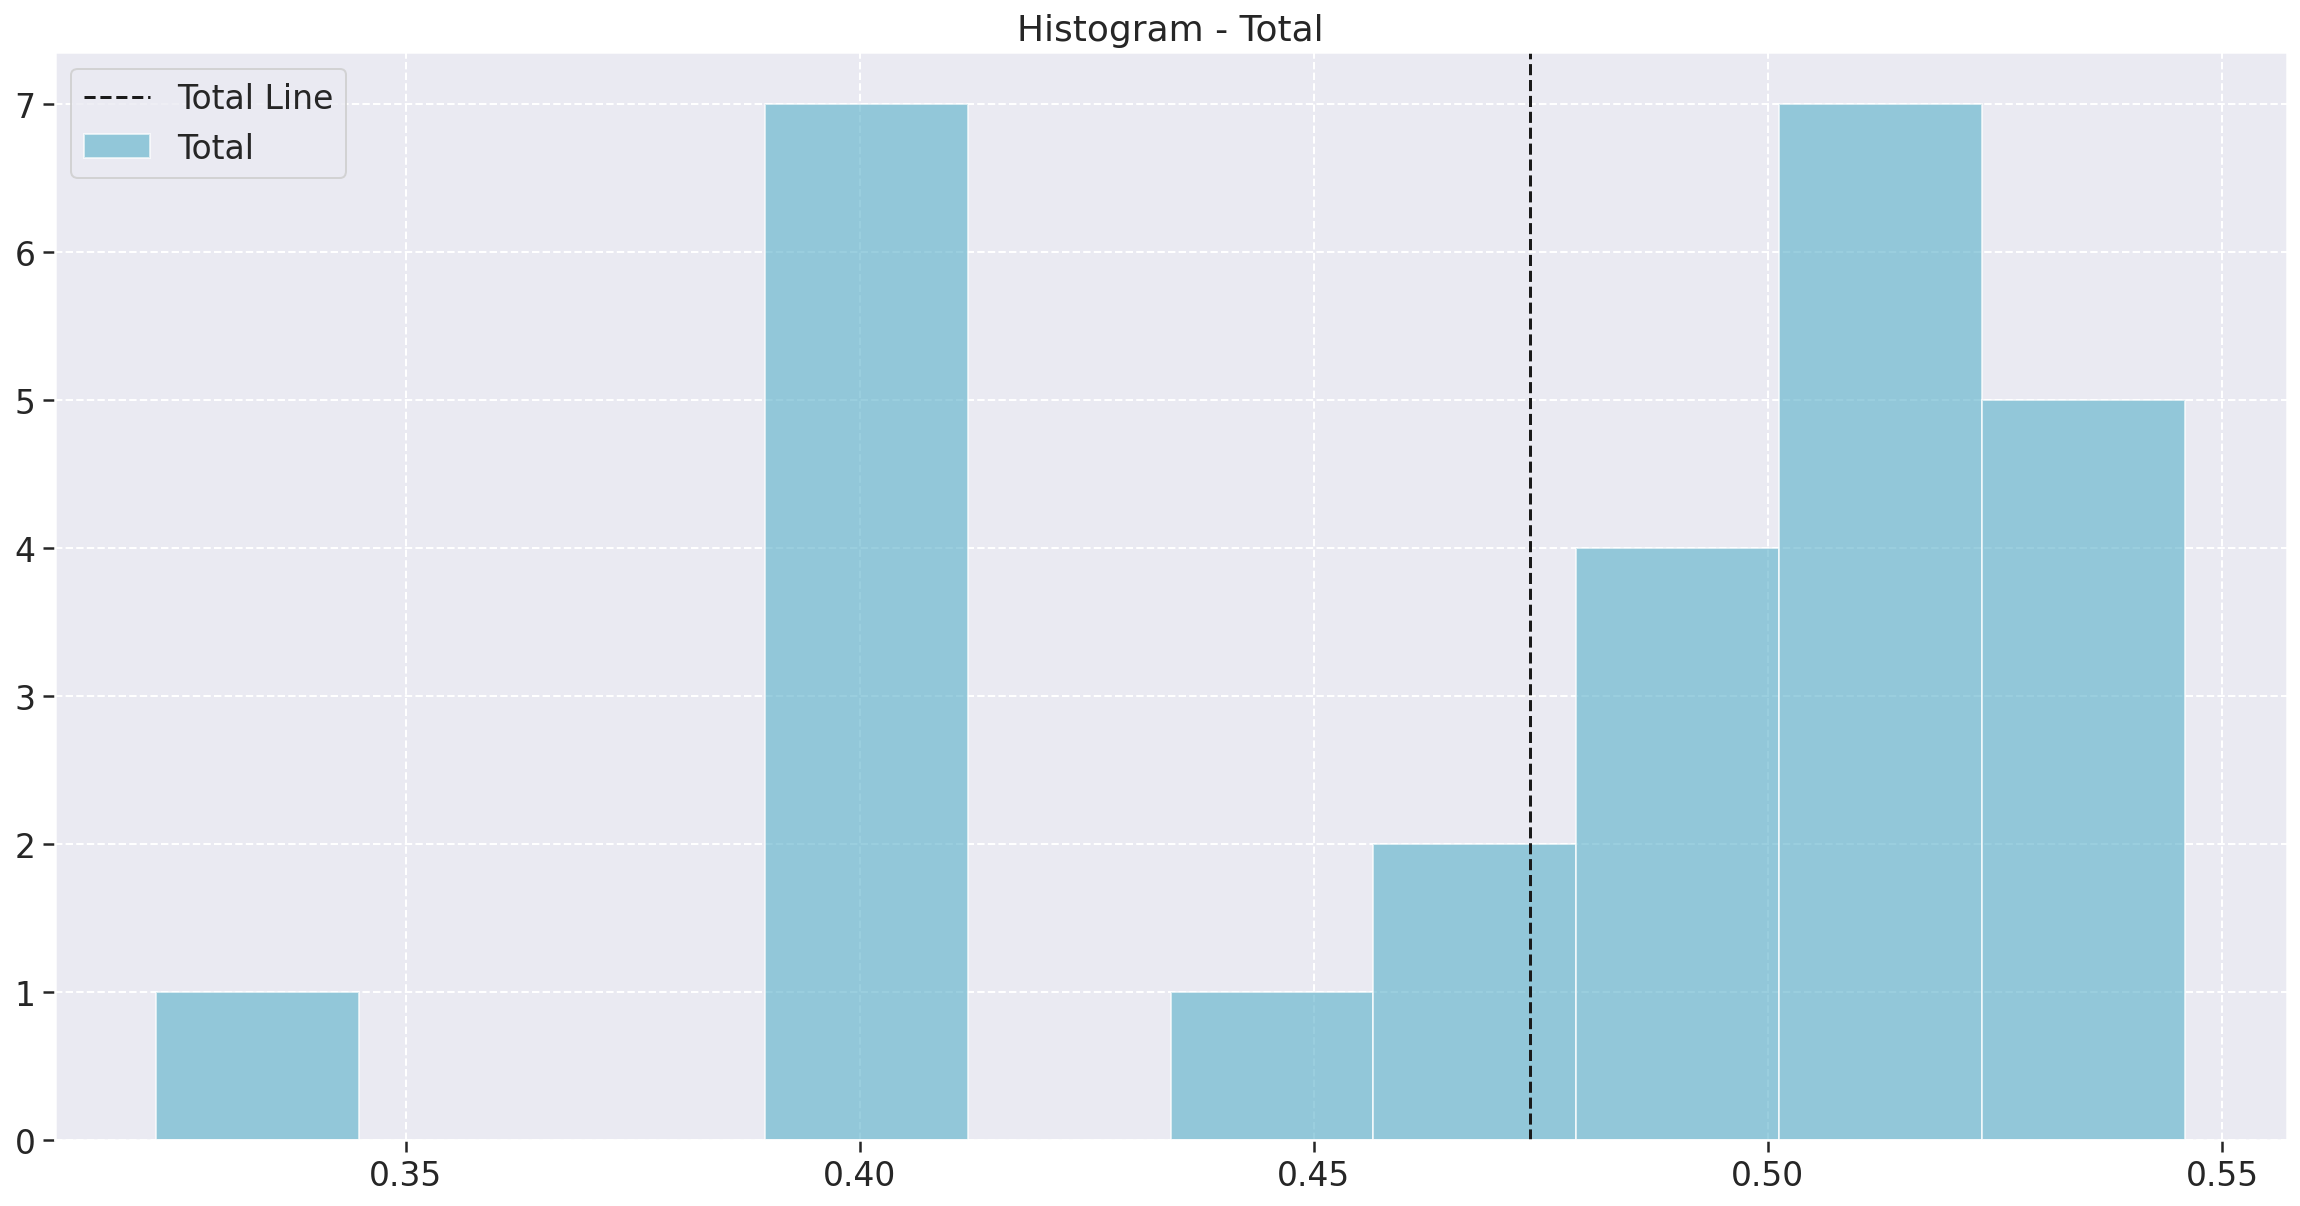

In [68]:
fig = plt.figure(figsize=(20, 10))

plt.title('Histogram - Total')
plt.hist(metrics_df['total'], bins=10, color='c', alpha=0.65, label='Total')
plt.axvline(metrics_df['total'].mean(), color='k', linestyle='dashed', label='Total Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f32bc747d60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f32bc7544c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f32bc7479d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32bc754be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32bc754f70>],
 'means': []}

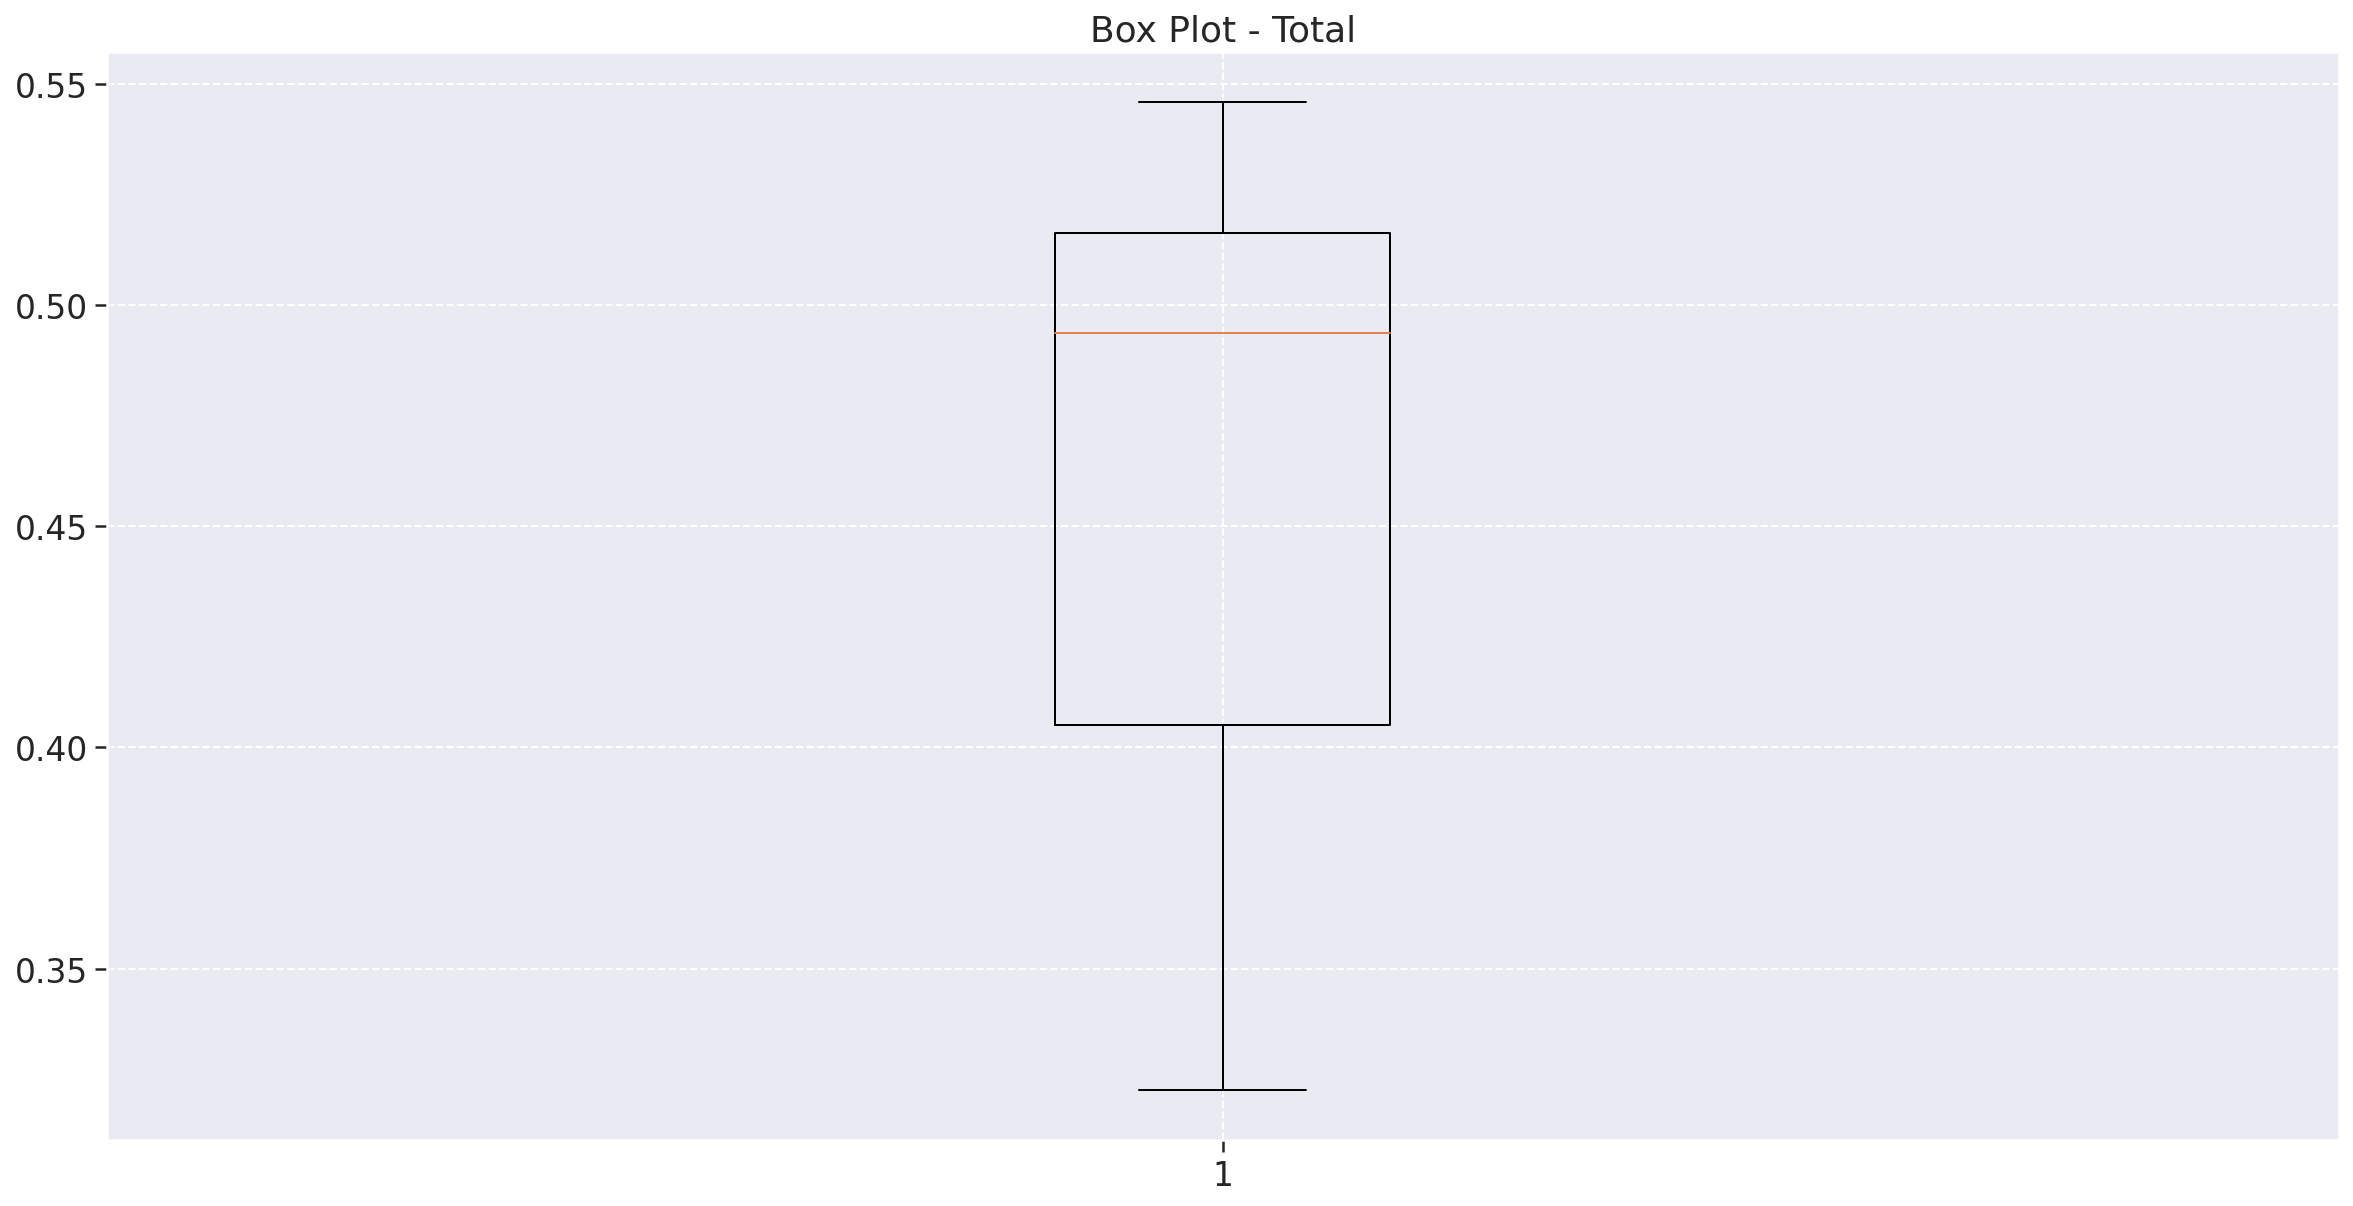

In [69]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Total')
plt.boxplot(metrics_df['total'])

Text(0.5, 1.0, 'Matriz de Correção')

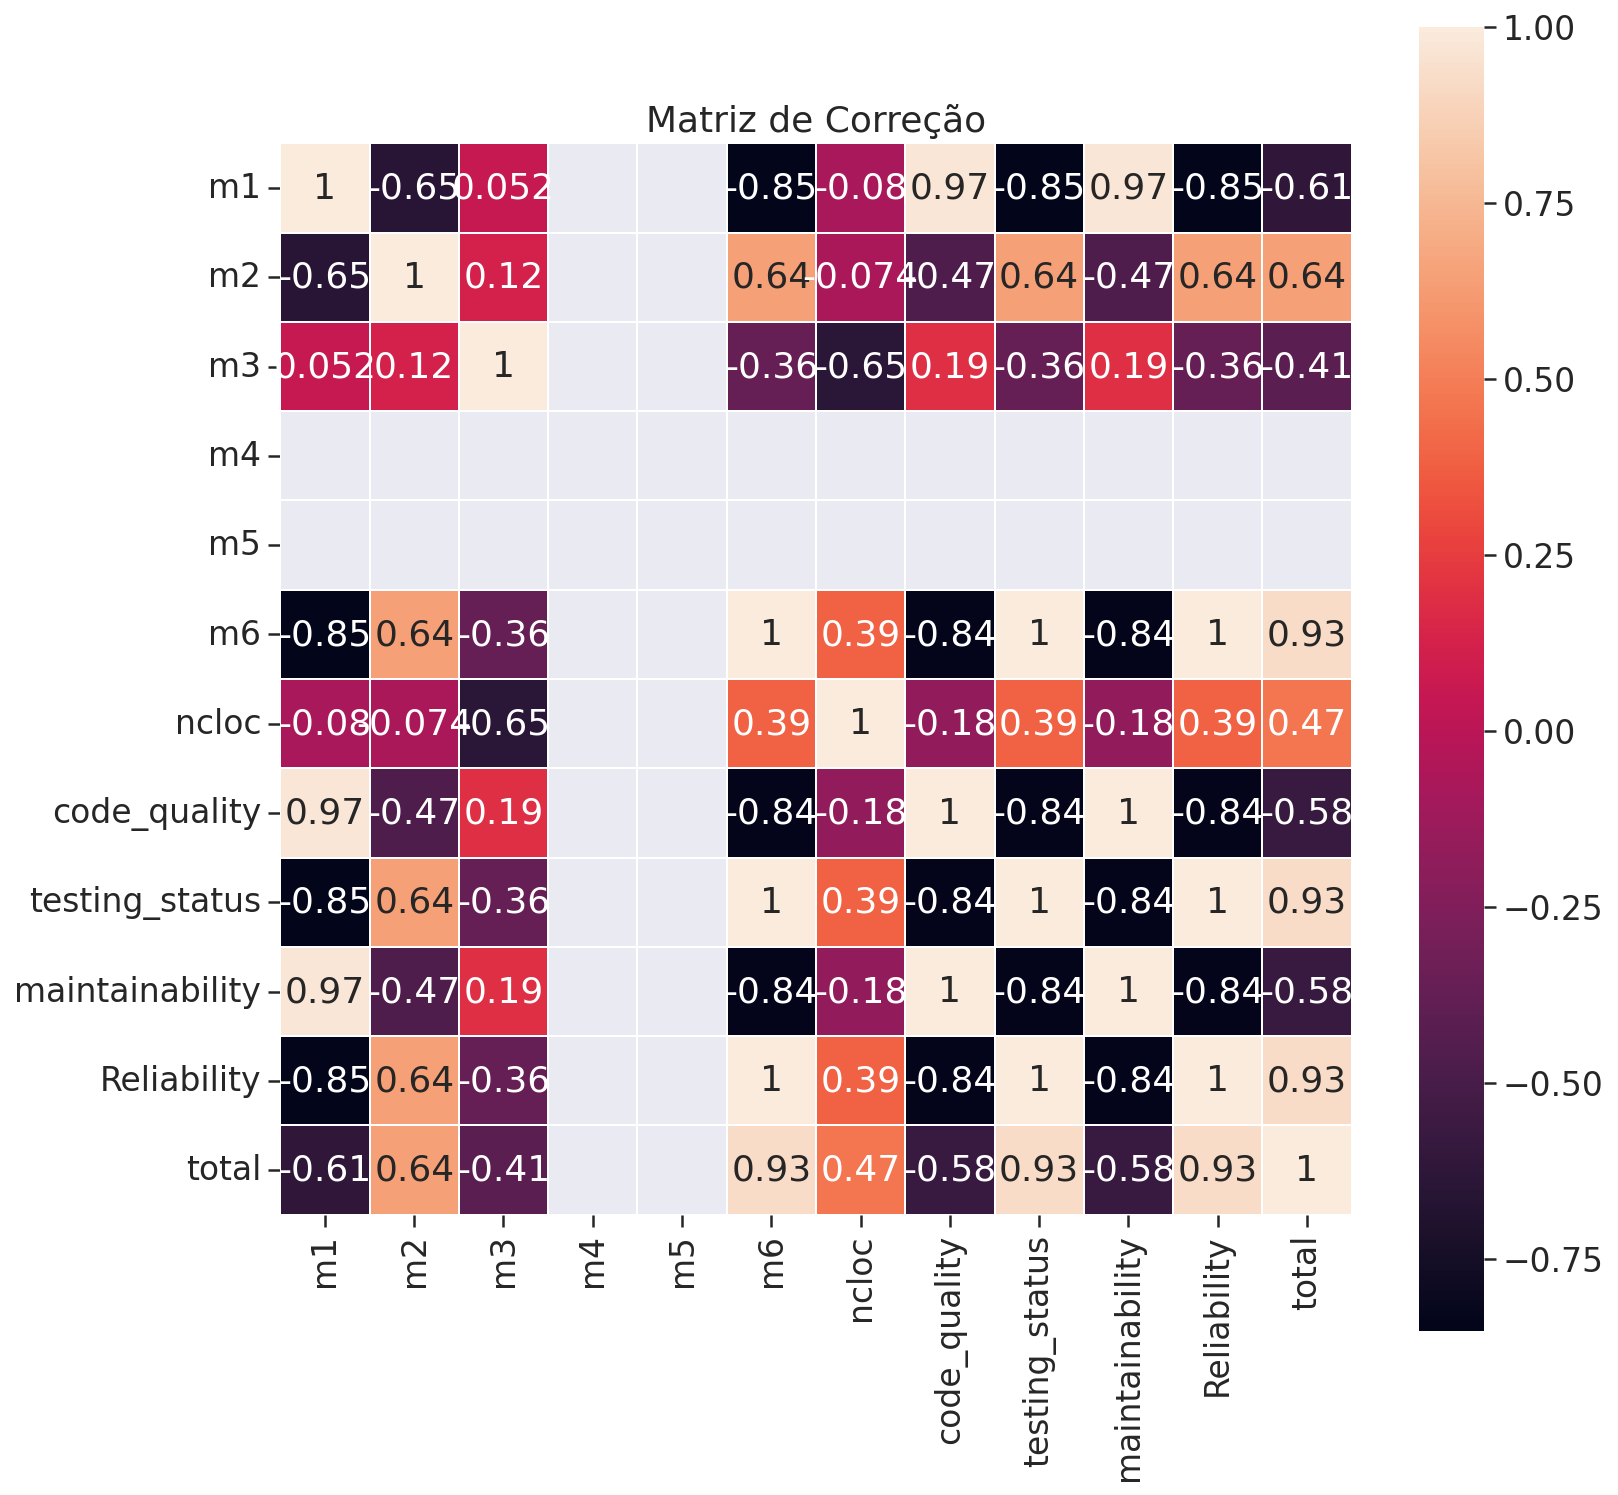

In [70]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(metrics_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção')

In [71]:
metrics_final_df = pd.concat([scraper_metrics, documentsapi_metrics, mltraining_metrics, frontend_metrics], ignore_index=True)
metrics_final_df.drop('Reliability', axis=1, inplace=True)
metrics_final_df.drop('maintainability', axis=1, inplace=True)
metrics_final_df.insert(6, 'Maintainability', metrics_final_df['code_quality'] * pc1)
metrics_final_df.insert(7, 'Reliability', metrics_final_df['testing_status'] * pc2)
metrics_final_df.insert(8, 'Total_QR', metrics_final_df['Maintainability'] + metrics_final_df['Reliability'])
metrics_final_df.insert(9, 'LOC', metrics_final_df['ncloc'])
metrics_final_df.insert(10, 'Repository', metrics_final_df['repository'])
metrics_final_df.insert(11, 'Version', metrics_final_df['version'])
metrics_final_df.drop('ncloc', axis=1, inplace=True)
metrics_final_df.drop('repository', axis=1, inplace=True)
metrics_final_df.drop('code_quality', axis=1, inplace=True)
metrics_final_df.drop('testing_status', axis=1, inplace=True)
metrics_final_df.drop('version', axis=1, inplace=True)
metrics_final_df['Data'] = metrics_final_df['Version']

In [72]:
metrics_final_df

,m1,m2,m3,m4,m5,m6,Maintainability,Reliability,Total_QR,LOC,Repository,Version,Data
0,0.432432,0.162162,1.000000,1.0,0,0.567568,0.263108,0.273649,0.536757,1348,Scraper,02-11-2021-23-26,02-11-2021-23-26
1,0.636364,0.090909,1.000000,1.0,0,0.090909,0.285000,0.106818,0.391818,484,Scraper,07-10-2021-07-43,07-10-2021-07-43
2,0.421053,0.157895,1.000000,1.0,0,0.578947,0.260526,0.277632,0.538158,1337,Scraper,07-11-2021-19-54,07-11-2021-19-54
3,0.421053,0.157895,1.000000,1.0,0,0.578947,0.260526,0.277632,0.538158,1337,Scraper,10-11-2021-00-55,10-11-2021-00-55
4,0.500000,0.000000,1.000000,1.0,0,0.000000,0.247500,0.075000,0.322500,138,Scraper,15-09-2021-00-01,15-09-2021-00-01
5,0.482759,0.103448,1.000000,1.0,0,0.448276,0.261724,0.231897,0.493621,1058,Scraper,21-10-2021-15-11,21-10-2021-15-11
6,0.200000,0.100000,1.000000,1.0,0,0.600000,0.214500,0.285000,0.499500,359,DocumentsAPI,02-11-2021-23-35,02-11-2021-23-35
7,0.210526,0.105263,1.000000,1.0,0,0.526316,0.217105,0.259211,0.476316,336,DocumentsAPI,07-10-2021-07-31,07-10-2021-07-31
8,0.210526,0.105263,1.000000,1.0,0,0.526316,0.217105,0.259211,0.476316,341,DocumentsAPI,07-10-2021-12-28,07-10-2021-12-28
9,0.238095,0.095238,1.000000,1.0,0,0.619048,0.220000,0.291667,0.511667,482,DocumentsAPI,07-11-2021-18-29,07-11-2021-18-29


### Análise

Observando-se todas a métricas apresentadas, pode se concluir que com os valores são bem abaixo do esperado, diante de tomadas de decisões, tais como prioridades a serem realizadas, como consequência, houve uma enorme carência relacionado aos testes nos demais projetos, foi realizado testes apenas nos projetos: Documents API e no Scraper.

Com o gráfico de Confiabilidade e Manutenibilidade, os valores estão basicamente se opondo um ao outro. Tais dados pode se ver claramente por questões de impactos ocorridos diante ao seu desenvolvimento do projeto. Tais como decisões tomadas, problemas relacionados ao time também, como saídas de alguns integrantes (ocorrendo uma carência para desenvolvimento maior), curva de aprendizados, desafios diante ao desenvolvimento e outras circunstâncias.

Pode se reparar diante aos valores do Reliability com a sua depedência referente aos testes, tais como teste de unidades, testes de execução e dentre outros, há um gráfico não constante e bem abaixo do esperado. Contudo visando o futuro e as melhorias, então há uma dependência para implementações de testes, em todos os projetos e visando o 100% diante do coverage.

Com o Maintainalibity, também se encontra com valores abaixo do esperado, tais como valores podem ser solucionados com a ajuda do SonarQube, tais como qualidade de código, complexidades, comentários, duplicações de códigos e dentre outros. Pode se ver que na última linha do gráfico, foi visto um ganho maior, visando valores melhores para ser atingindos. 

In [73]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

metrics_final_df.to_excel('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_final_df.to_csv('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.csv'.format(currentTime), index = False)